In [1]:
from pathlib import Path
import json
import random
import numpy as np
import pandas as pd
import soundfile as sf

import librosa

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
CSV_PATH = Path("../../data/processed/icbhi/icbhi_segments.csv")
WAV_DIR  = Path("../../data/processed/icbhi/audio_4000hz_bp_segments_no_filter")

OUT_DIR = Path("../../data/processed/icbhi/baseline_runs_all_labels_no_filter")
OUT_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cuda'

In [3]:
df = pd.read_csv(CSV_PATH)

LABEL_COL   = "acoustic_label"
PATIENT_COL = "patient_id"

df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip().str.lower()

EXPECTED = {"normal", "crackle", "wheeze", "mixed", "reject"}
bad_labels = set(df[LABEL_COL].unique()) - EXPECTED
if bad_labels:
    raise ValueError(f"Unexpected labels: {sorted(bad_labels)}")

In [4]:
df

record_id                   file_name  segment_index  \
0      101_1b1_Al_sc_Meditron  101_1b1_Al_sc_Meditron.wav              0   
1      101_1b1_Al_sc_Meditron  101_1b1_Al_sc_Meditron.wav              1   
2      101_1b1_Al_sc_Meditron  101_1b1_Al_sc_Meditron.wav              2   
3      101_1b1_Al_sc_Meditron  101_1b1_Al_sc_Meditron.wav              3   
4      101_1b1_Al_sc_Meditron  101_1b1_Al_sc_Meditron.wav              4   
...                       ...                         ...            ...   
17929  226_1b1_Pl_sc_LittC2SE  226_1b1_Pl_sc_LittC2SE.wav             13   
17930  226_1b1_Pl_sc_LittC2SE  226_1b1_Pl_sc_LittC2SE.wav             14   
17931  226_1b1_Pl_sc_LittC2SE  226_1b1_Pl_sc_LittC2SE.wav             15   
17932  226_1b1_Pl_sc_LittC2SE  226_1b1_Pl_sc_LittC2SE.wav             16   
17933  226_1b1_Pl_sc_LittC2SE  226_1b1_Pl_sc_LittC2SE.wav             17   

       seg_start_sec  seg_end_sec  seg_duration_sec acoustic_label  \
0                0.0          2.5               2.5         normal   
1                1.0          3.5               2.5         normal   
2                2.0          4.5               2.5         normal   
3                3.0          5.5               2.5         normal   
4                4.0          6.5               2.5         normal   
...              ...          ...               ...            ...   
17929           13.0         15.5               2.5         reject   
17930           14.0         16.5               2.5         normal   
17931           15.0         17.5               2.5         normal   
17932           16.0         18.5               2.5         reject   
17933           17.0         19.5               2.5         reject   

       frac_normal  frac_wheeze  frac_crackle  frac_crackle_wheeze  \
0            0.986          0.0         0.000                  0.0   
1            1.000          0.0         0.000                  0.0   
2            1.000          0.0         0.000                  0.0   
3            1.000          0.0         0.000                  0.0   
4            1.000          0.0         0.000                  0.0   
...            ...          ...           ...                  ...   
17929        0.723          0.0         0.277                  0.0   
17930        1.000          0.0         0.000                  0.0   
17931        0.997          0.0         0.003                  0.0   
17932        0.597          0.0         0.403                  0.0   
17933        0.223          0.0         0.777                  0.0   

       patient_id  diagnosis chest_location  
0             101       URTI             Al  
1             101       URTI             Al  
2             101       URTI             Al  
3             101       URTI             Al  
4             101       URTI             Al  
...           ...        ...            ...  
17929         226  Pneumonia             Pl  
17930         226  Pneumonia             Pl  
17931         226  Pneumonia             Pl  
17932         226  Pneumonia             Pl  
17933         226  Pneumonia             Pl  

[17934 rows x 14 columns]

In [5]:
df['acoustic_label'].value_counts()

acoustic_label
normal     7727
crackle    4090
reject     2469
mixed      1903
wheeze     1745
Name: count, dtype: int64

In [6]:
# drop reject labels
df = df[df[LABEL_COL] != "reject"].reset_index(drop=True)

In [7]:
SEGMENT_NAME_PATTERN = "{stem}_seg{seg:03d}.wav"

In [8]:
def build_segment_path(file_name: str, segment_index: int) -> Path:
    stem = str(file_name).strip()
    if stem.lower().endswith(".wav"):
        stem = stem[:-4]
    fn = SEGMENT_NAME_PATTERN.format(stem=stem, seg=int(segment_index))
    return (WAV_DIR / fn).resolve()

df["audio_path"] = df.apply(lambda r: build_segment_path(r["file_name"], r["segment_index"]), axis=1)
df = df[df["audio_path"].apply(lambda p: p.exists())].reset_index(drop=True)

p0 = df.loc[0, "audio_path"]
info = sf.info(str(p0))
if info.samplerate != 4000:
    raise ValueError(f"Unexpected samplerate {info.samplerate} in {p0}")

In [9]:
groups = df[PATIENT_COL].astype(str)

gss1 = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
train_idx, test_idx = next(gss1.split(df, groups=groups))
df_trainval = df.iloc[train_idx].reset_index(drop=True)
df_test = df.iloc[test_idx].reset_index(drop=True)

groups_tv = df_trainval[PATIENT_COL].astype(str)
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
train_idx2, val_idx2 = next(gss2.split(df_trainval, groups=groups_tv))
df_train = df_trainval.iloc[train_idx2].reset_index(drop=True)
df_val = df_trainval.iloc[val_idx2].reset_index(drop=True)

In [10]:
df[LABEL_COL].value_counts()

acoustic_label
normal     7727
crackle    4090
mixed      1903
wheeze     1745
Name: count, dtype: int64

In [11]:
LABELS = ["normal", "crackle", "wheeze", "mixed"]
label2id = {l: i for i, l in enumerate(LABELS)}
id2label = {i: l for l, i in label2id.items()}


In [12]:
def compute_class_weights(df_train: pd.DataFrame) -> torch.Tensor:
    counts = df_train[LABEL_COL].value_counts().reindex(LABELS, fill_value=0).values.astype(np.float32)
    weights = counts.sum() / (len(LABELS) * np.maximum(counts, 1.0))
    return torch.tensor(weights, dtype=torch.float32)

def make_balanced_subset(df_train: pd.DataFrame, normal_name="normal") -> pd.DataFrame:
    vc = df_train[LABEL_COL].value_counts()
    if normal_name not in vc.index:
        return df_train
    non_normal = vc.drop(index=[normal_name])
    if len(non_normal) == 0:
        return df_train
    target = int(non_normal.min())
    df_normal = df_train[df_train[LABEL_COL] == normal_name].sample(
        n=min(target, int(vc[normal_name])),
        random_state=SEED
    )
    df_rest = df_train[df_train[LABEL_COL] != normal_name]
    return pd.concat([df_rest, df_normal], ignore_index=True).sample(frac=1, random_state=SEED).reset_index(drop=True)

In [13]:
FS_TARGET = 4000
N_FFT = 256
HOP_LENGTH = 64
N_MELS = 64
FMIN = 20
FMAX = FS_TARGET // 2

CACHE_DIR = OUT_DIR / "features_cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)


In [14]:
def minmax01(x: np.ndarray) -> np.ndarray:
    x_min = float(np.min(x))
    x_max = float(np.max(x))
    if (x_max - x_min) < 1e-12:
        return np.zeros_like(x, dtype=np.float32)
    return ((x - x_min) / (x_max - x_min)).astype(np.float32)

def feat_logmel(y: np.ndarray, sr: int) -> np.ndarray:
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH,
        n_mels=N_MELS, fmin=FMIN, fmax=FMAX, power=2.0
    )
    S_db = librosa.power_to_db(S, ref=np.max)
    return minmax01(S_db)

def feat_stft(y: np.ndarray, sr: int) -> np.ndarray:
    D = librosa.stft(y=y, n_fft=N_FFT, hop_length=HOP_LENGTH, center=True)
    P = (np.abs(D) ** 2).astype(np.float32)
    P_db = librosa.power_to_db(P, ref=np.max)
    return minmax01(P_db)


In [15]:
def segment_key(row) -> str:
    stem = str(row["file_name"]).replace(".wav", "")
    seg = int(row["segment_index"])
    return f"{stem}__seg_{seg:03d}"

def cache_path(feature_type: str, key: str) -> Path:
    d = CACHE_DIR / feature_type
    d.mkdir(parents=True, exist_ok=True)
    return d / f"{key}.npz"

def extract_and_cache(row, feature_type: str) -> Path:
    key = segment_key(row)
    cp = cache_path(feature_type, key)
    if cp.exists():
        return cp

    audio_path = Path(row["audio_path"])
    if not audio_path.exists():
        raise FileNotFoundError(str(audio_path))

    y, sr = sf.read(str(audio_path), dtype="float32")
    if y.ndim > 1:
        y = np.mean(y, axis=1)

    if sr != FS_TARGET:
        y = librosa.resample(y, orig_sr=sr, target_sr=FS_TARGET)
        sr = FS_TARGET

    if feature_type == "logmel":
        X = feat_logmel(y, sr)
    elif feature_type == "stft":
        X = feat_stft(y, sr)
    else:
        raise ValueError(feature_type)

    X = X[..., None].astype(np.float32)
    y_id = label2id[str(row[LABEL_COL]).strip().lower()]

    np.savez_compressed(cp, X=X, y=y_id)
    return cp


In [16]:
class CachedFeatureDataset(Dataset):
    def __init__(self, df_split: pd.DataFrame, feature_type: str):
        self.df = df_split.reset_index(drop=True).copy()
        self.feature_type = feature_type
        self.cache_files = []
        for i in range(len(self.df)):
            row = self.df.iloc[i]
            cp = extract_and_cache(row, feature_type)
            self.cache_files.append(str(cp))

    def __len__(self):
        return len(self.cache_files)

    def __getitem__(self, idx):
        z = np.load(self.cache_files[idx])
        X = z["X"]
        y = int(z["y"])
        X = torch.from_numpy(X).permute(2, 0, 1).contiguous()
        return X, y


In [17]:
class SmallCNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(4, 2), padding=(1, 0)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            nn.Conv2d(8, 32, kernel_size=(4, 2), padding=(1, 0)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            nn.Conv2d(32, 32, kernel_size=(4, 2), padding=(1, 0)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            nn.Conv2d(32, 32, kernel_size=(4, 2), padding=(1, 0)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 2)),  # reduced stride in height dim
        )

        self.dropout1 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(1, 2000)  # placeholder; we set in forward after we know flatten dim
        self.dropout2 = nn.Dropout(p=0.50)
        self.out = nn.Linear(2000, n_classes)

        self._fc_initialized = False

    def _init_fc(self, x):
        flat_dim = x.shape[1]
        self.fc1 = nn.Linear(flat_dim, 2000).to(x.device)
        self._fc_initialized = True

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        if not self._fc_initialized:
            self._init_fc(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.out(x)


In [18]:
def run_epoch(model, loader, optimizer, criterion, train=True):
    model.train(train)
    total_loss = 0.0
    correct = 0
    total = 0
    for X, y in loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(X)
        loss = criterion(logits, y)
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_loss += float(loss.item()) * X.size(0)
        pred = logits.argmax(dim=1)
        correct += int((pred == y).sum().item())
        total += int(X.size(0))
    return total_loss / max(total, 1), correct / max(total, 1)

@torch.no_grad()
def predict(model, loader):
    model.eval()
    ys, ps = [], []
    for X, y in loader:
        X = X.to(DEVICE)
        logits = model(X)
        pred = logits.argmax(dim=1).cpu().numpy()
        ys.extend(y.numpy().tolist())
        ps.extend(pred.tolist())
    return np.array(ys), np.array(ps)


In [ ]:
def run_experiment(feature_type="logmel", use_weights=False, use_balanced=False,
                   subset_n=None,  # <--- kies bv. 200, 500, 1000
                   epochs=10, batch_size=8, lr=1e-3):

    exp_name = f"{feature_type}__weights_{int(use_weights)}__balanced_{int(use_balanced)}"
    exp_dir = OUT_DIR / exp_name
    exp_dir.mkdir(parents=True, exist_ok=True)
    train_df = make_balanced_subset(df_train) if use_balanced else df_train

    # --- SNELLE SUBSET (simpel) ---
    if subset_n is not None and subset_n < len(train_df):
        train_df = train_df.sample(n=subset_n, random_state=SEED).reset_index(drop=True)
    # ------------------------------

    ds_train = CachedFeatureDataset(train_df, feature_type)
    ds_val   = CachedFeatureDataset(df_val, feature_type)
    ds_test  = CachedFeatureDataset(df_test, feature_type)

    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=0)
    dl_val  = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=0)
    dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=0)

    model = SmallCNN(n_classes=len(LABELS)).to(DEVICE)

    if use_weights:
        w = compute_class_weights(train_df).to(DEVICE)  # weights nu op subset
        criterion = nn.CrossEntropyLoss(weight=w)
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if use_weights:
        w = compute_class_weights(train_df).to(DEVICE)
        criterion = nn.CrossEntropyLoss(weight=w)
    else:
        criterion = nn.CrossEntropyLoss()

    cfg = {
        "feature_type": feature_type,
        "use_weights": use_weights,
        "use_balanced": use_balanced,
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": lr,
        "seed": SEED,
        "labels": LABELS,
        "csv_path": str(CSV_PATH),
        "wav_dir": str(WAV_DIR),
        "segment_name_pattern": SEGMENT_NAME_PATTERN,
    }
    (exp_dir / "config.json").write_text(json.dumps(cfg, indent=2))

    best_val = float("inf")
    best_path = exp_dir / "best.pt"

    history = []
    for ep in range(1, epochs + 1):
        tr_loss, tr_acc = run_epoch(model, dl_train, optimizer, criterion, train=True)
        va_loss, va_acc = run_epoch(model, dl_val, optimizer, criterion, train=False)
        history.append({
            "epoch": ep,
            "train_loss": tr_loss, "train_acc": tr_acc,
            "val_loss": va_loss, "val_acc": va_acc
        })
        if va_loss < best_val:
            best_val = va_loss
            torch.save(model.state_dict(), best_path)

    pd.DataFrame(history).to_csv(exp_dir / "history.csv", index=False)

    model.load_state_dict(torch.load(best_path, map_location=DEVICE))
    y_true, y_pred = predict(model, dl_test)

    report = classification_report(y_true, y_pred, target_names=LABELS, digits=4, output_dict=True)
    pd.DataFrame(report).to_csv(exp_dir / "test_classification_report.csv")

    cm = confusion_matrix(y_true, y_pred)
    np.save(exp_dir / "confusion_matrix.npy", cm)

    return exp_dir


In [23]:
runs = []
for feat in ["logmel", "stft"]:
    for w in [False, True]:
        for b in [False, True]:
            runs.append(
                run_experiment(
                    feature_type=feat,
                    use_weights=w,
                    use_balanced=b,
                    subset_n=300,   # <--- HIER
                    epochs=10
                )
            )
runs

c:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

[WindowsPath('../../data/processed/icbhi/baseline_runs_all_labels_no_filter/logmel__weights_0__balanced_0'),
 WindowsPath('../../data/processed/icbhi/baseline_runs_all_labels_no_filter/logmel__weights_0__balanced_1'),
 WindowsPath('../../data/processed/icbhi/baseline_runs_all_labels_no_filter/logmel__weights_1__balanced_0'),
 WindowsPath('../../data/processed/icbhi/baseline_runs_all_labels_no_filter/logmel__weights_1__balanced_1'),
 WindowsPath('../../data/processed/icbhi/baseline_runs_all_labels_no_filter/stft__weights_0__balanced_0'),
 WindowsPath('../../data/processed/icbhi/baseline_runs_all_labels_no_filter/stft__weights_0__balanced_1'),
 WindowsPath('../../data/processed/icbhi/baseline_runs_all_labels_no_filter/stft__weights_1__balanced_0'),
 WindowsPath('../../data/processed/icbhi/baseline_runs_all_labels_no_filter/stft__weights_1__balanced_1')]

In [24]:
summary = []

for d in runs:
    rep_path = Path(d) / "test_classification_report.csv"
    rep = pd.read_csv(rep_path, index_col=0)

    if "f1-score" in rep.columns:
        macro_f1 = float(rep.loc["macro avg", "f1-score"])
    elif "f1-score" in rep.index:
        macro_f1 = float(rep.loc["f1-score", "macro avg"])
    else:
        # last resort: try transpose
        rep_t = rep.T
        if "f1-score" in rep_t.columns:
            macro_f1 = float(rep_t.loc["macro avg", "f1-score"])
        else:
            raise KeyError(f"Could not find macro F1 in {rep_path}")

    summary.append({"run": Path(d).name, "macro_f1": macro_f1})

summary_df = (
    pd.DataFrame(summary)
      .sort_values("macro_f1", ascending=False)
      .reset_index(drop=True)
)

summary_df

run  macro_f1
0  logmel__weights_0__balanced_0  0.151726
1  logmel__weights_1__balanced_0  0.151726
2    stft__weights_1__balanced_0  0.151726
3    stft__weights_0__balanced_0  0.151726
4  logmel__weights_1__balanced_1  0.116573
5  logmel__weights_0__balanced_1  0.116573
6    stft__weights_0__balanced_1  0.116573
7    stft__weights_1__balanced_1  0.116573

In [25]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def parse_exp_name(exp_dir: Path) -> str:
    name = Path(exp_dir).name
    parts = name.split("__")
    kv = {}
    for p in parts:
        if "_weights_" in p:
            # e.g. logmel__weights_1__balanced_0 (but your pattern is feature__weights_x__balanced_y)
            pass
    # robust parse: feature_type is first token, then weights_x, balanced_y
    feature_type = parts[0] if len(parts) > 0 else name
    weights = None
    balanced = None
    for p in parts[1:]:
        if p.startswith("weights_"):
            weights = p.split("weights_")[-1]
        if p.startswith("balanced_"):
            balanced = p.split("balanced_")[-1]

    def yn(v):
        if v is None:
            return "Unknown"
        return "Yes" if str(v) in {"1", "true", "True", "yes", "Yes"} else "No"

    title = f"ICBHI Baseline | Features: {feature_type.upper()} | Class Weights: {yn(weights)} | Balanced Subset: {yn(balanced)}"
    return title

def load_report_csv(report_path: Path) -> pd.DataFrame:
    rep = pd.read_csv(report_path, index_col=0)
    # Ensure rows are classes/avg and columns are metrics
    # If currently metrics are rows and classes are columns -> transpose
    if "f1-score" not in rep.columns and "f1-score" in rep.index:
        rep = rep.T
    return rep

def plot_train_curves(exp_dir, save=True, dpi=300):
    exp_dir = Path(exp_dir)
    title = parse_exp_name(exp_dir)

    hist_path = exp_dir / "history.csv"
    if not hist_path.exists():
        raise FileNotFoundError(hist_path)

    hist = pd.read_csv(hist_path)

    fig = plt.figure(figsize=(11, 4.5), dpi=dpi)
    fig.suptitle(title, fontsize=14, fontweight="bold", y=1.02)

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(hist["epoch"], hist["train_acc"], label="Train Acc", linewidth=2)
    ax1.plot(hist["epoch"], hist["val_acc"], label="Val Acc", linewidth=2)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim(0, 1.0)
    ax1.grid(True, alpha=0.3)
    ax1.legend(frameon=False)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(hist["epoch"], hist["train_loss"], label="Train Loss", linewidth=2)
    ax2.plot(hist["epoch"], hist["val_loss"], label="Val Loss", linewidth=2)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.grid(True, alpha=0.3)
    ax2.legend(frameon=False)

    plt.tight_layout()

    if save:
        out = exp_dir / "plot_curves_acc_loss.png"
        fig.savefig(out, bbox_inches="tight")
    return fig

def plot_confusion_matrix(exp_dir, labels, normalize=None, save=True, dpi=300):
    """
    normalize:
      None -> raw counts
      "true" -> rows sum to 1 (recall-normalized)
      "pred" -> cols sum to 1 (precision-normalized)
    """
    exp_dir = Path(exp_dir)
    title = parse_exp_name(exp_dir)

    cm_path = exp_dir / "confusion_matrix.npy"
    if not cm_path.exists():
        raise FileNotFoundError(cm_path)

    cm = np.load(cm_path).astype(float)

    if normalize == "true":
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_disp = np.divide(cm, row_sums, out=np.zeros_like(cm), where=row_sums != 0)
        subtitle = "Confusion Matrix (Normalized by True Class)"
        fmt = ".2f"
    elif normalize == "pred":
        col_sums = cm.sum(axis=0, keepdims=True)
        cm_disp = np.divide(cm, col_sums, out=np.zeros_like(cm), where=col_sums != 0)
        subtitle = "Confusion Matrix (Normalized by Predicted Class)"
        fmt = ".2f"
    else:
        cm_disp = cm
        subtitle = "Confusion Matrix (Counts)"
        fmt = ".0f"

    fig, ax = plt.subplots(figsize=(7.5, 6), dpi=dpi)
    ax.set_title(f"{title}\n{subtitle}", fontsize=13, fontweight="bold", pad=12)

    im = ax.imshow(cm_disp, interpolation="nearest")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels([l.upper() for l in labels], rotation=30, ha="right")
    ax.set_yticklabels([l.upper() for l in labels])

    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    # annotate
    thresh = (cm_disp.max() + cm_disp.min()) / 2.0 if cm_disp.size else 0.0
    for i in range(cm_disp.shape[0]):
        for j in range(cm_disp.shape[1]):
            val = cm_disp[i, j]
            ax.text(
                j, i, format(val, fmt),
                ha="center", va="center",
                fontsize=10,
                color="white" if val > thresh else "black"
            )

    ax.set_xlim(-0.5, len(labels) - 0.5)
    ax.set_ylim(len(labels) - 0.5, -0.5)
    plt.tight_layout()

    if save:
        out = exp_dir / f"plot_confusion_matrix_{normalize or 'counts'}.png"
        fig.savefig(out, bbox_inches="tight")
    return fig

def plot_classification_report(exp_dir, save=True, dpi=300):
    exp_dir = Path(exp_dir)
    title = parse_exp_name(exp_dir)

    rep_path = exp_dir / "test_classification_report.csv"
    if not rep_path.exists():
        raise FileNotFoundError(rep_path)

    rep = load_report_csv(rep_path)

    # Keep only core metrics; align rows in a nice order if present
    cols = [c for c in ["precision", "recall", "f1-score", "support"] if c in rep.columns]
    rep = rep[cols].copy()

    row_order = []
    for r in ["normal", "crackle", "wheeze", "mixed", "accuracy", "macro avg", "weighted avg"]:
        if r in rep.index:
            row_order.append(r)
    # also include any other rows not covered
    for r in rep.index:
        if r not in row_order:
            row_order.append(r)
    rep = rep.loc[row_order]

    # Make it figure-friendly: round metrics
    rep_disp = rep.copy()
    for c in rep_disp.columns:
        if c == "support":
            rep_disp[c] = rep_disp[c].astype(float).round(0).astype(int)
        elif c == "accuracy":
            rep_disp[c] = rep_disp[c].astype(float).round(4)
        else:
            rep_disp[c] = rep_disp[c].astype(float).round(4)

    fig, ax = plt.subplots(figsize=(8.5, 3.8), dpi=dpi)
    ax.set_title(f"{title}\nClassification Report (Test Set)", fontsize=13, fontweight="bold", pad=12)
    ax.axis("off")

    table = ax.table(
        cellText=rep_disp.values,
        rowLabels=[str(i).upper() for i in rep_disp.index],
        colLabels=[c.upper() for c in rep_disp.columns],
        cellLoc="center",
        rowLoc="center",
        loc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.4)

    # Light emphasis for header row/col
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(fontweight="bold")
        if col == -1:
            cell.set_text_props(fontweight="bold")

    plt.tight_layout()

    if save:
        out = exp_dir / "plot_classification_report.png"
        fig.savefig(out, bbox_inches="tight")
    return fig

def plot_all_for_experiment(exp_dir, labels=("normal", "crackle", "wheeze", "mixed"), dpi=300):
    exp_dir = Path(exp_dir)
    figs = []
    figs.append(plot_train_curves(exp_dir, save=True, dpi=dpi))
    figs.append(plot_confusion_matrix(exp_dir, labels=labels, normalize=None, save=True, dpi=dpi))
    figs.append(plot_confusion_matrix(exp_dir, labels=labels, normalize="true", save=True, dpi=dpi))
    figs.append(plot_classification_report(exp_dir, save=True, dpi=dpi))
    return figs


C:\Users\Esmee Werk\AppData\Local\Temp\ipykernel_24052\1179612189.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(11, 4.5), dpi=dpi)


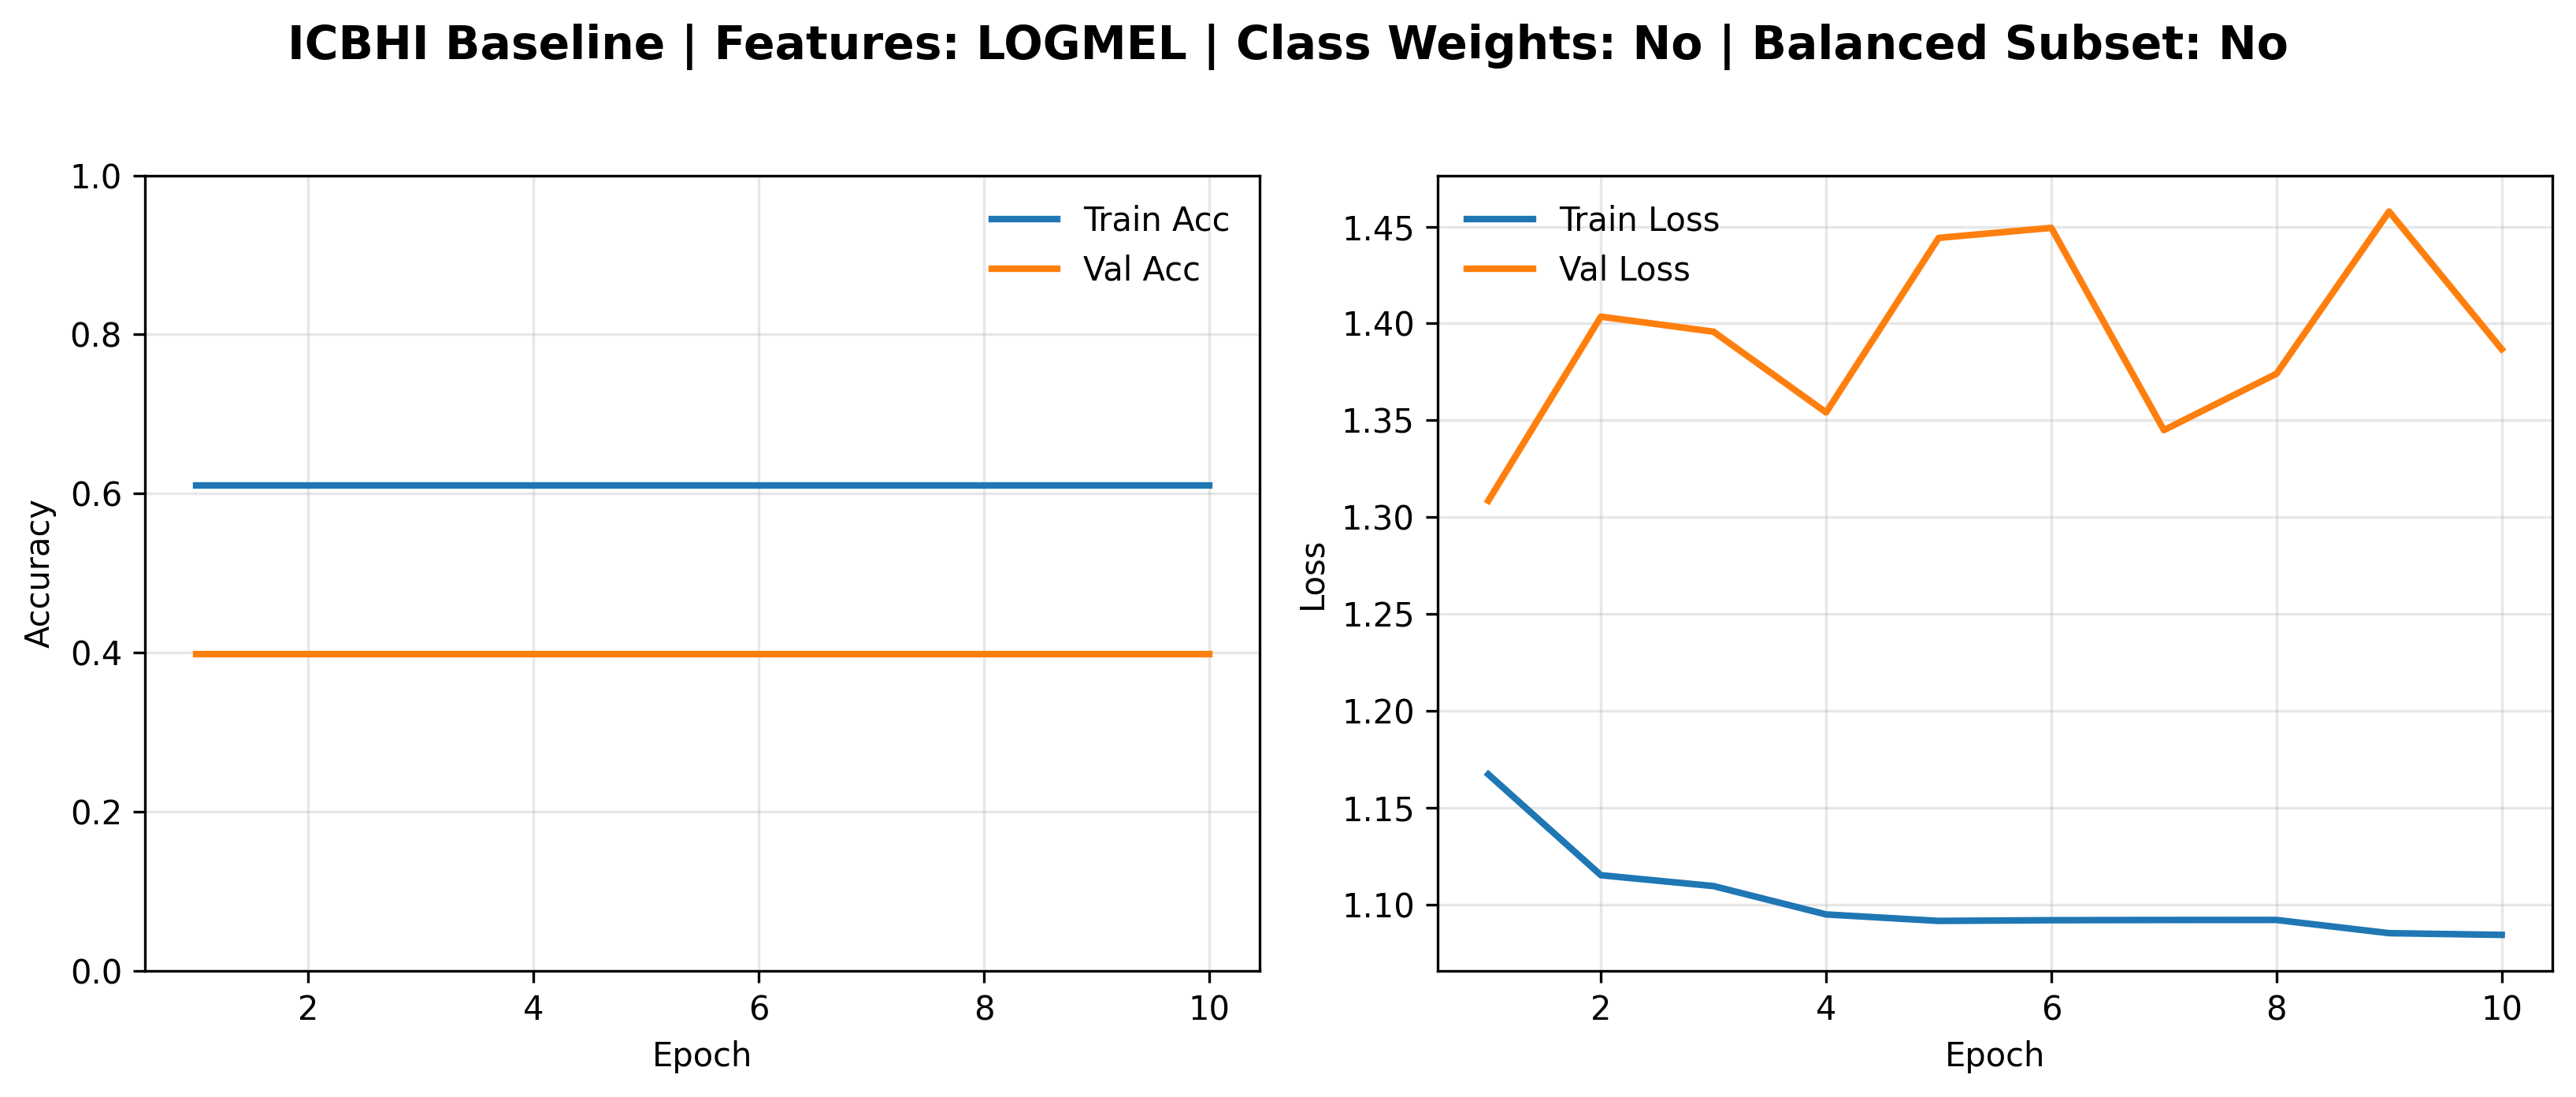

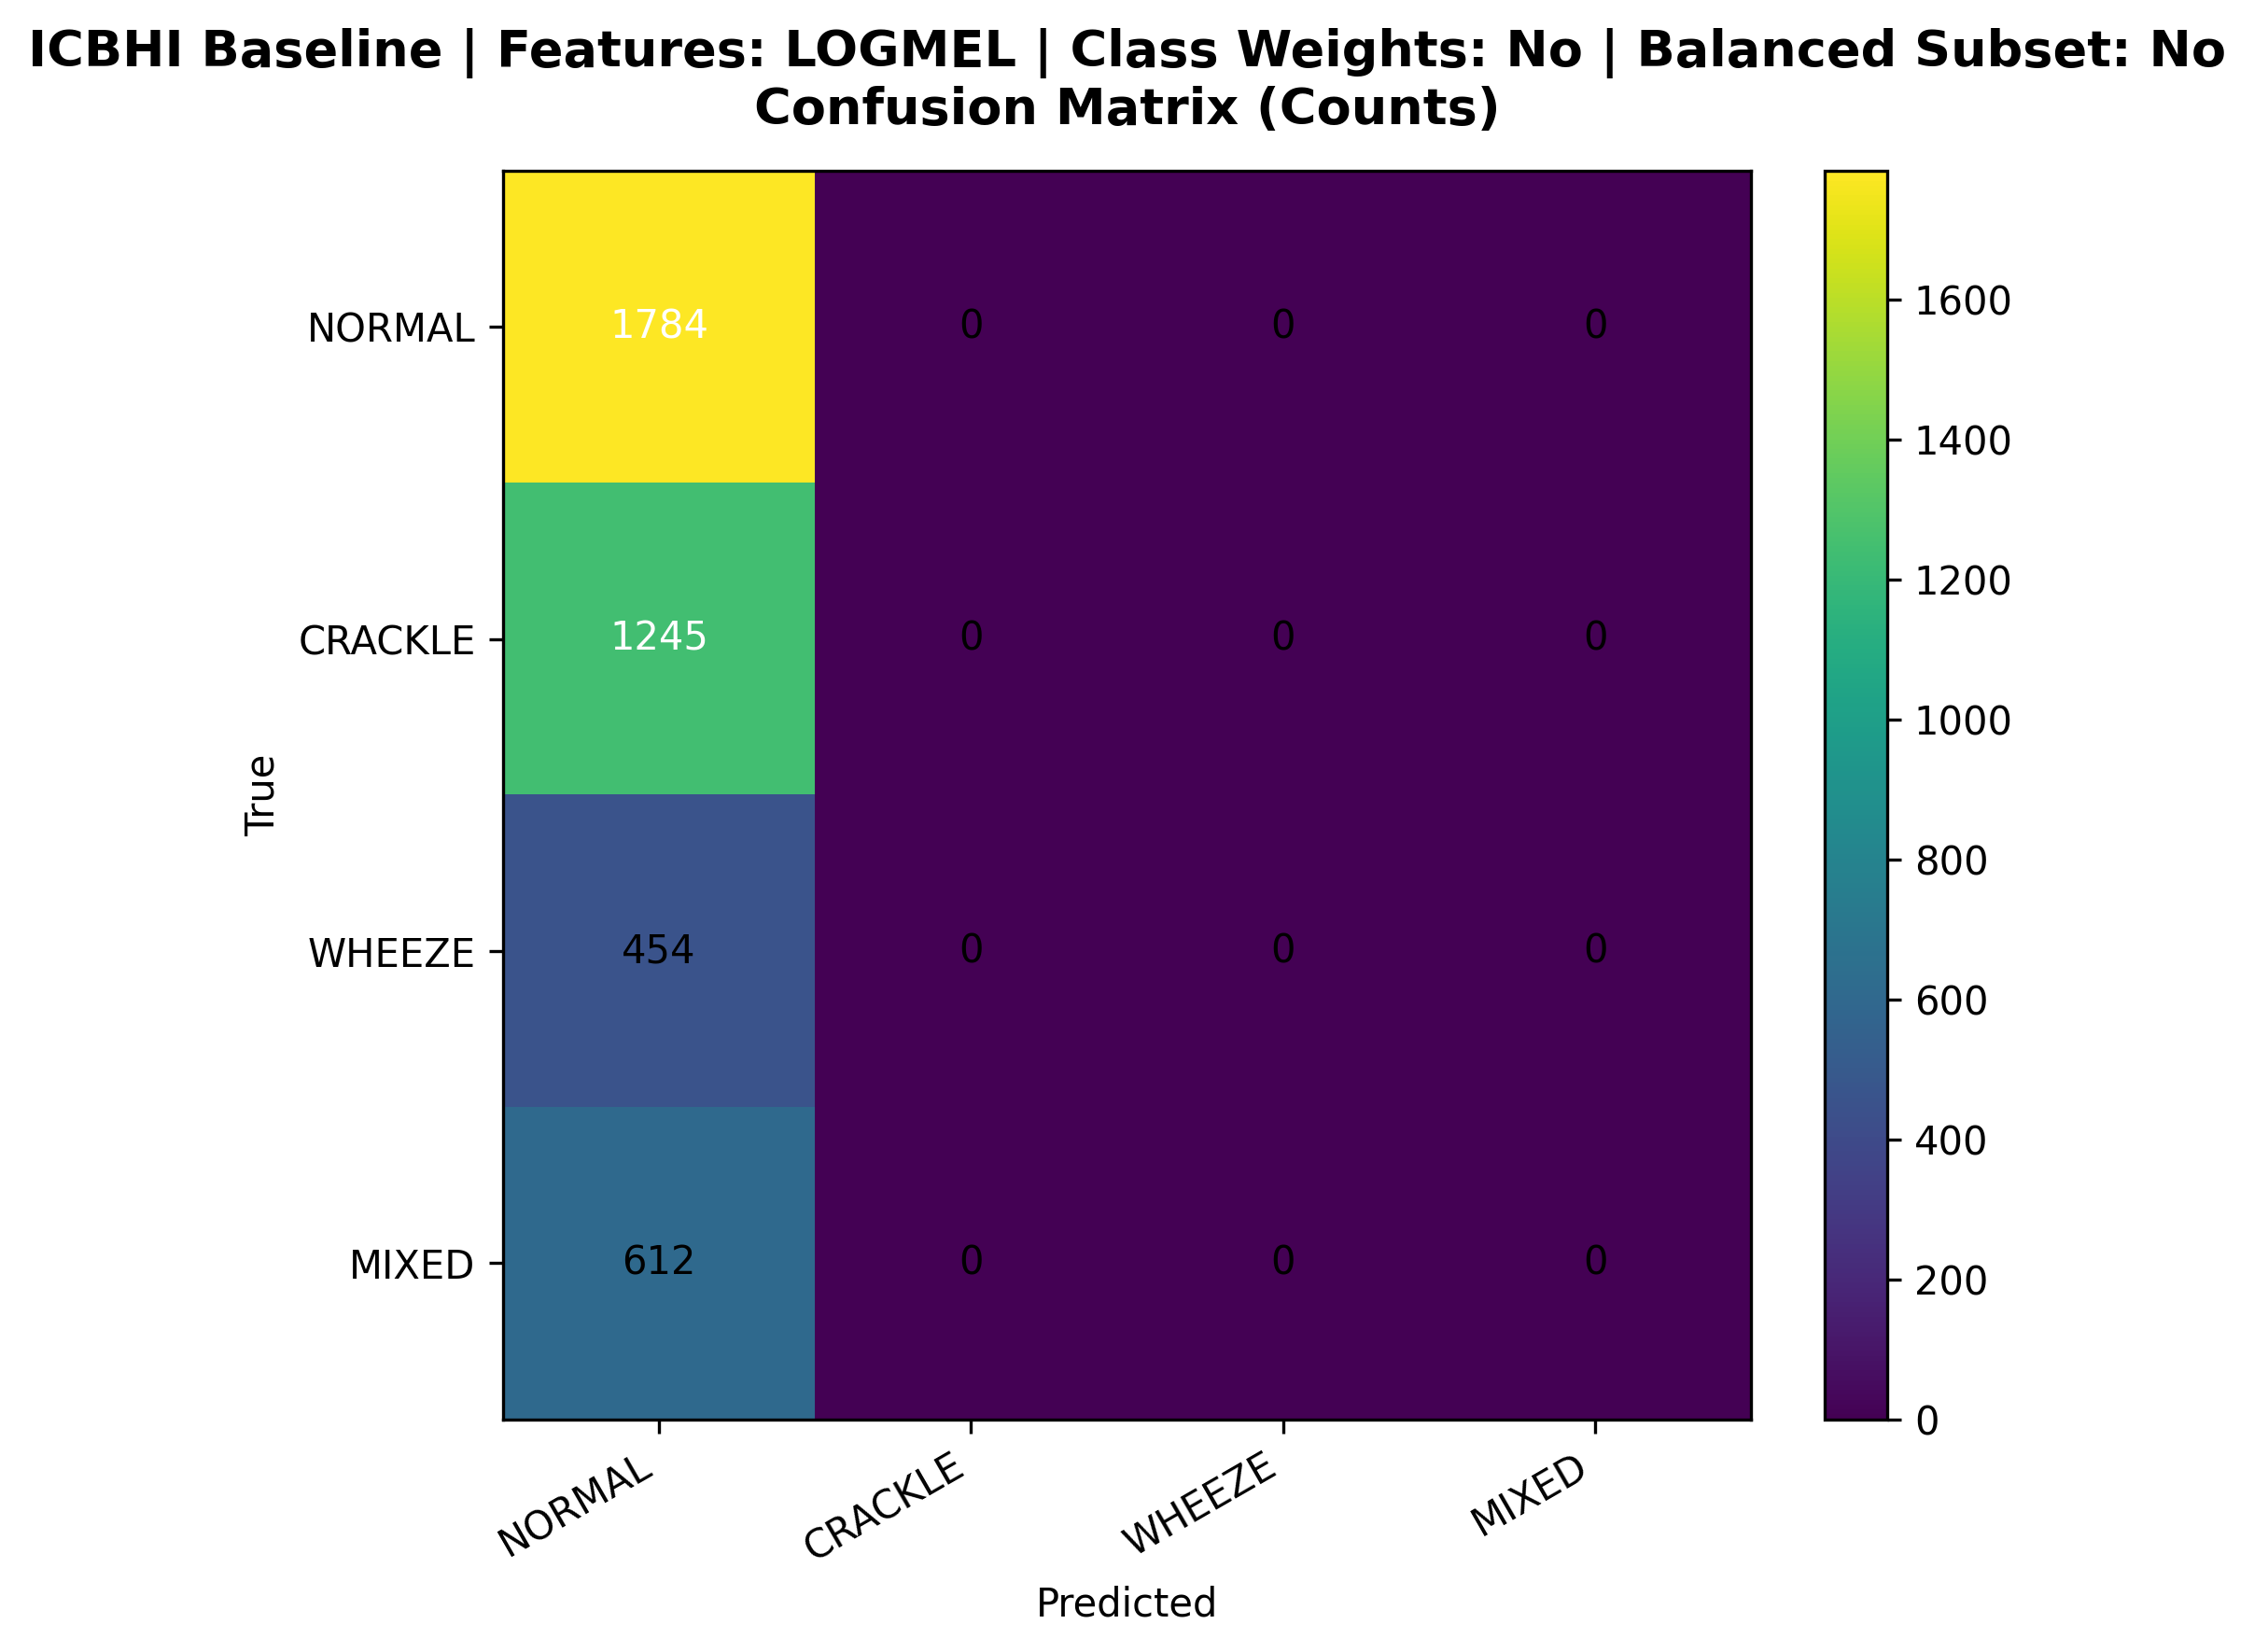

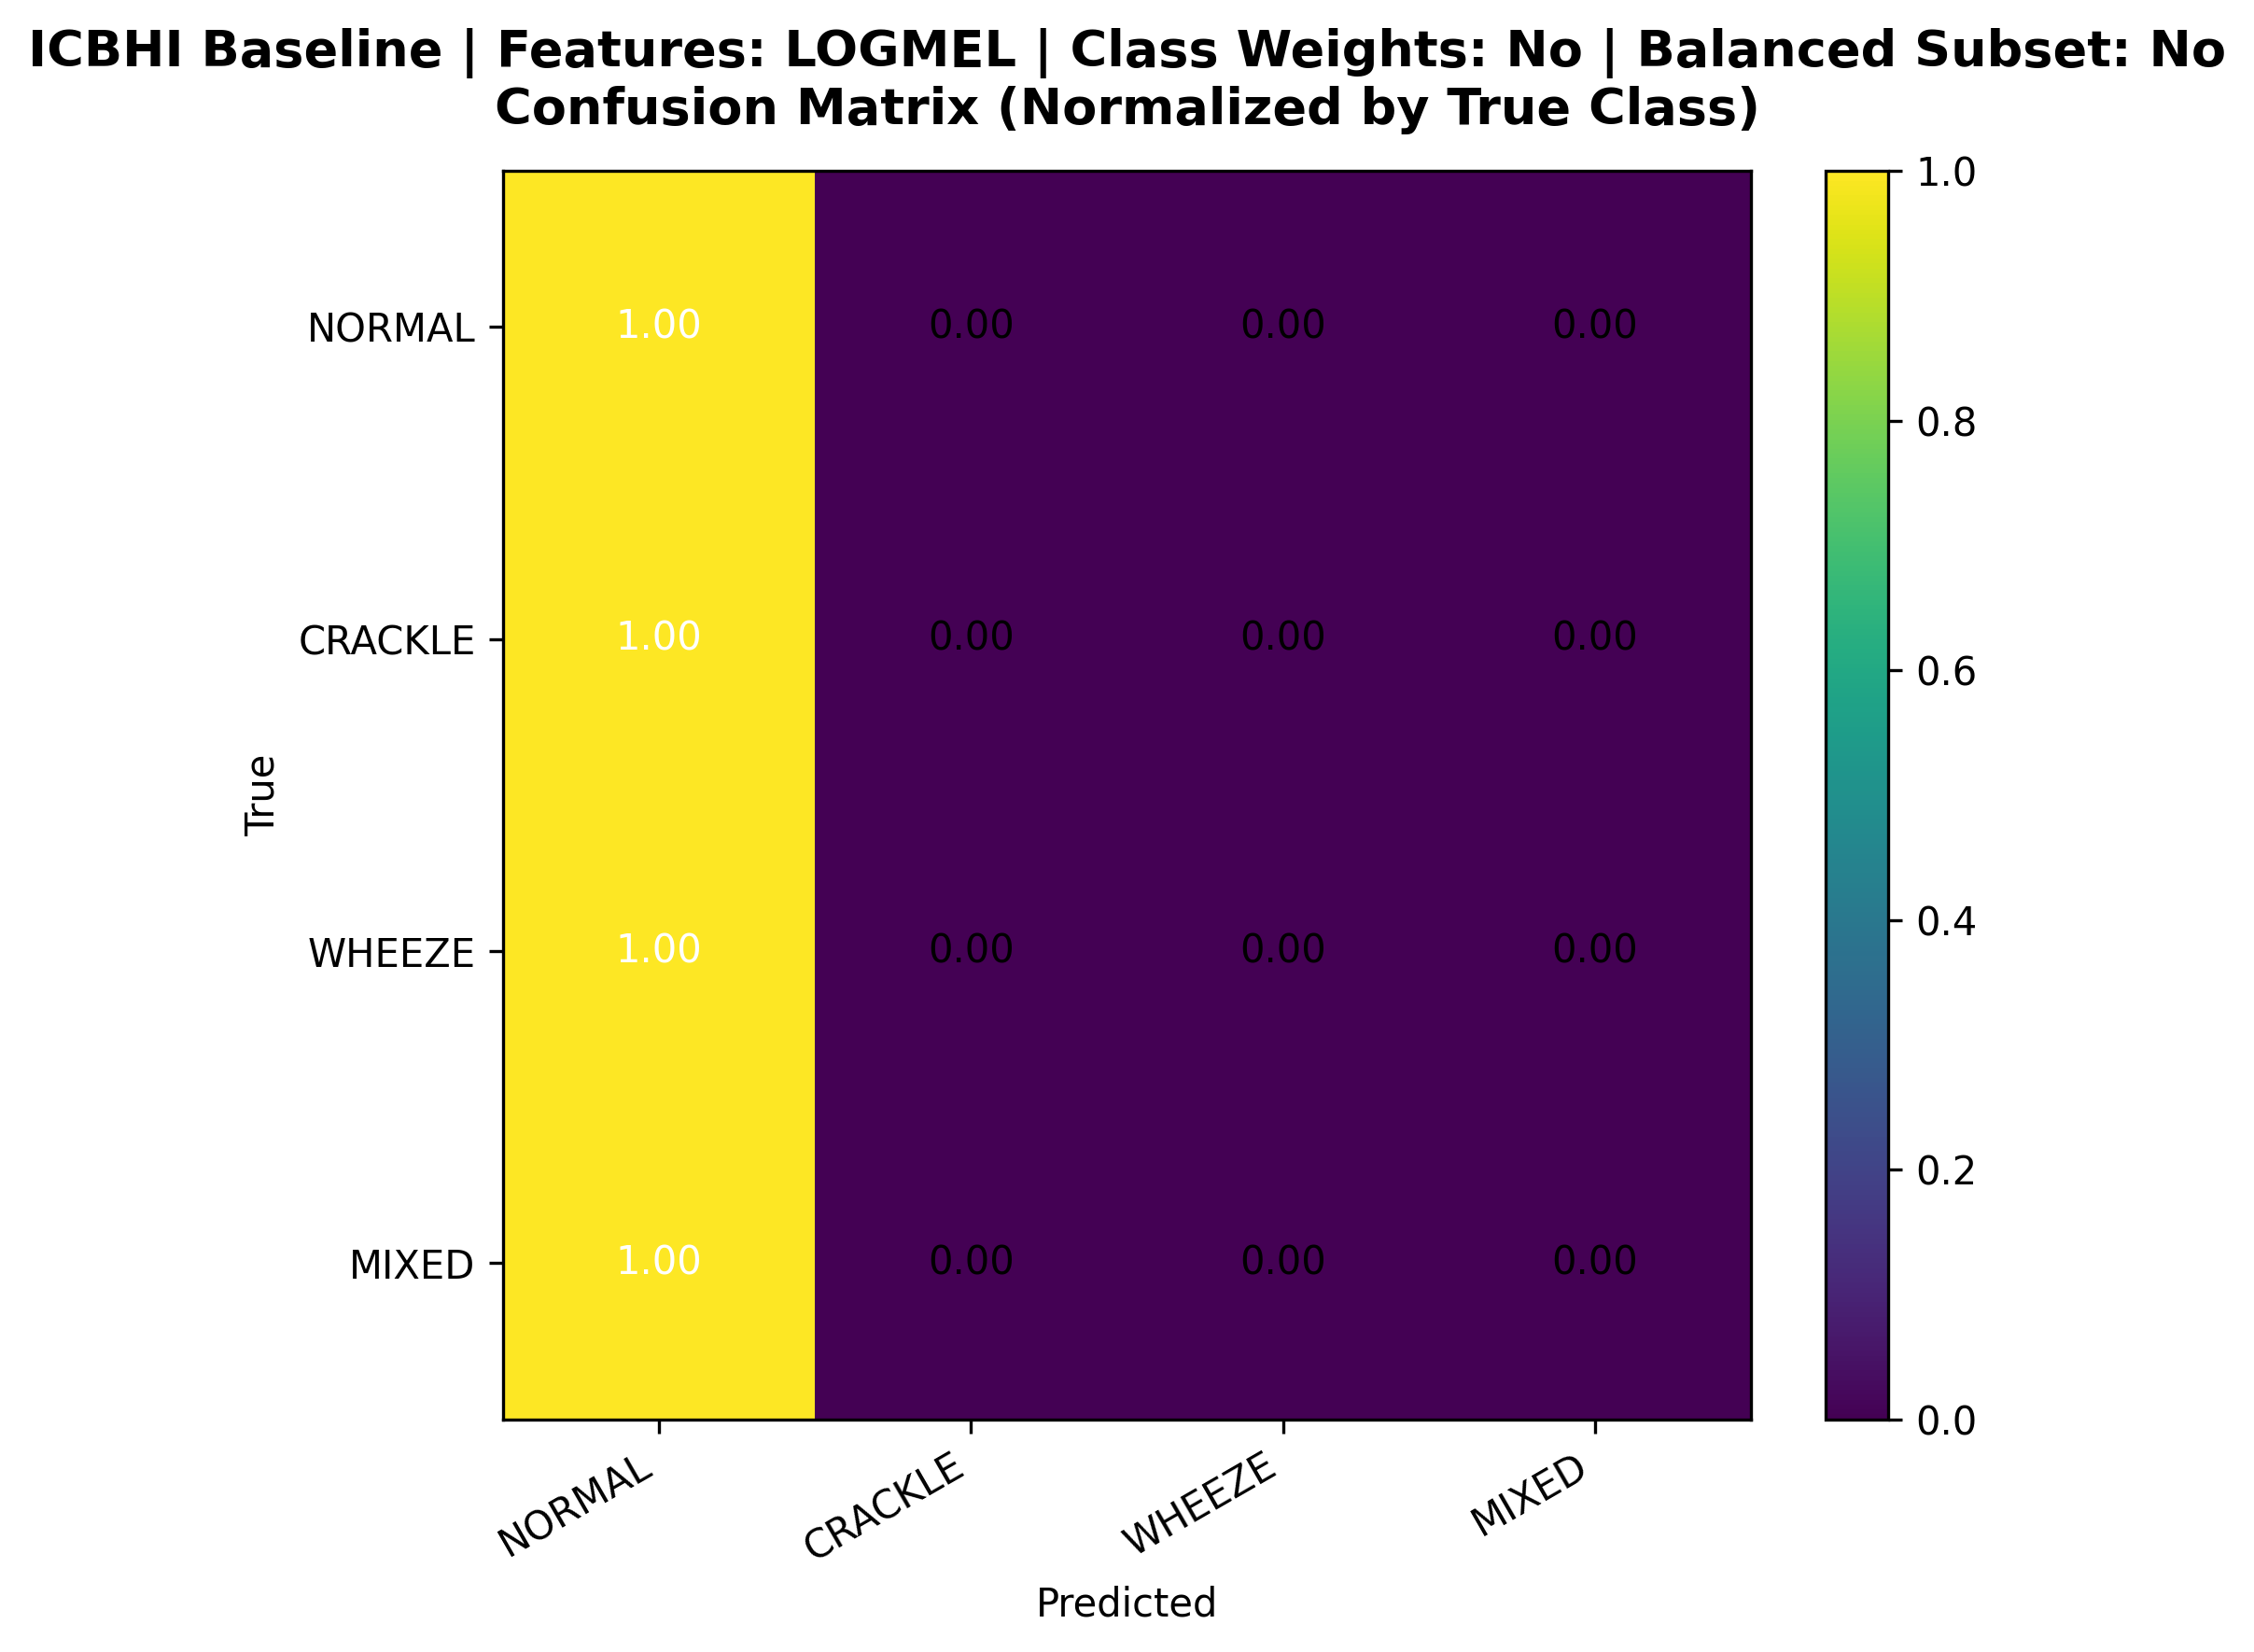

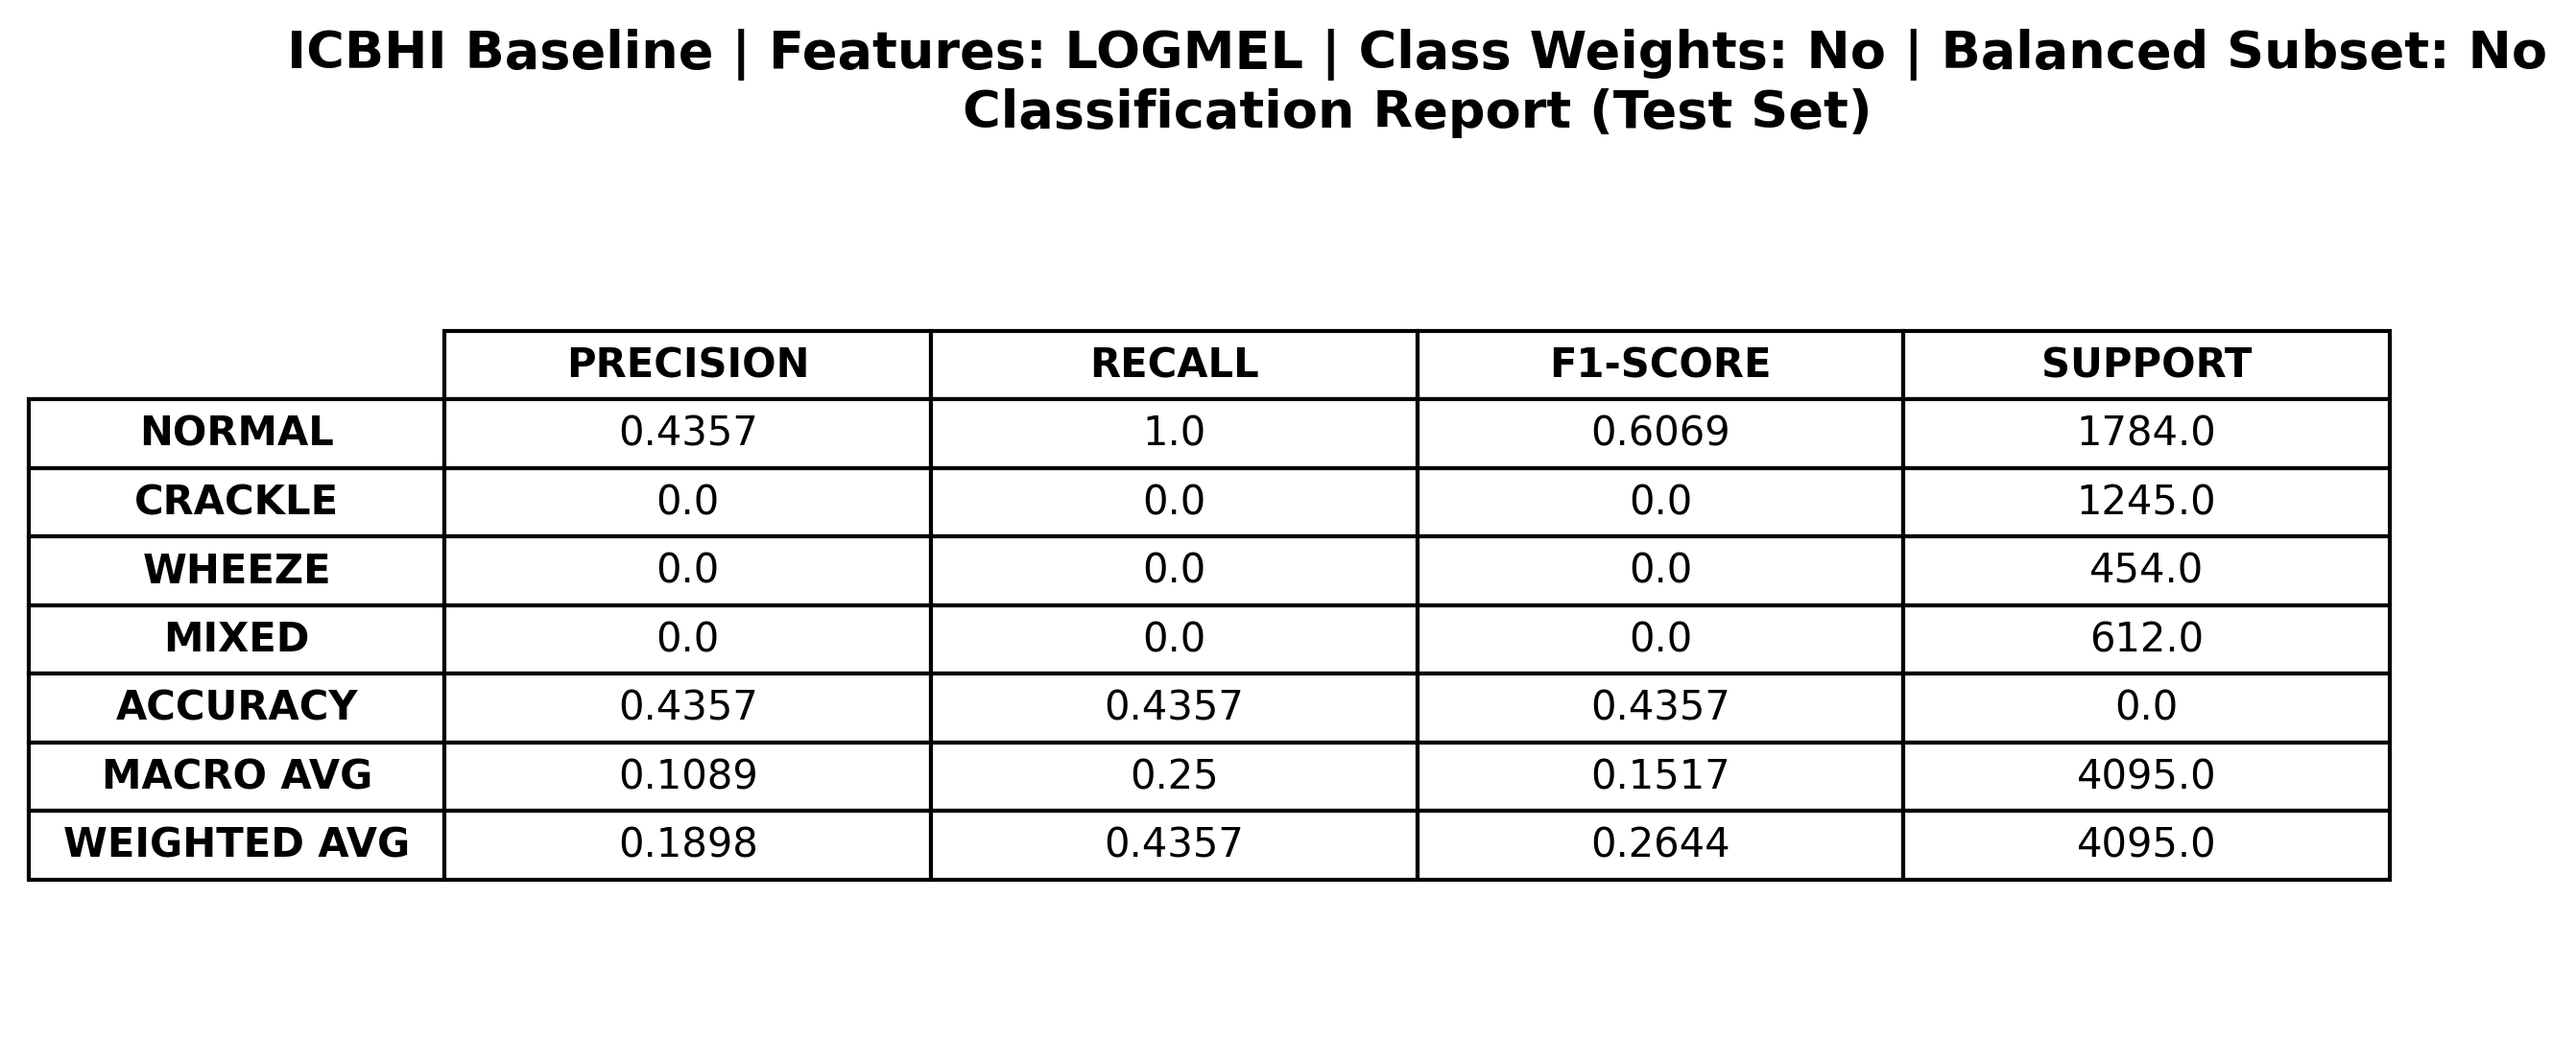

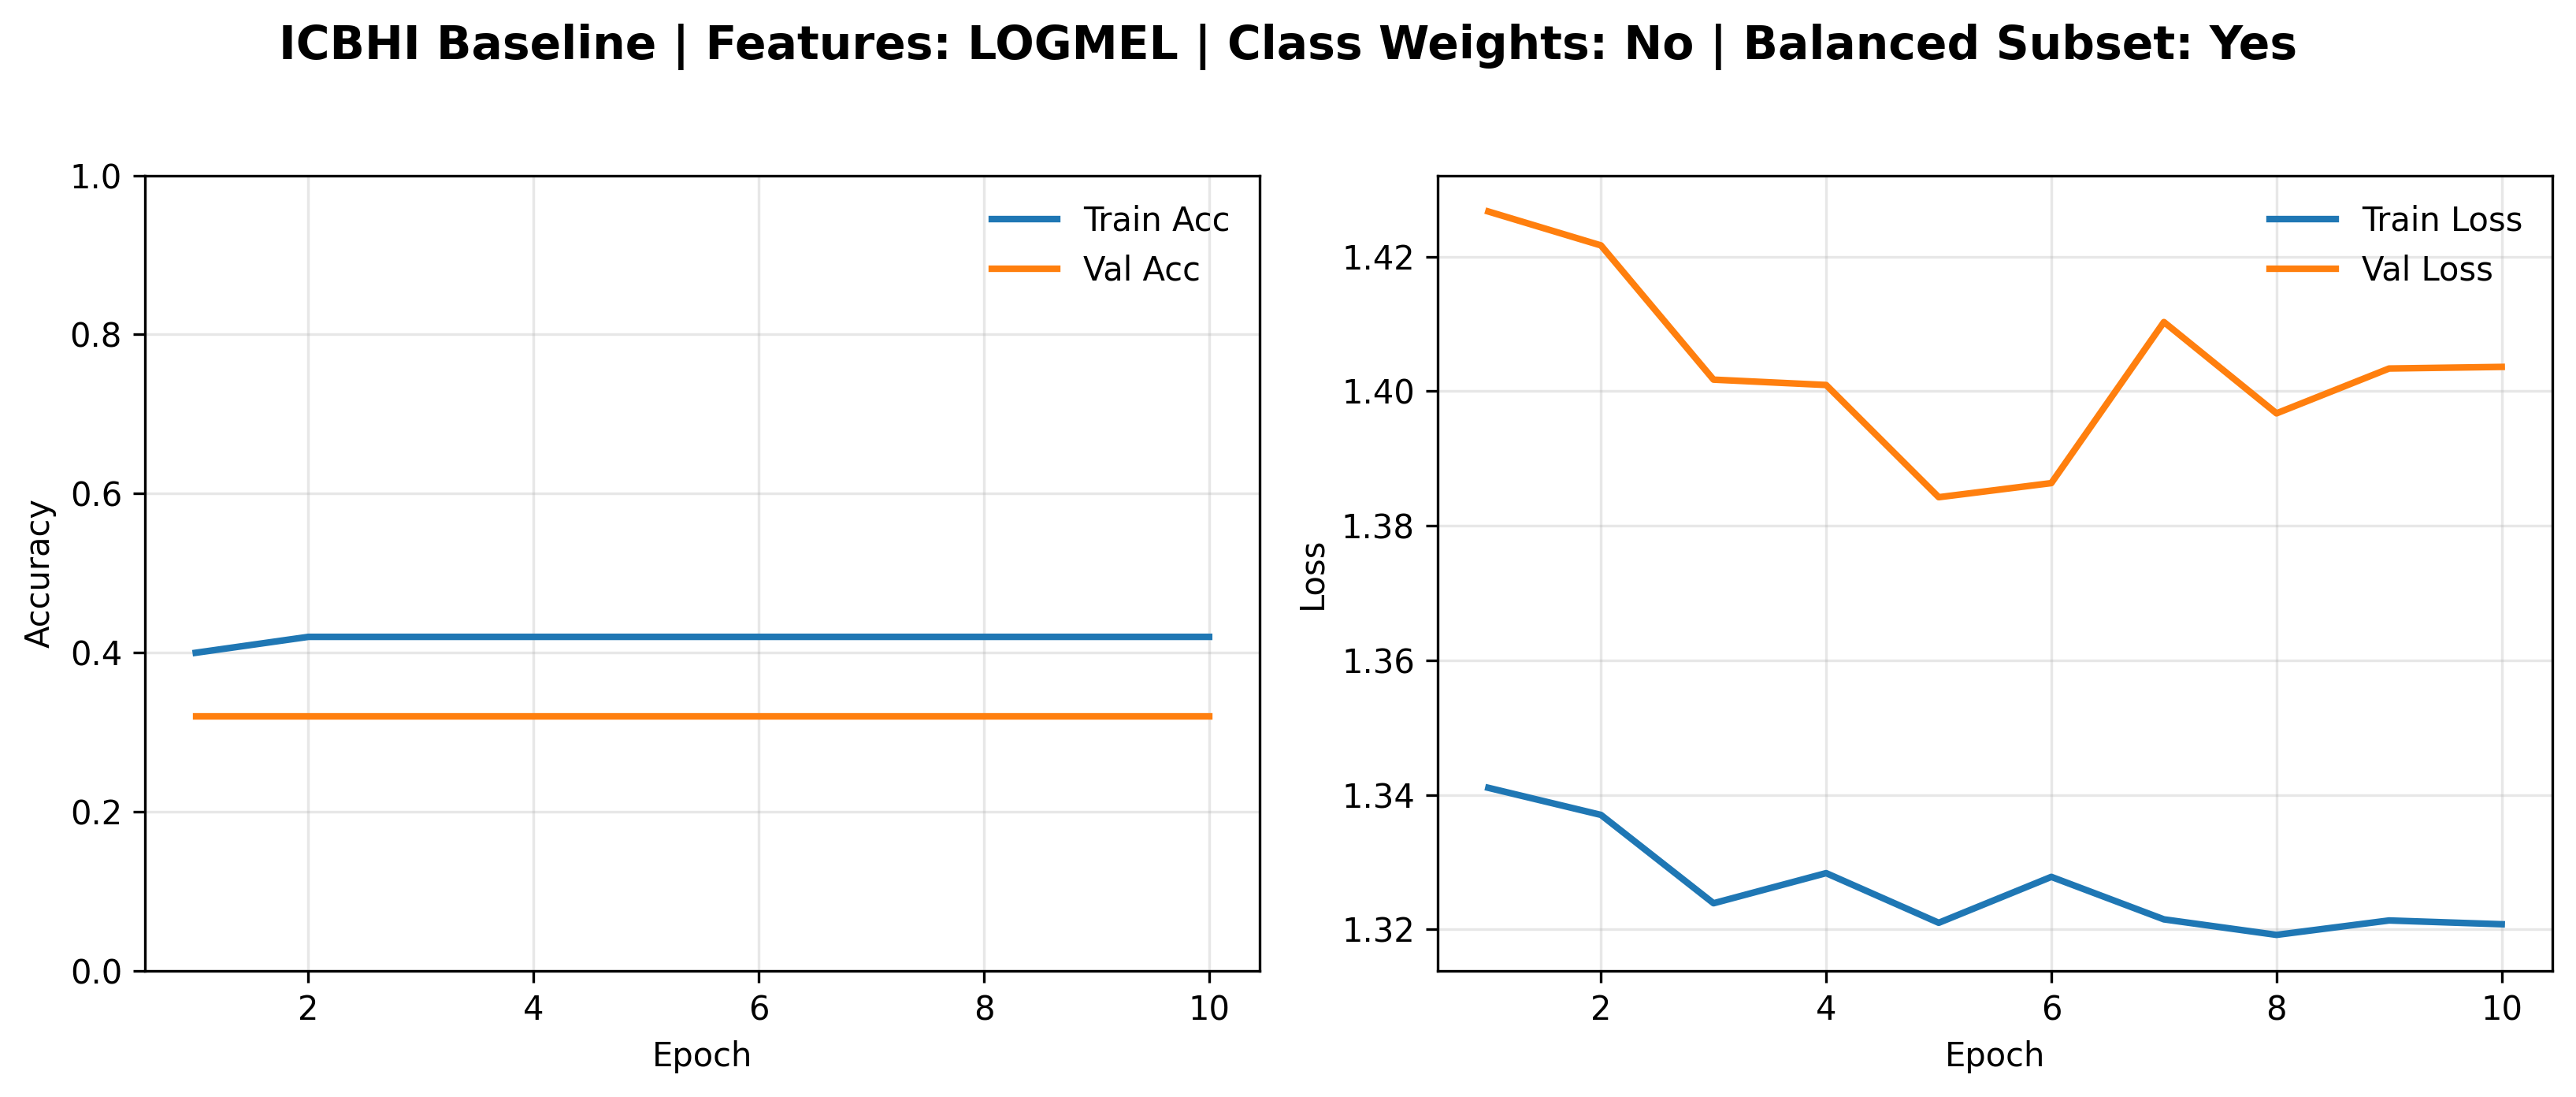

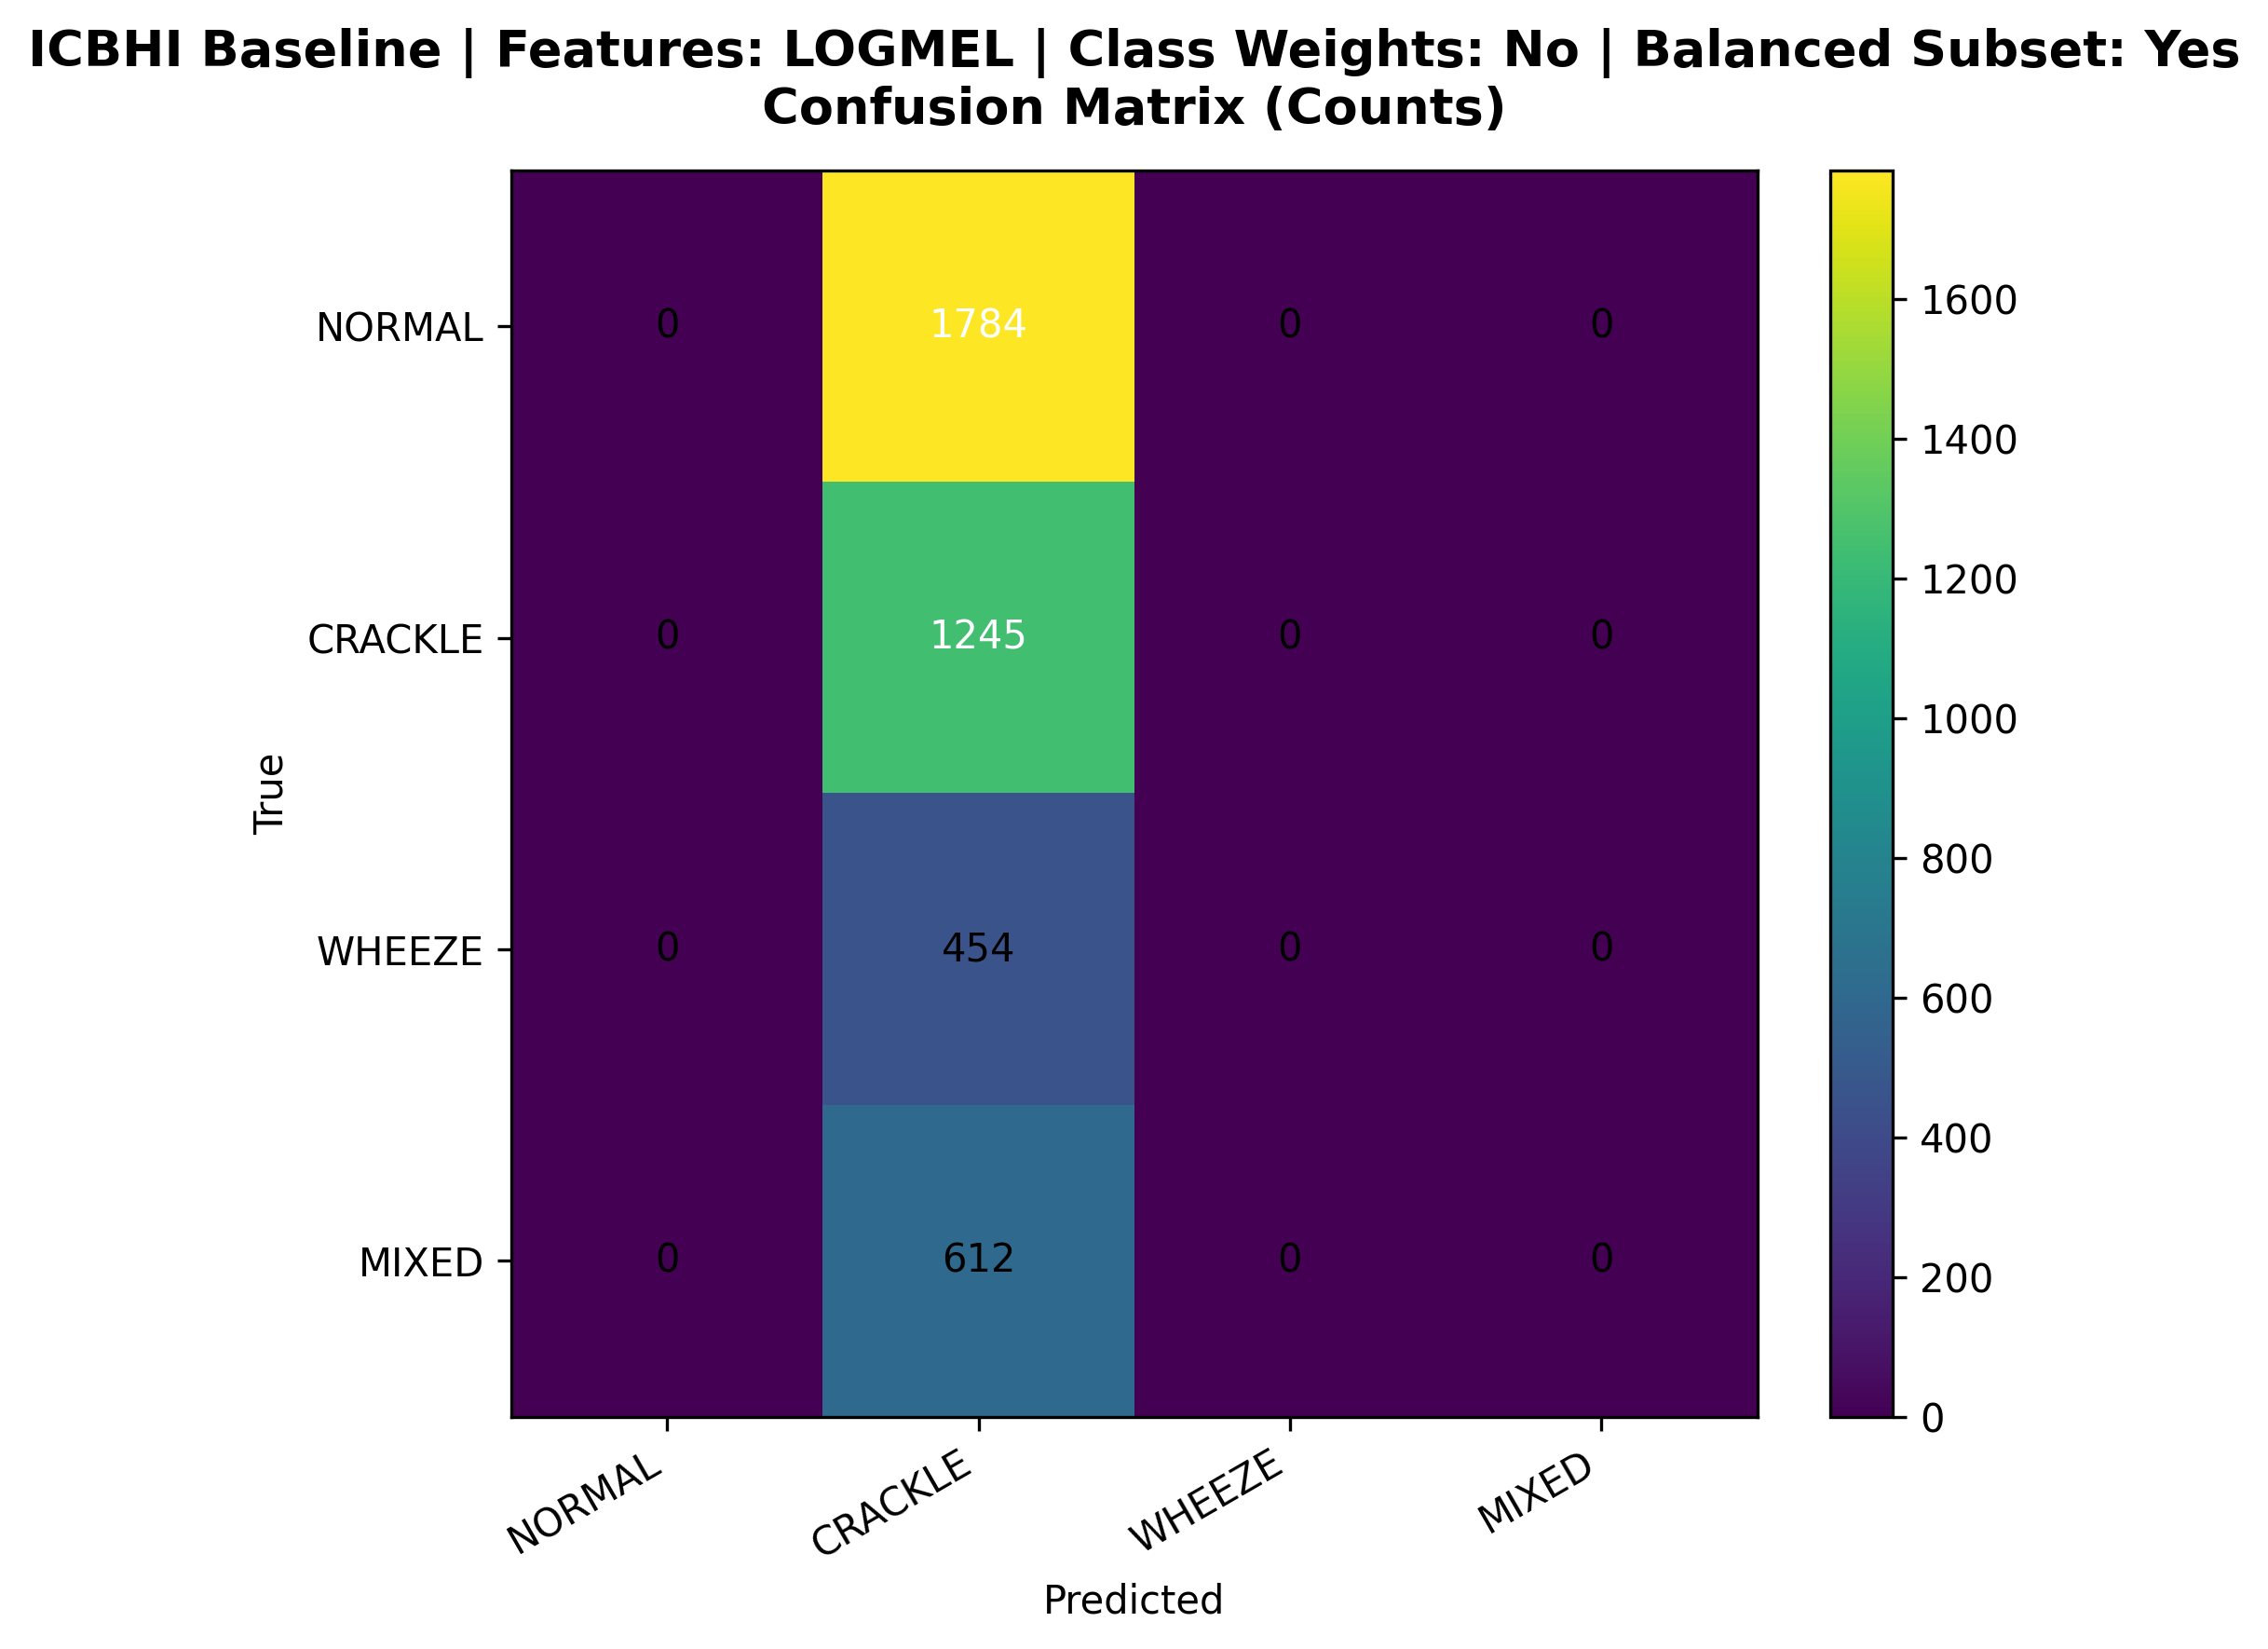

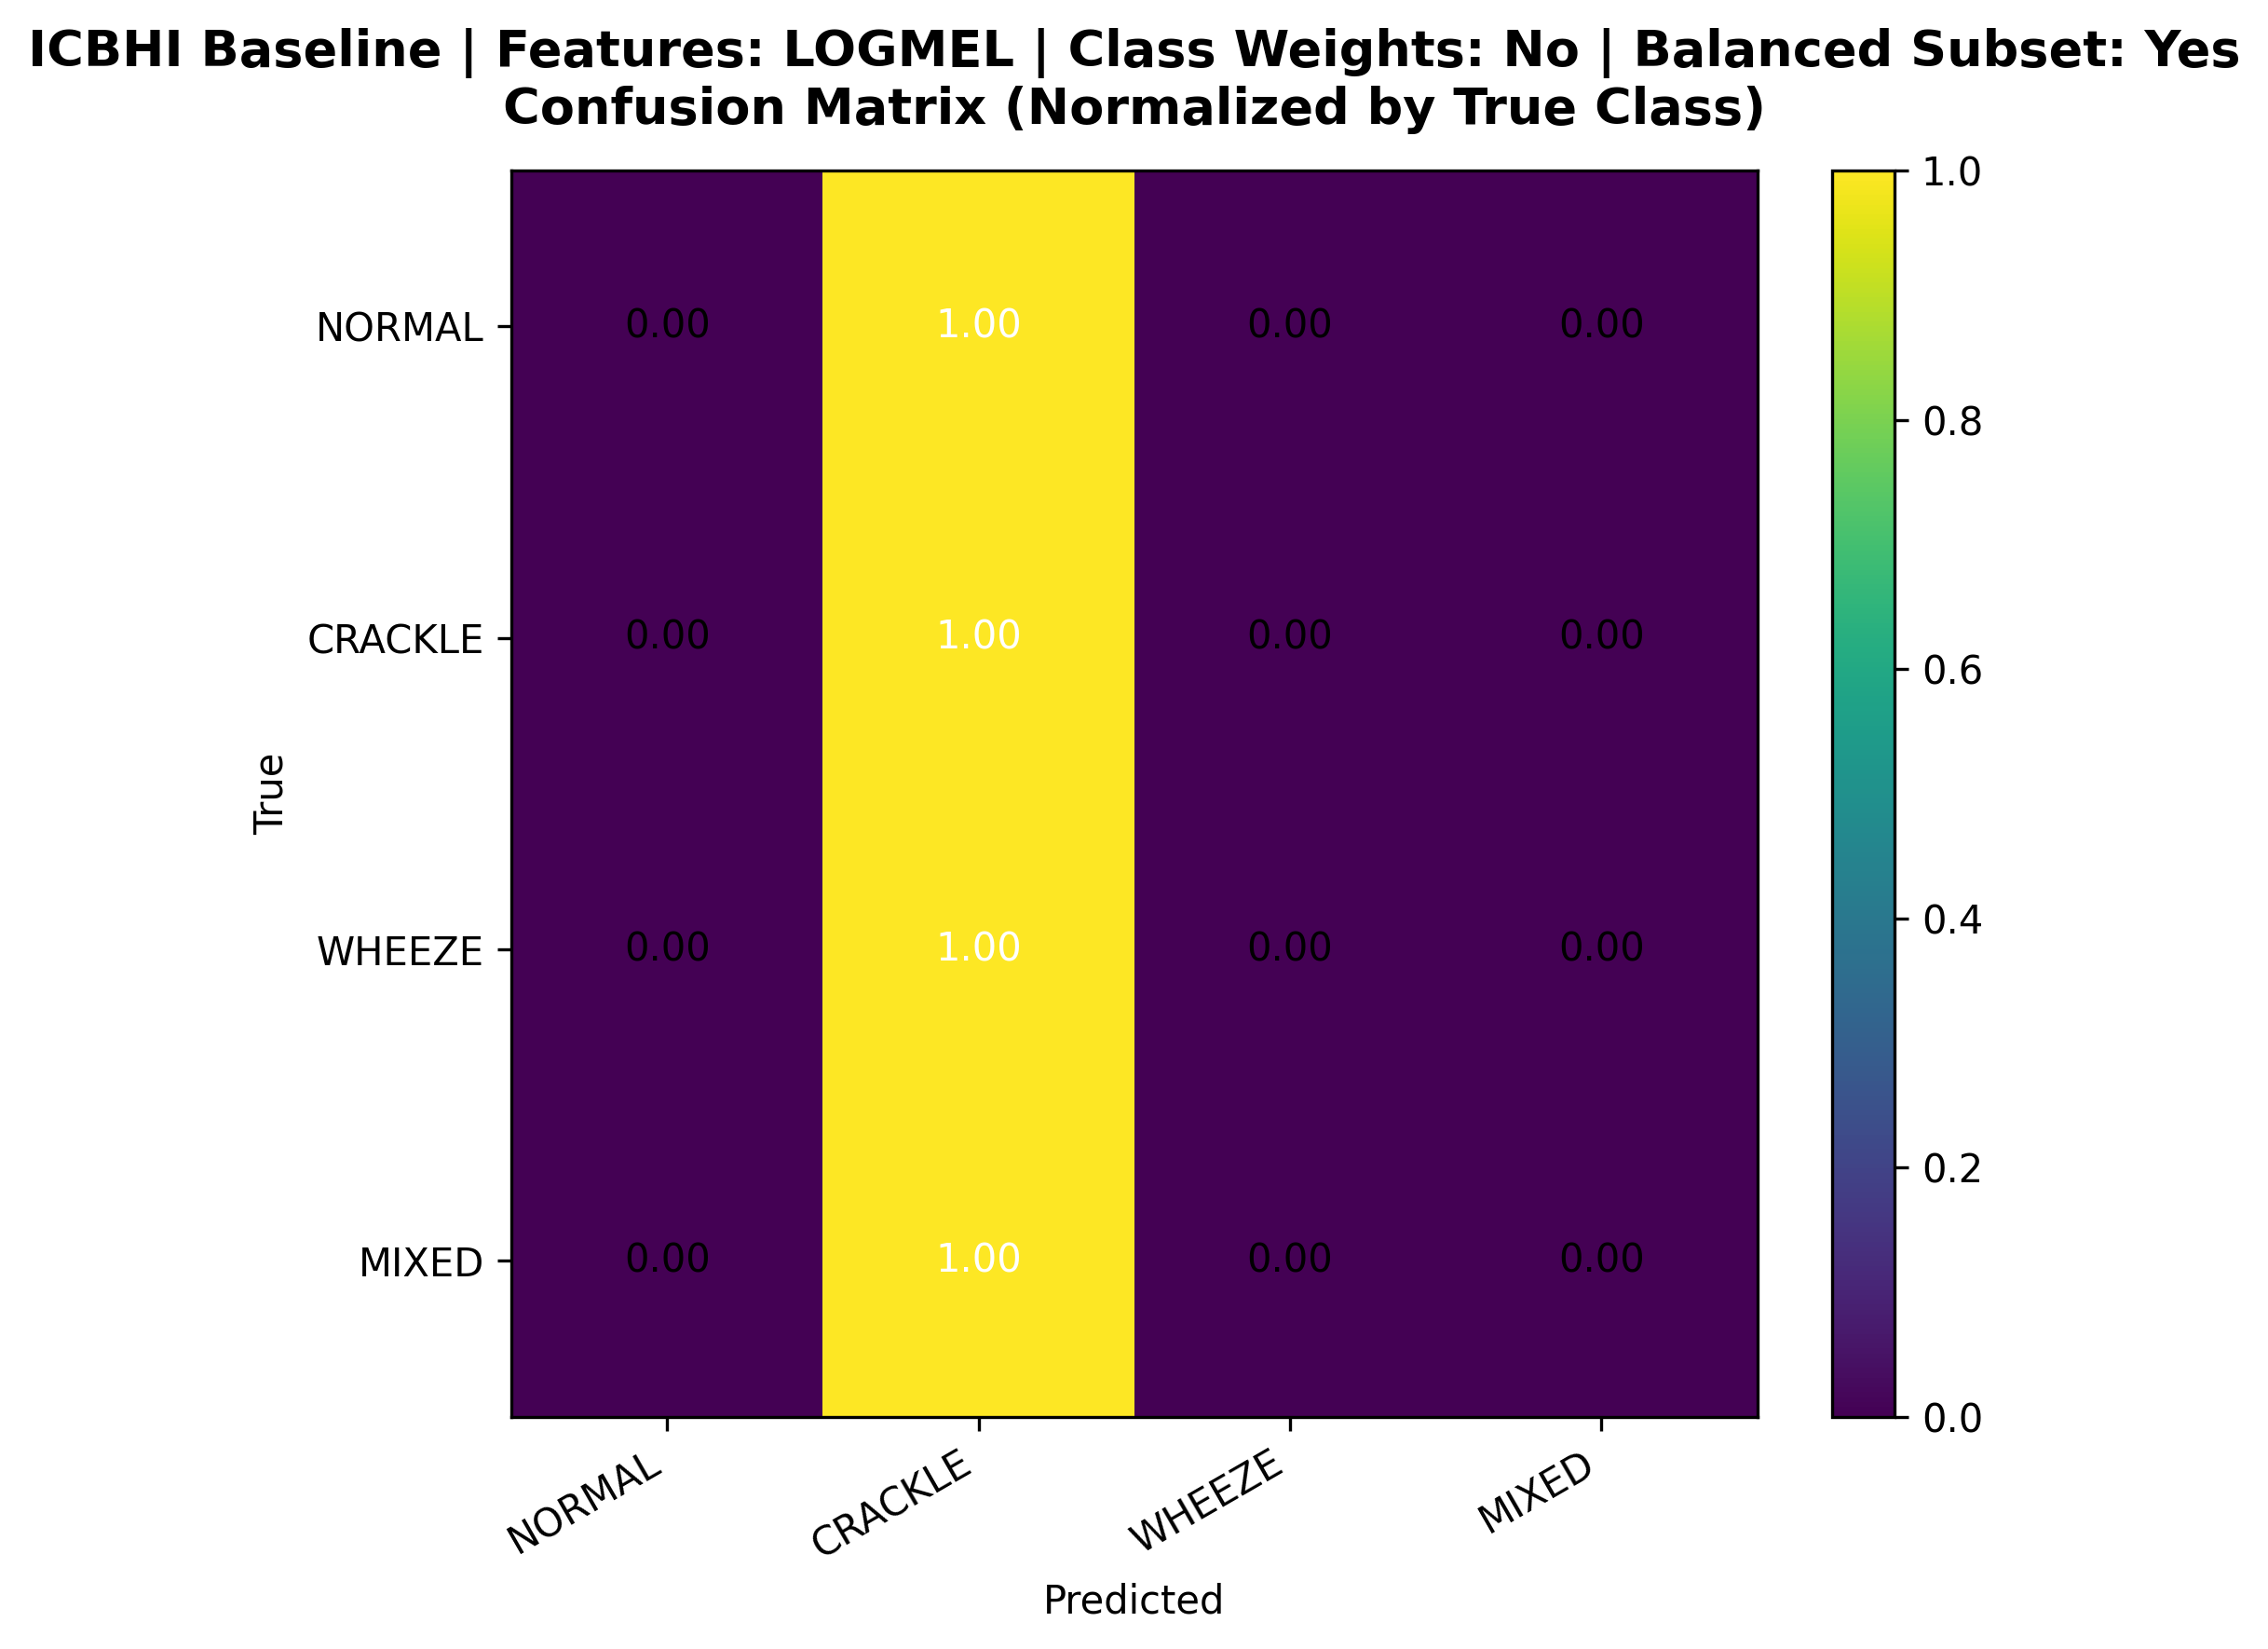

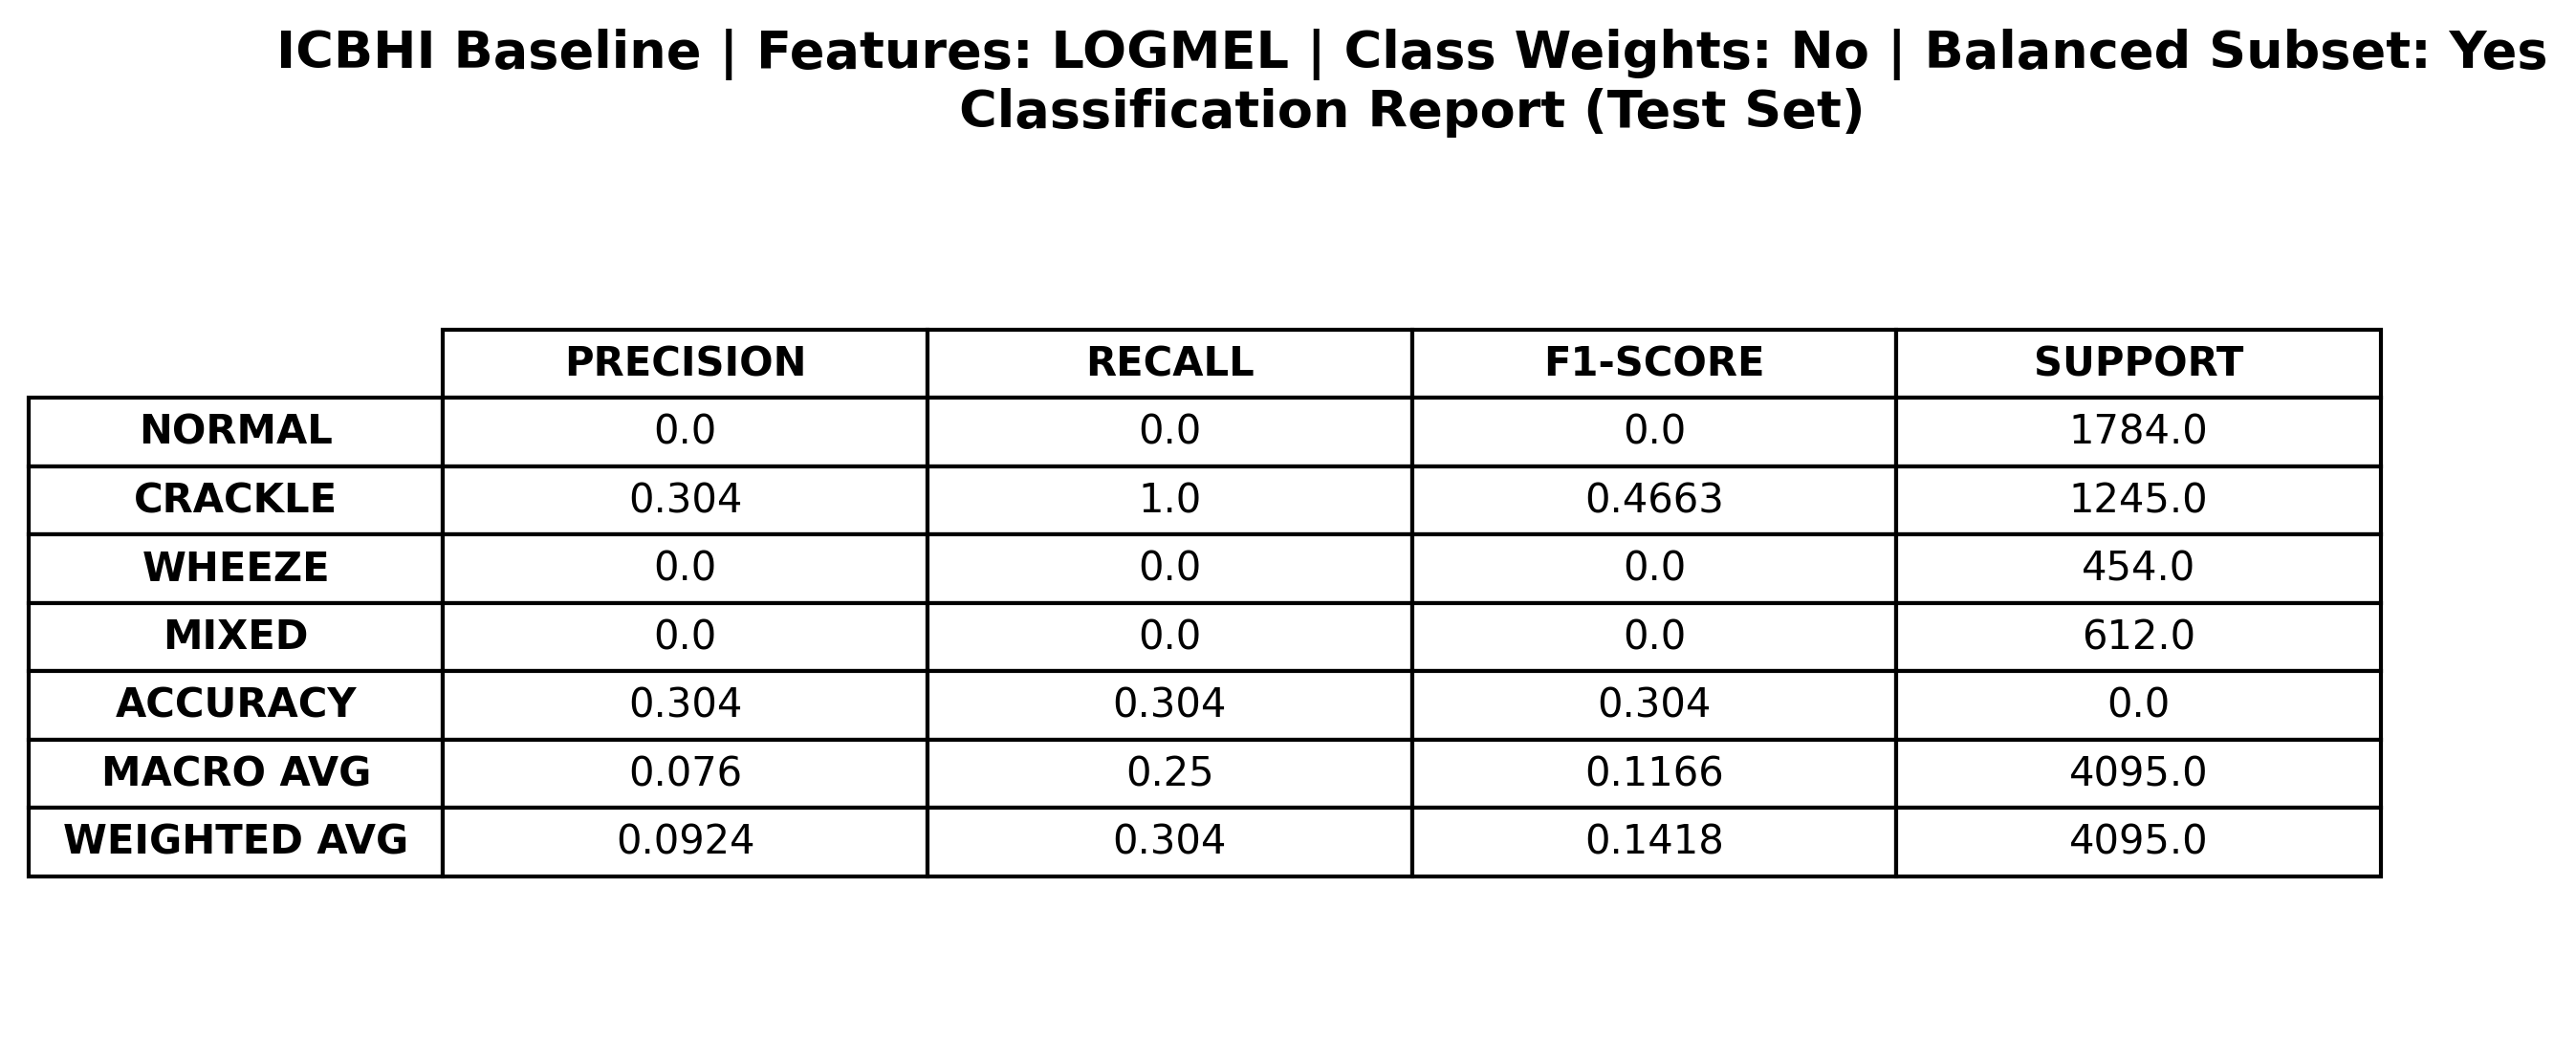

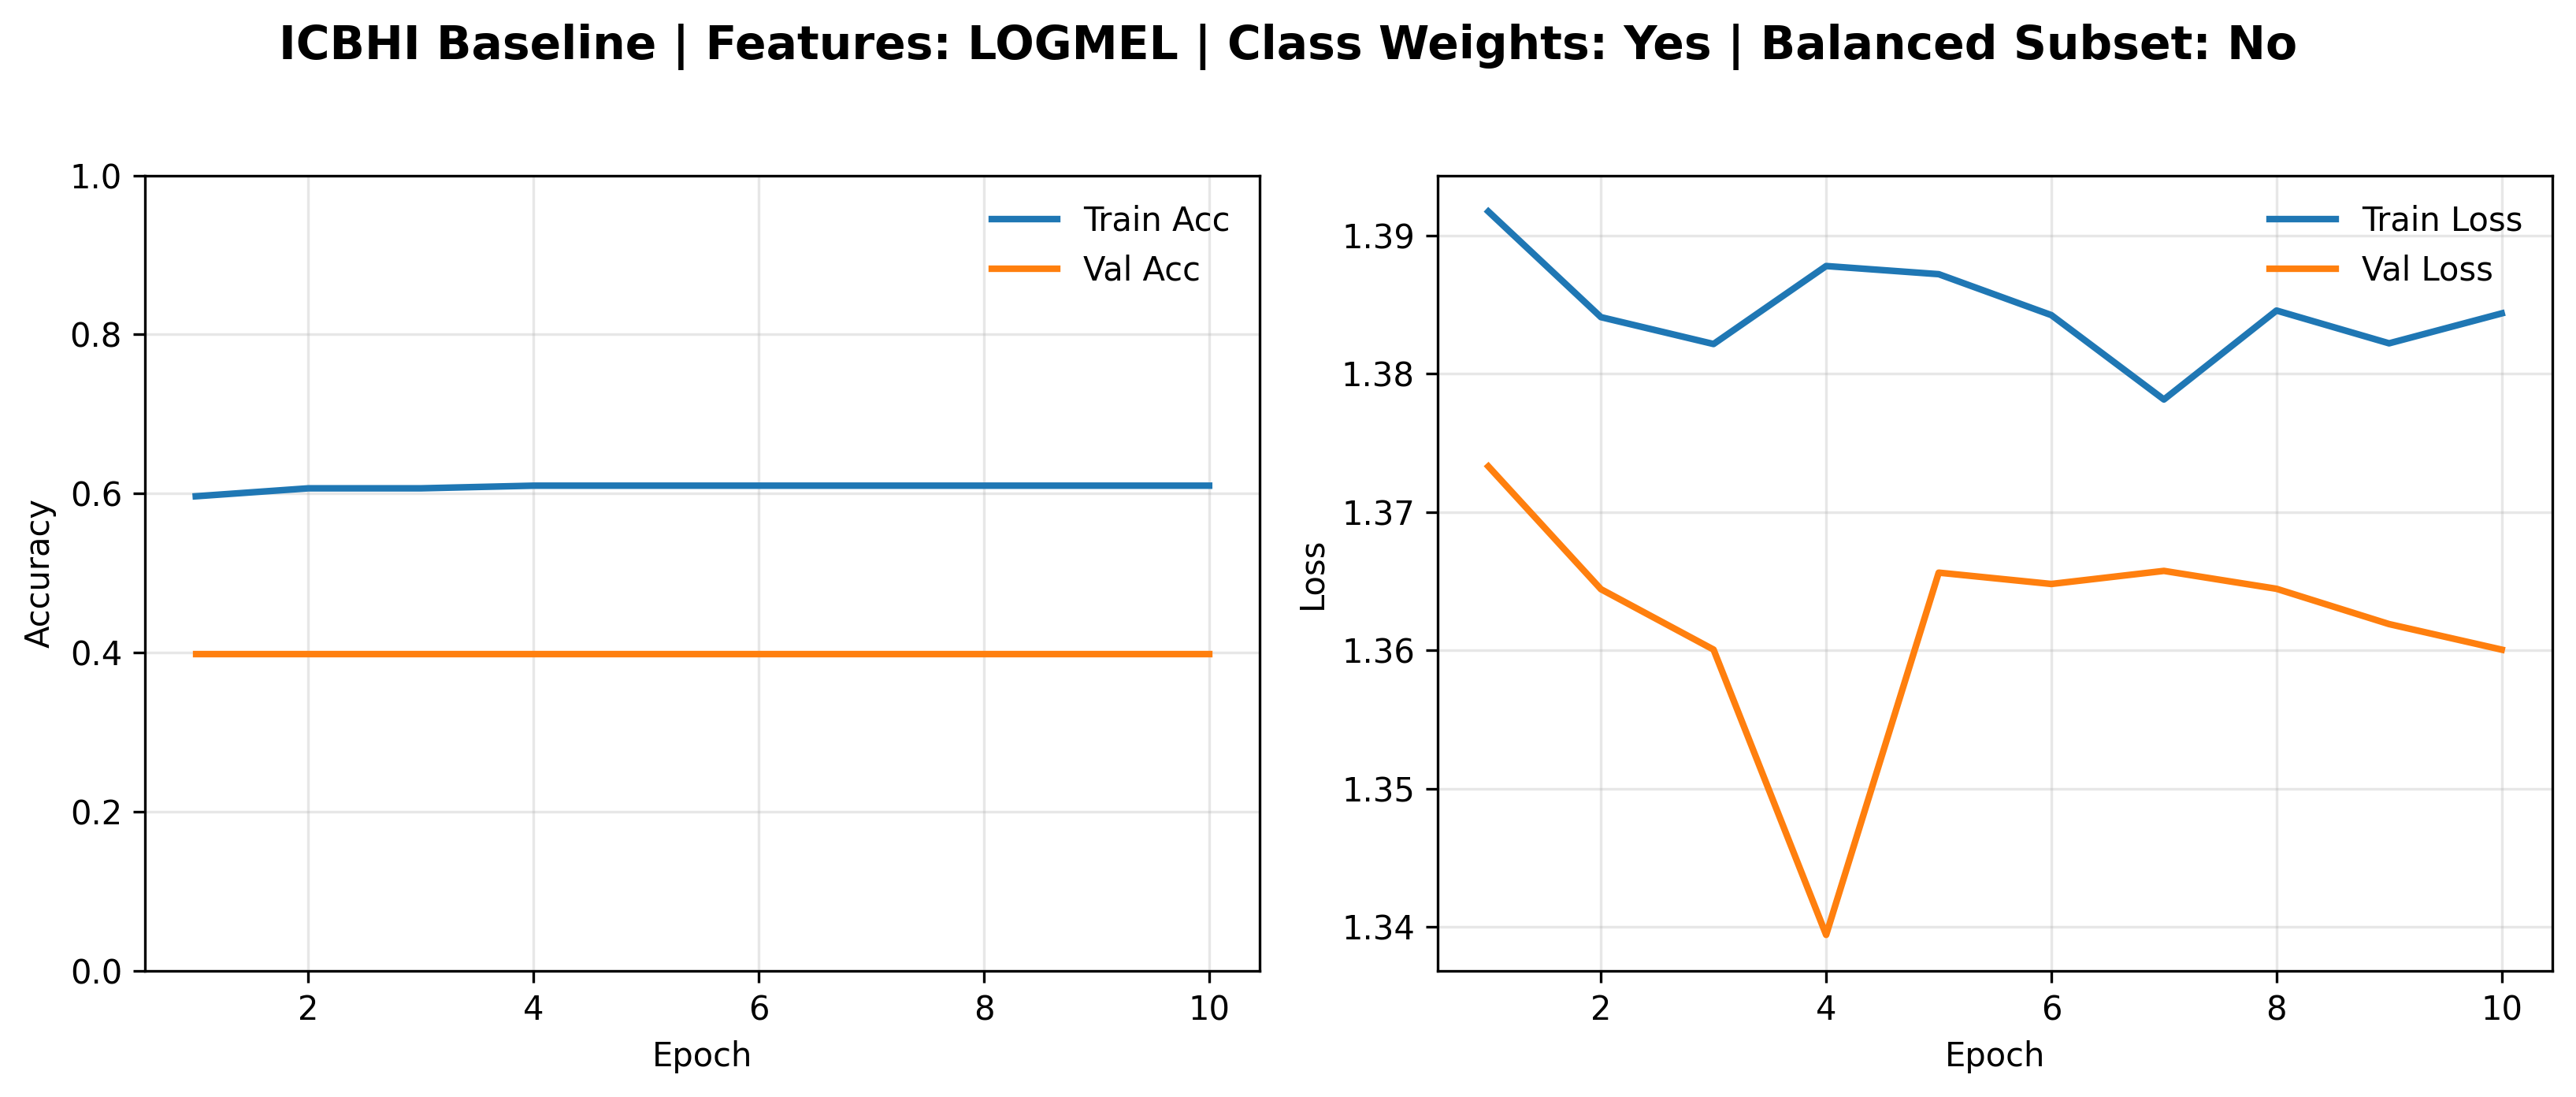

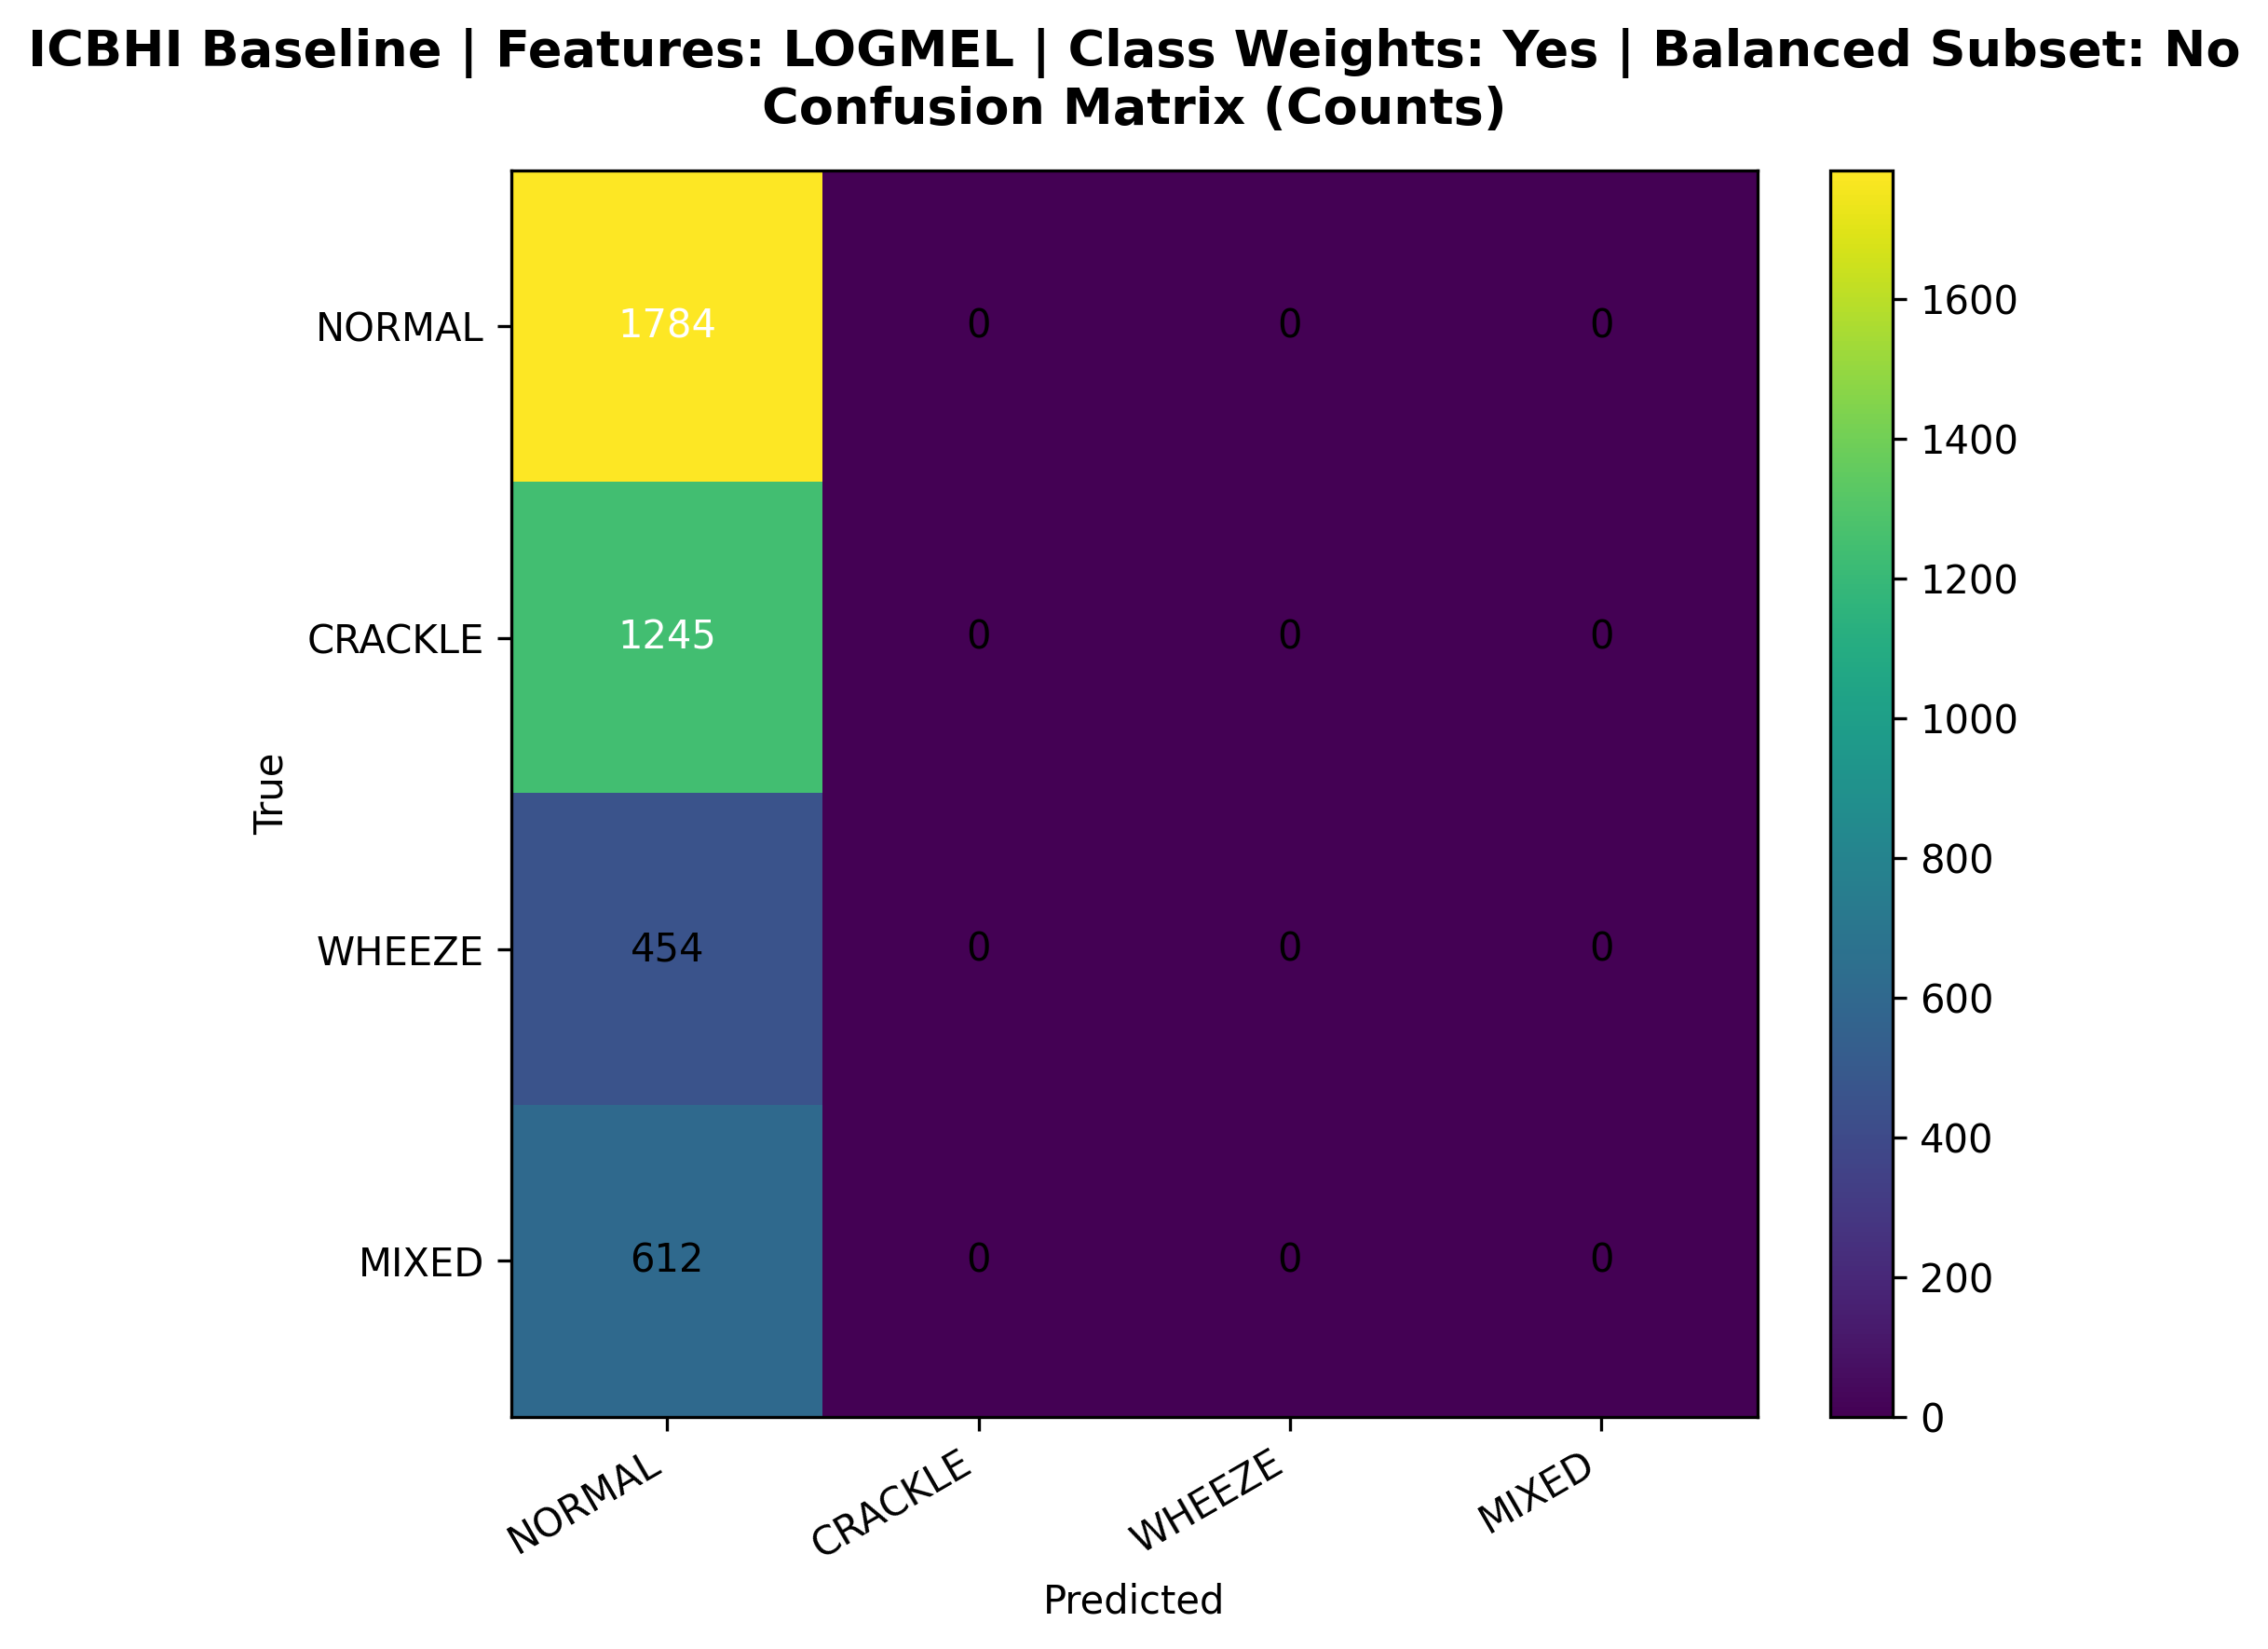

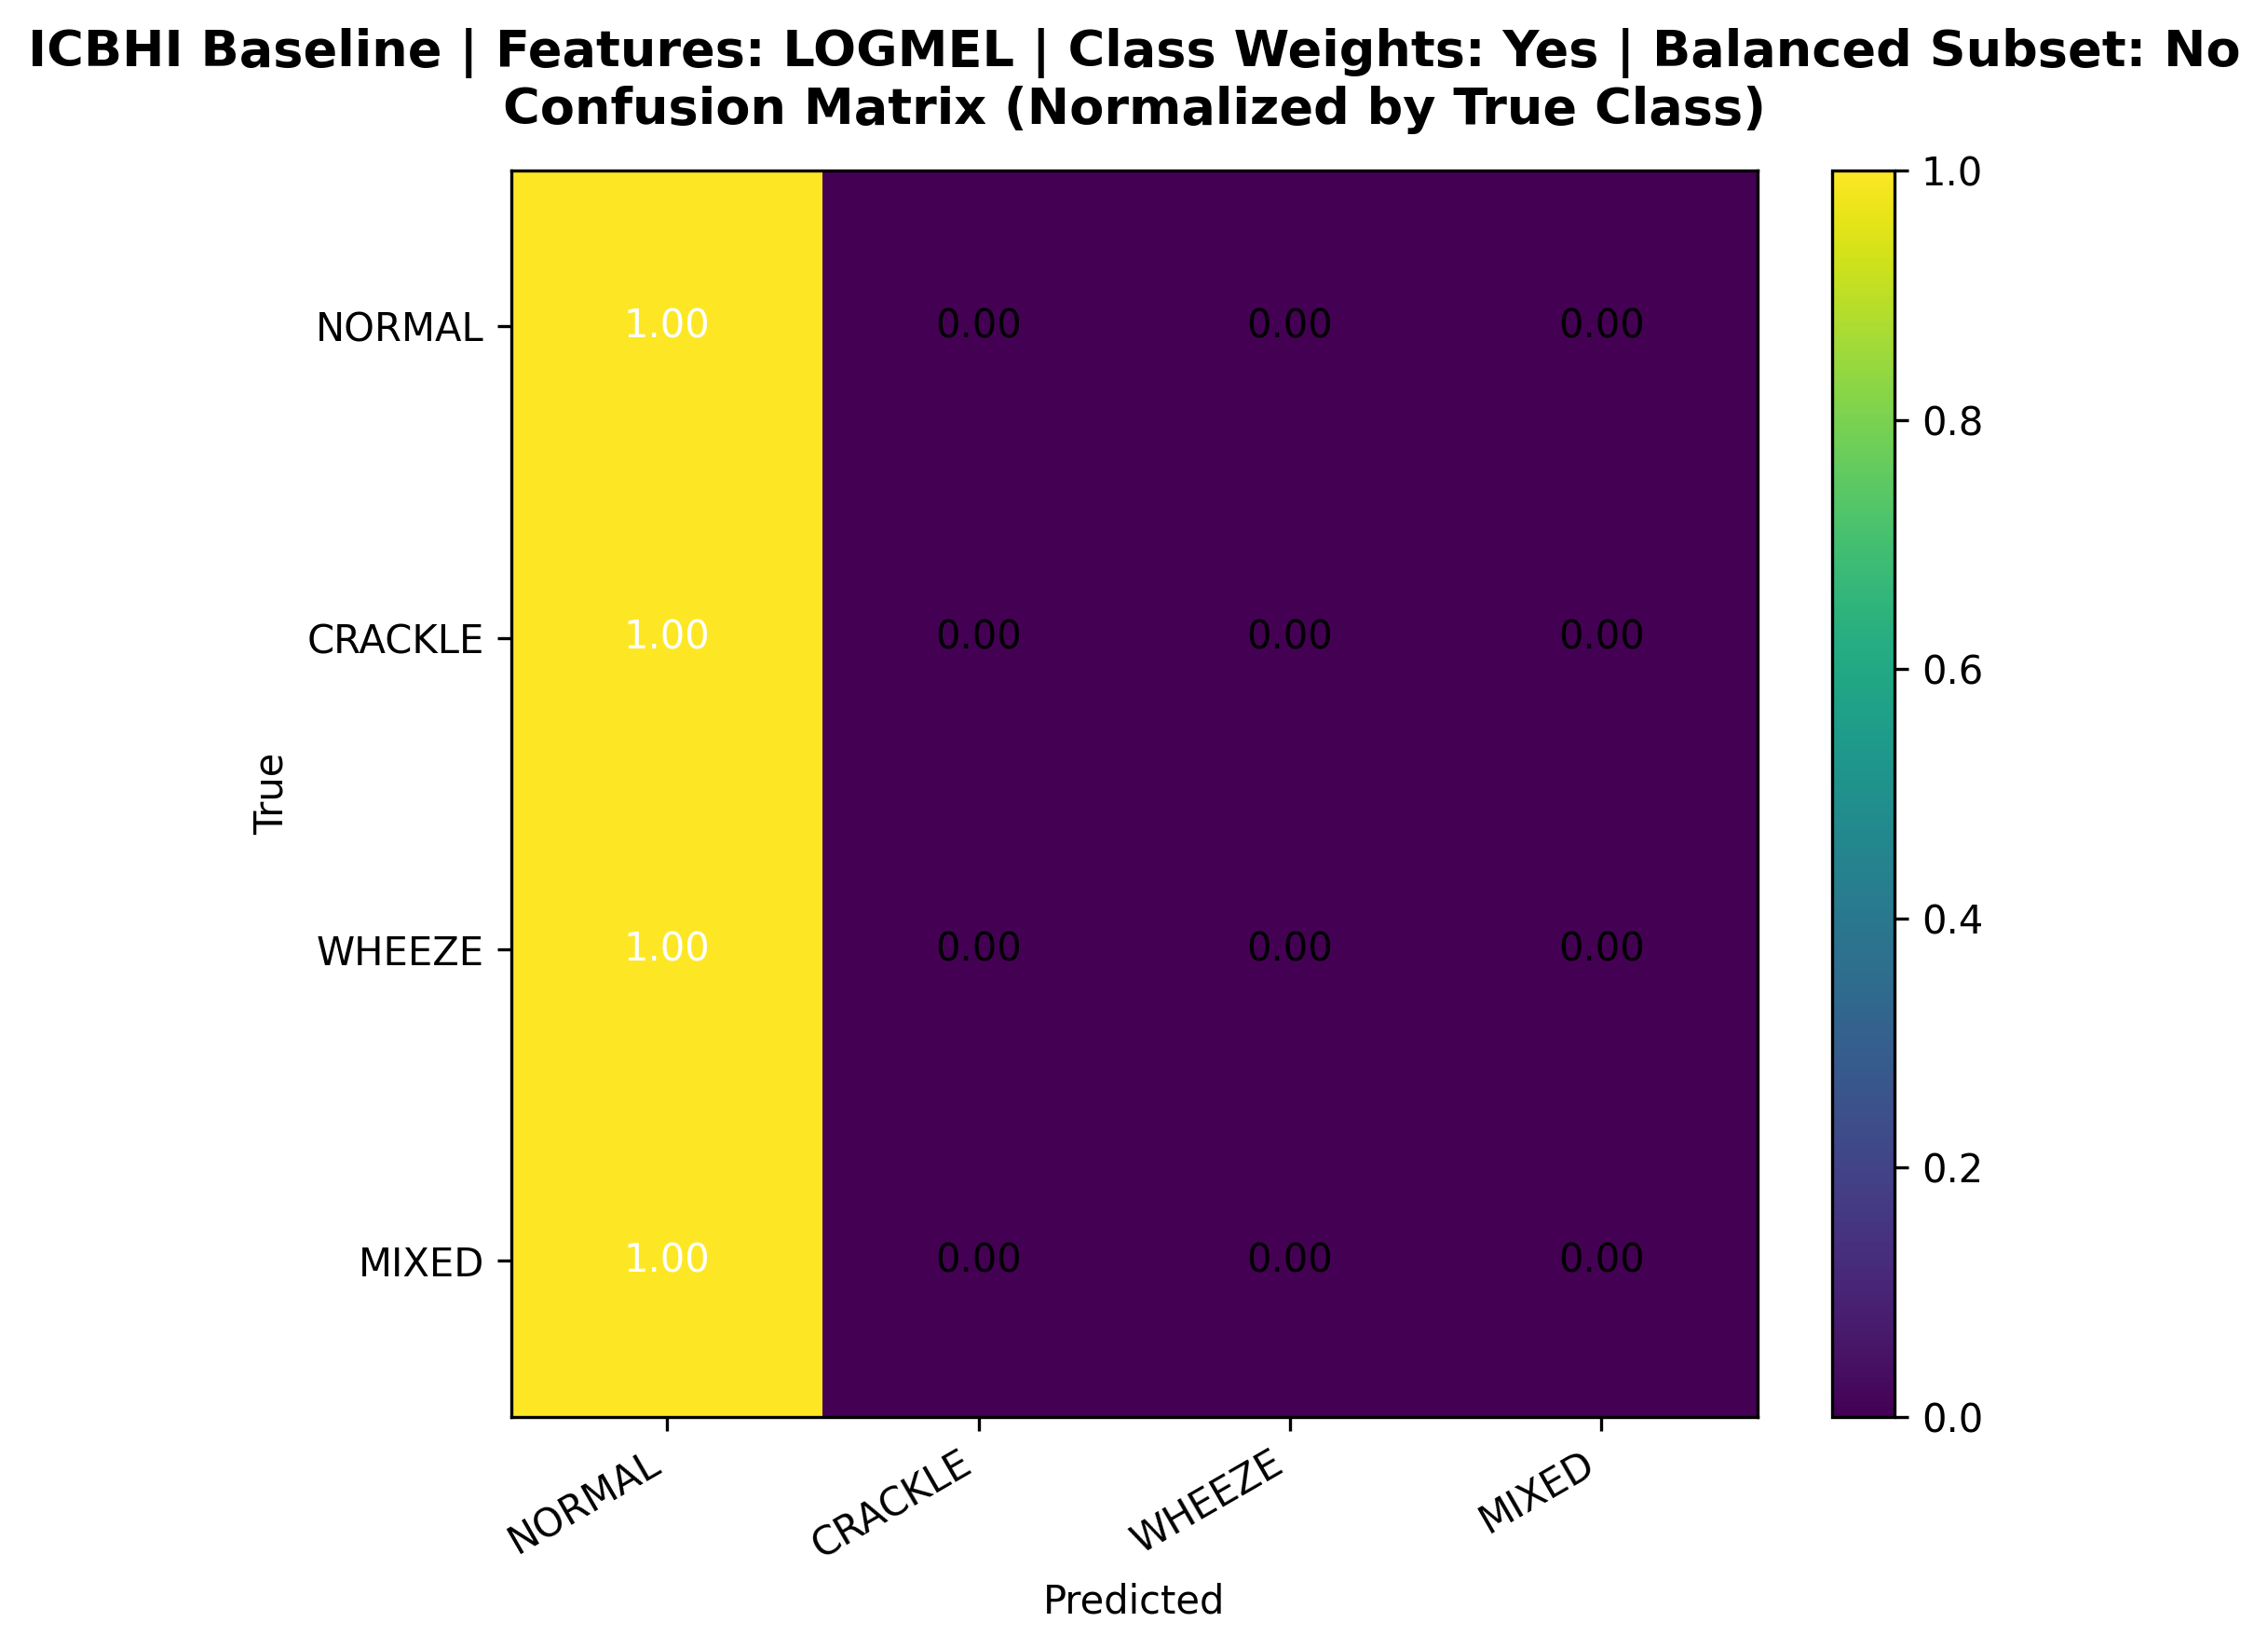

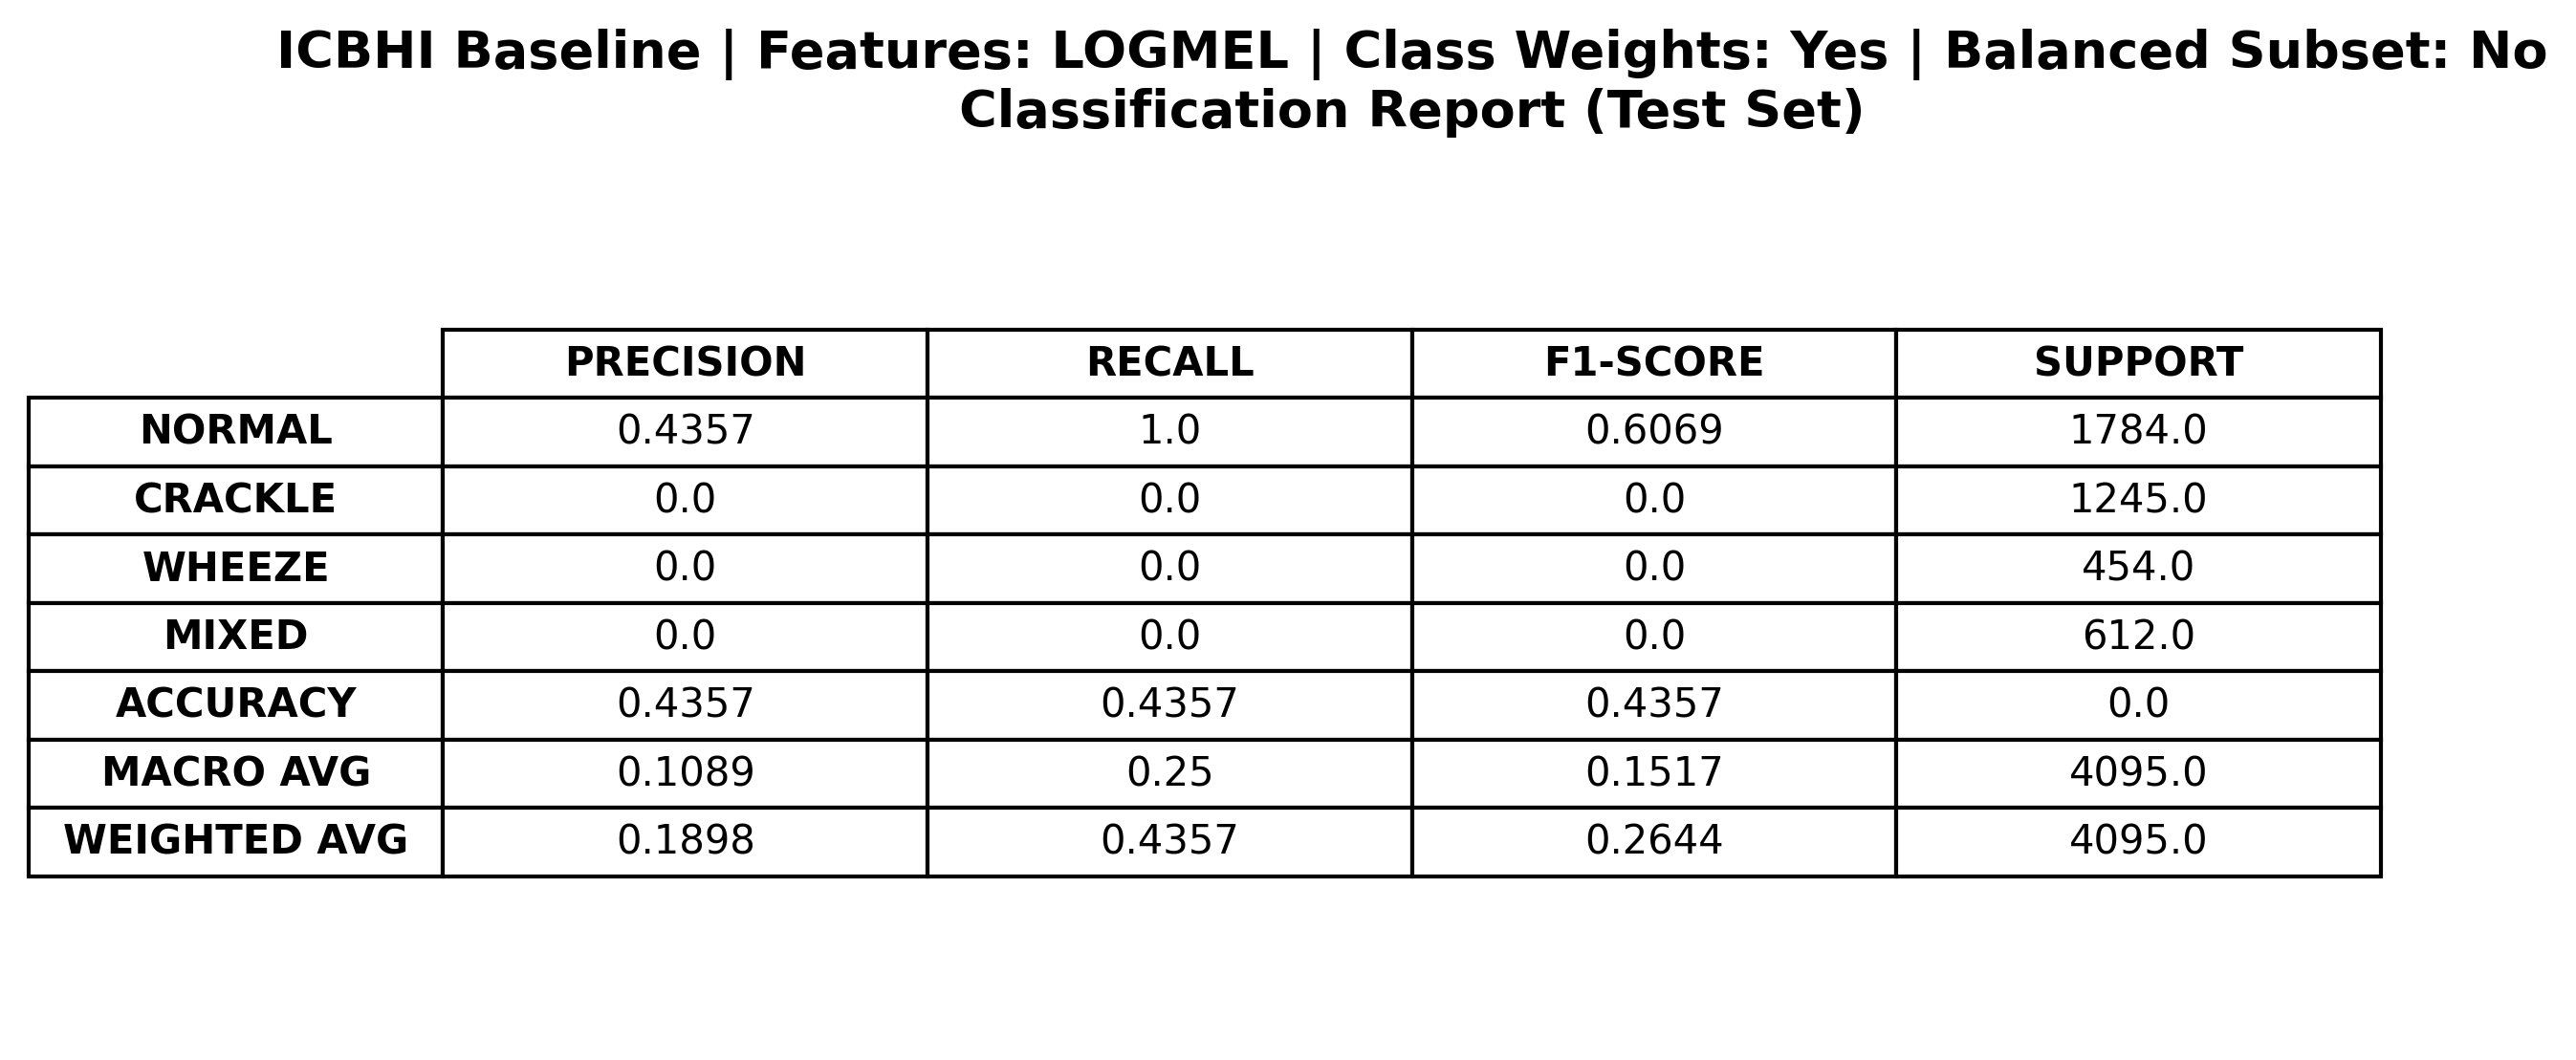

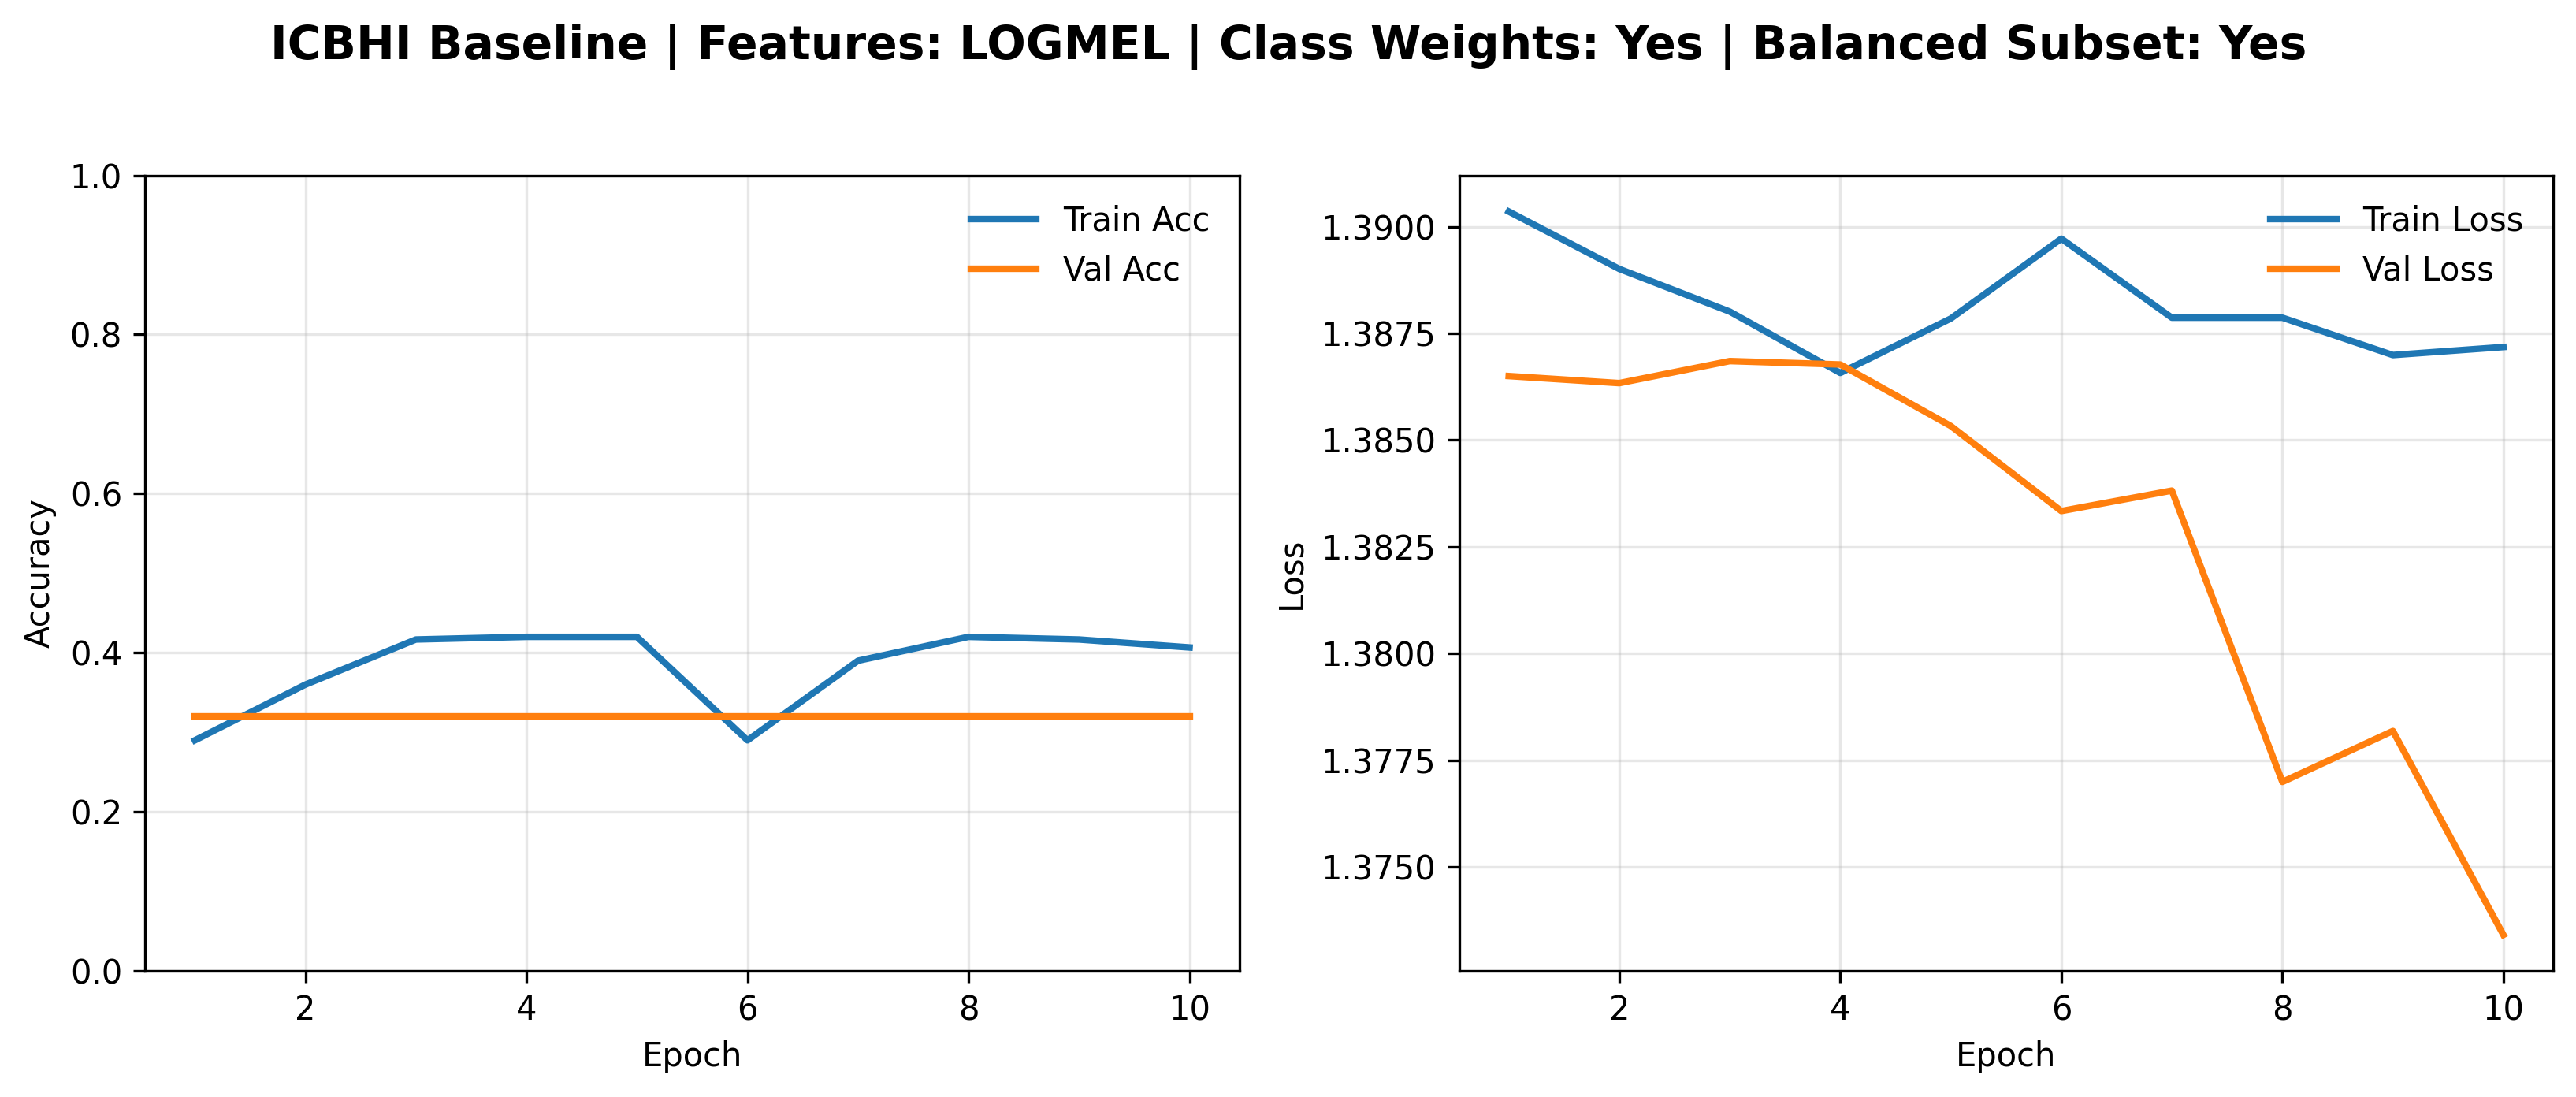

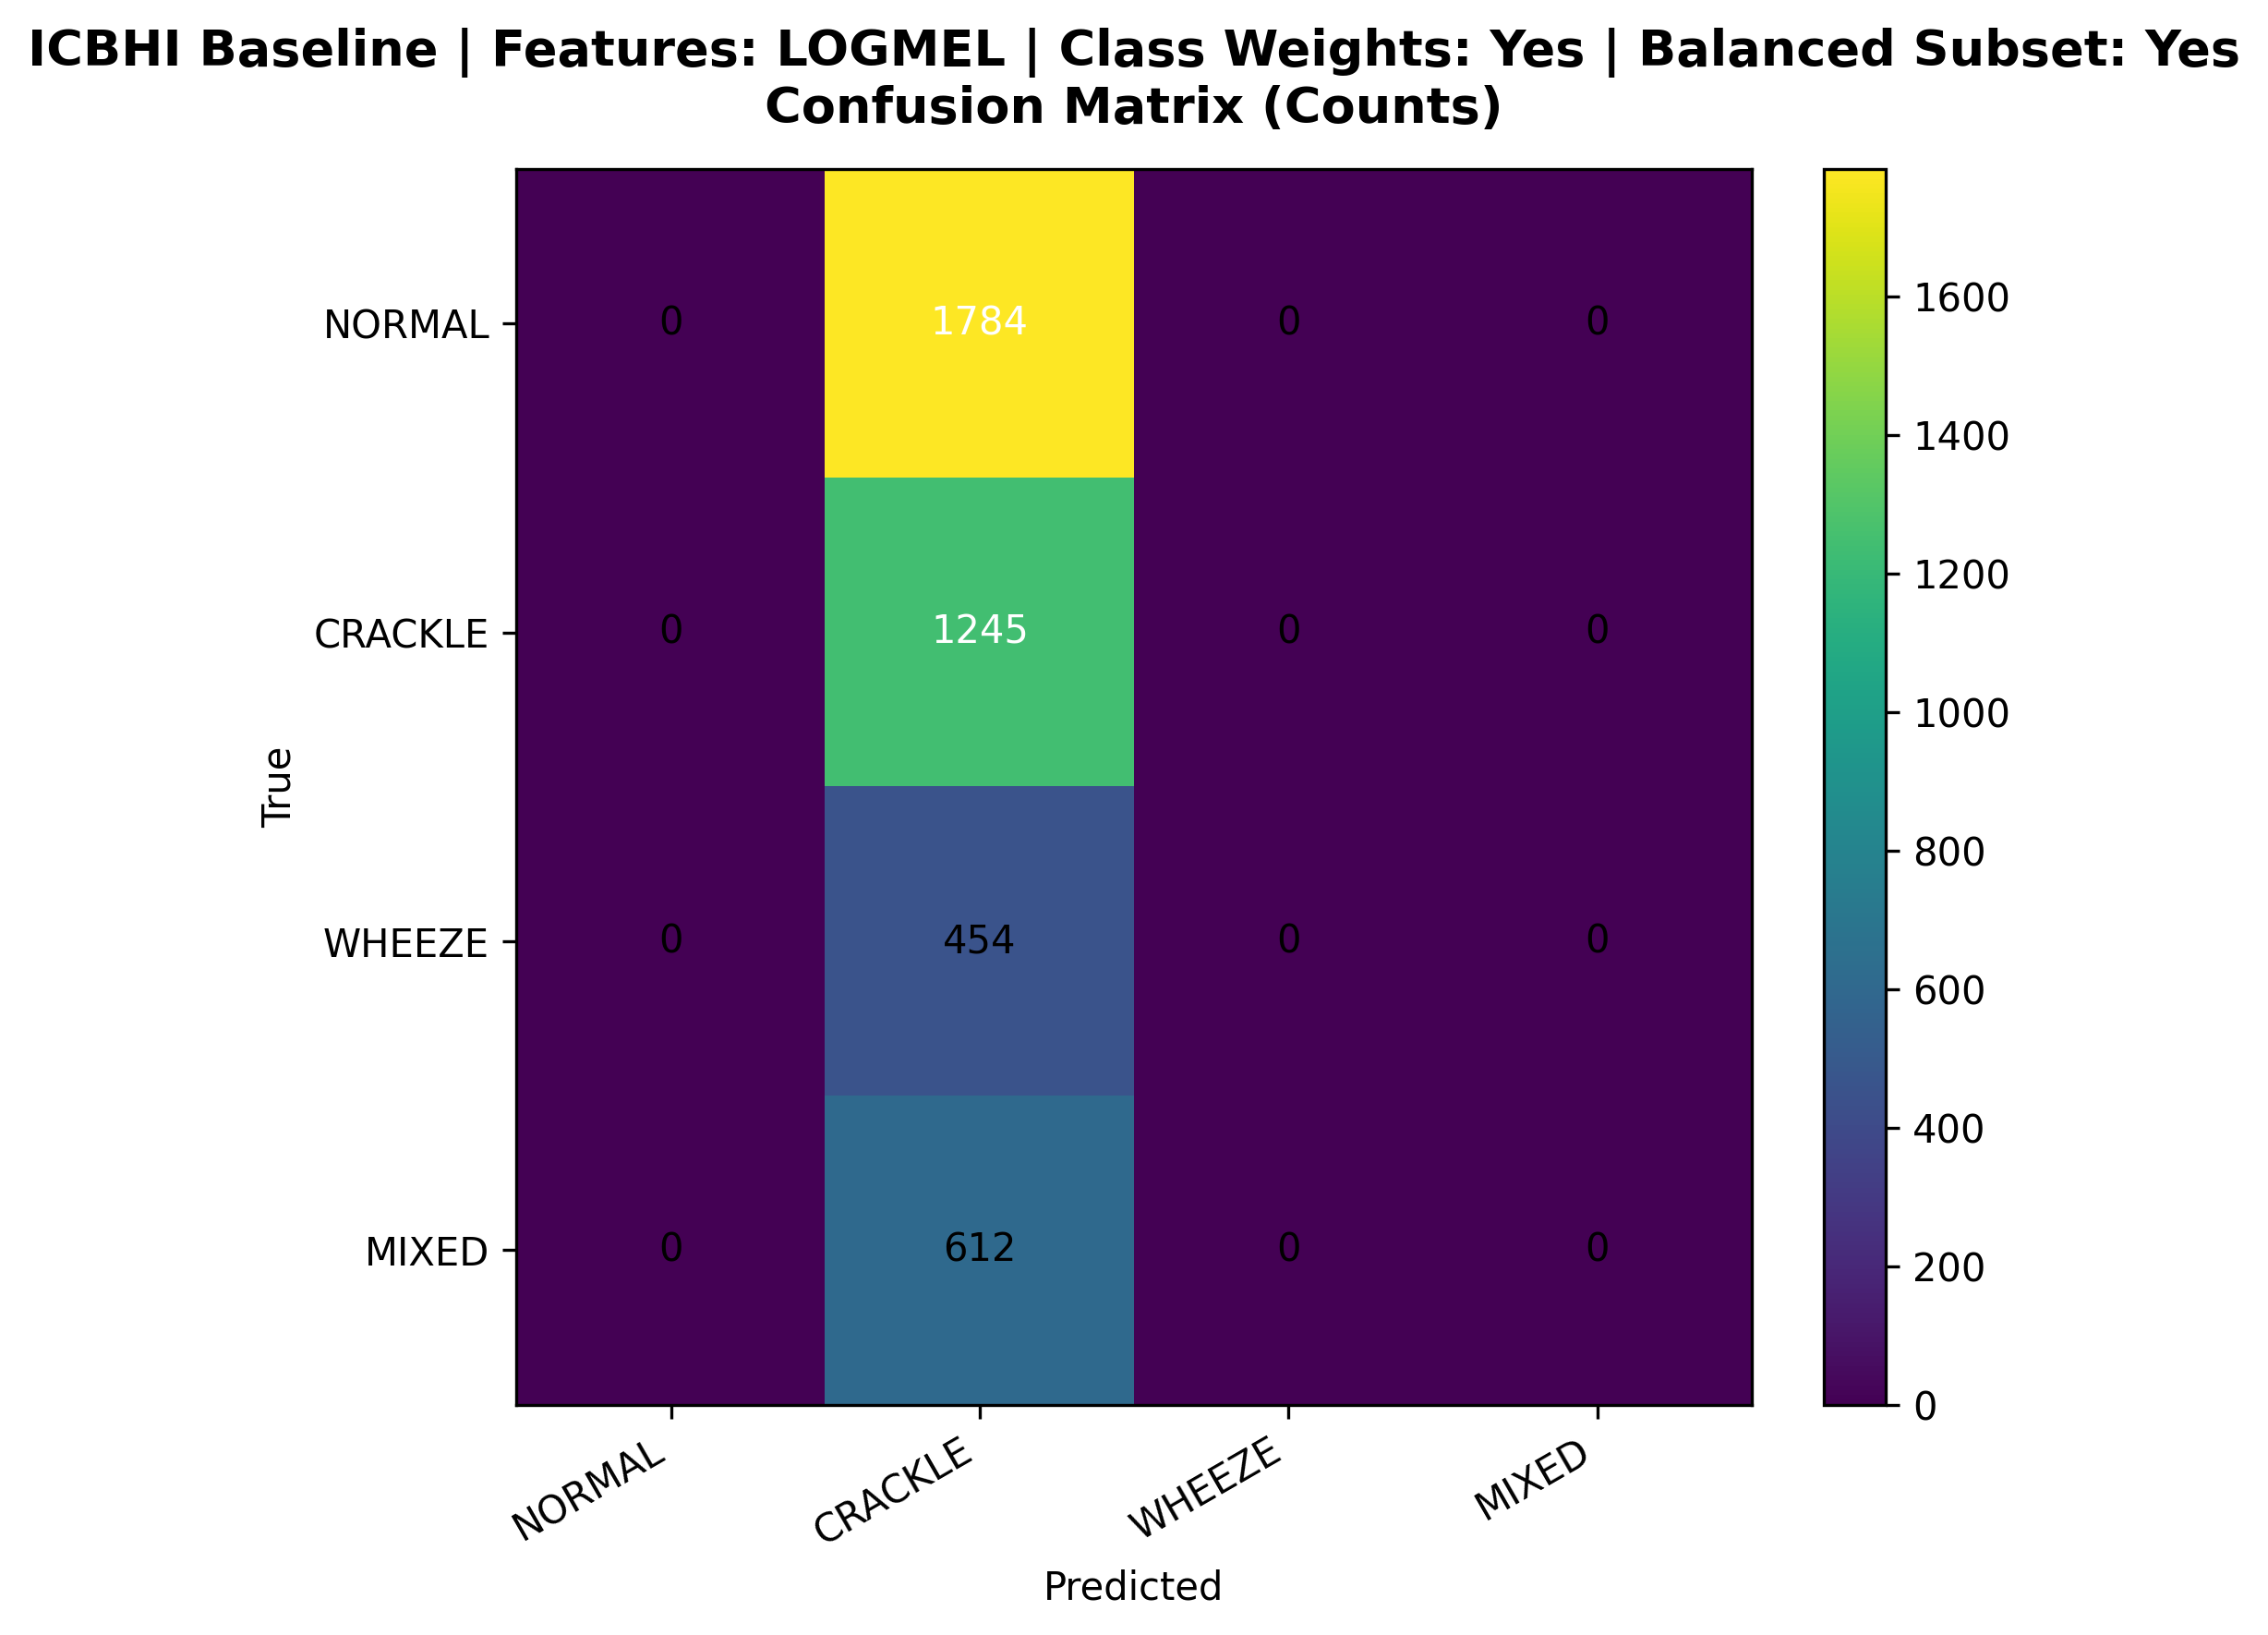

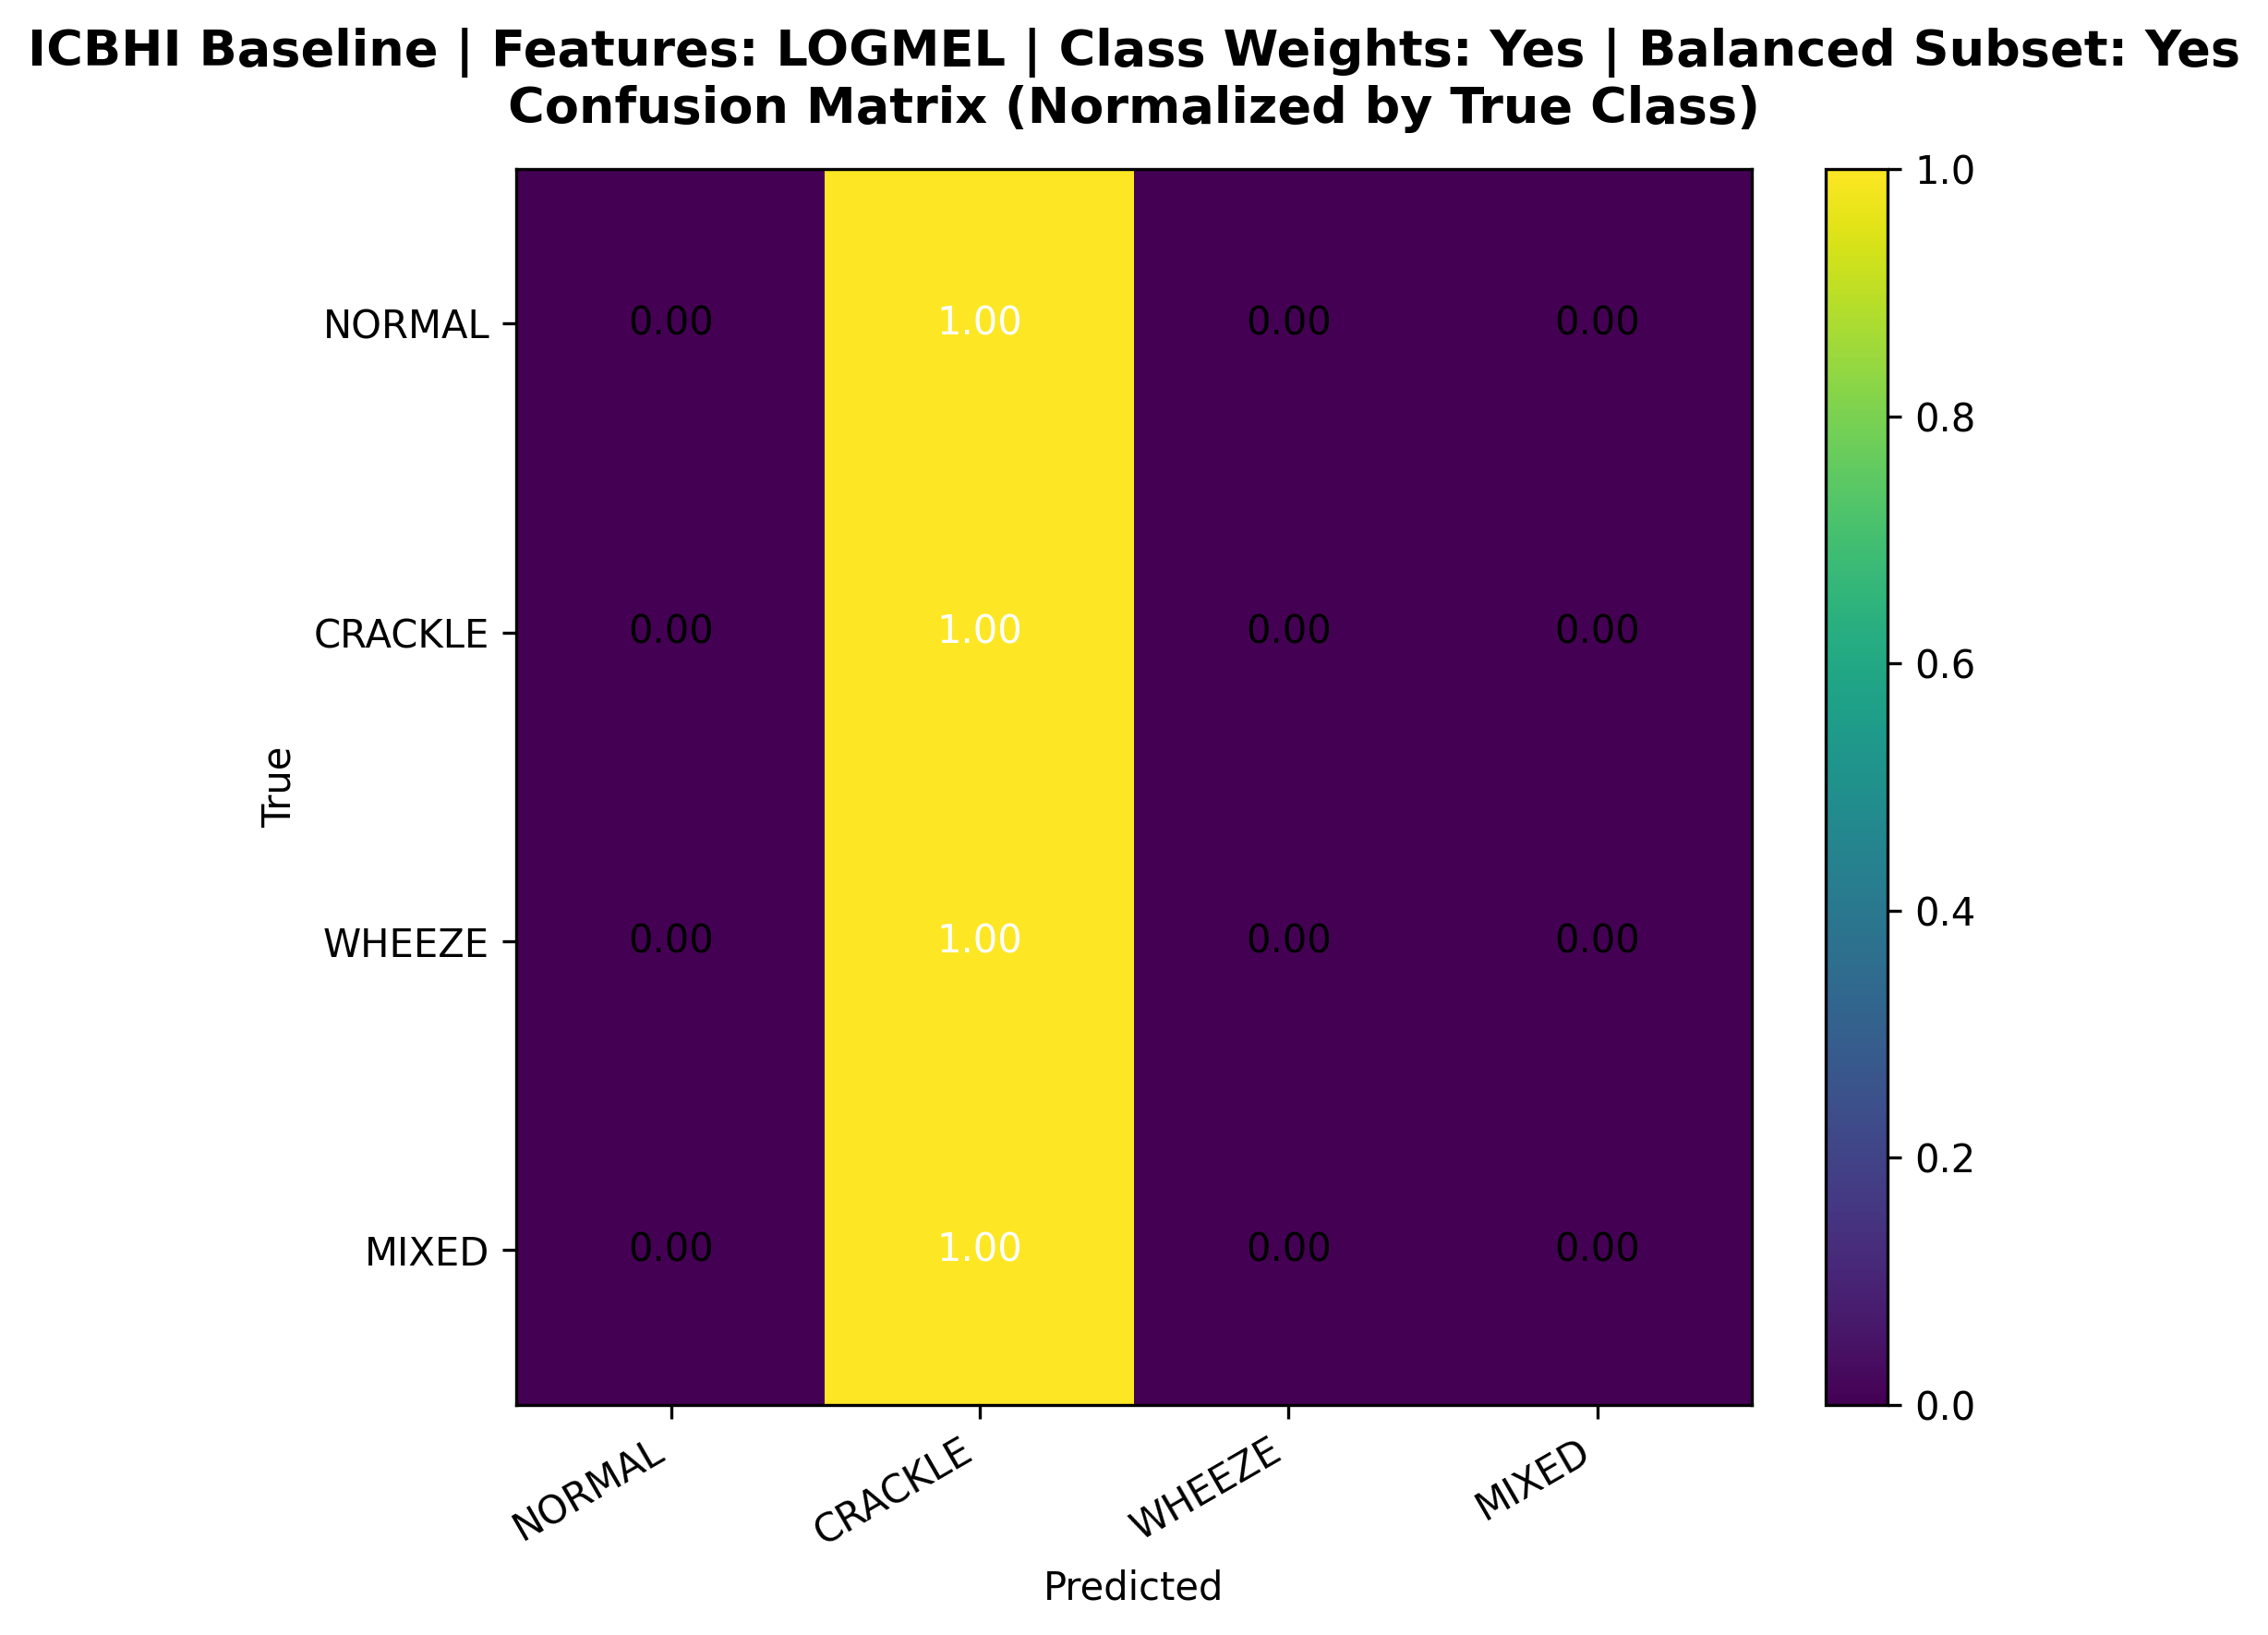

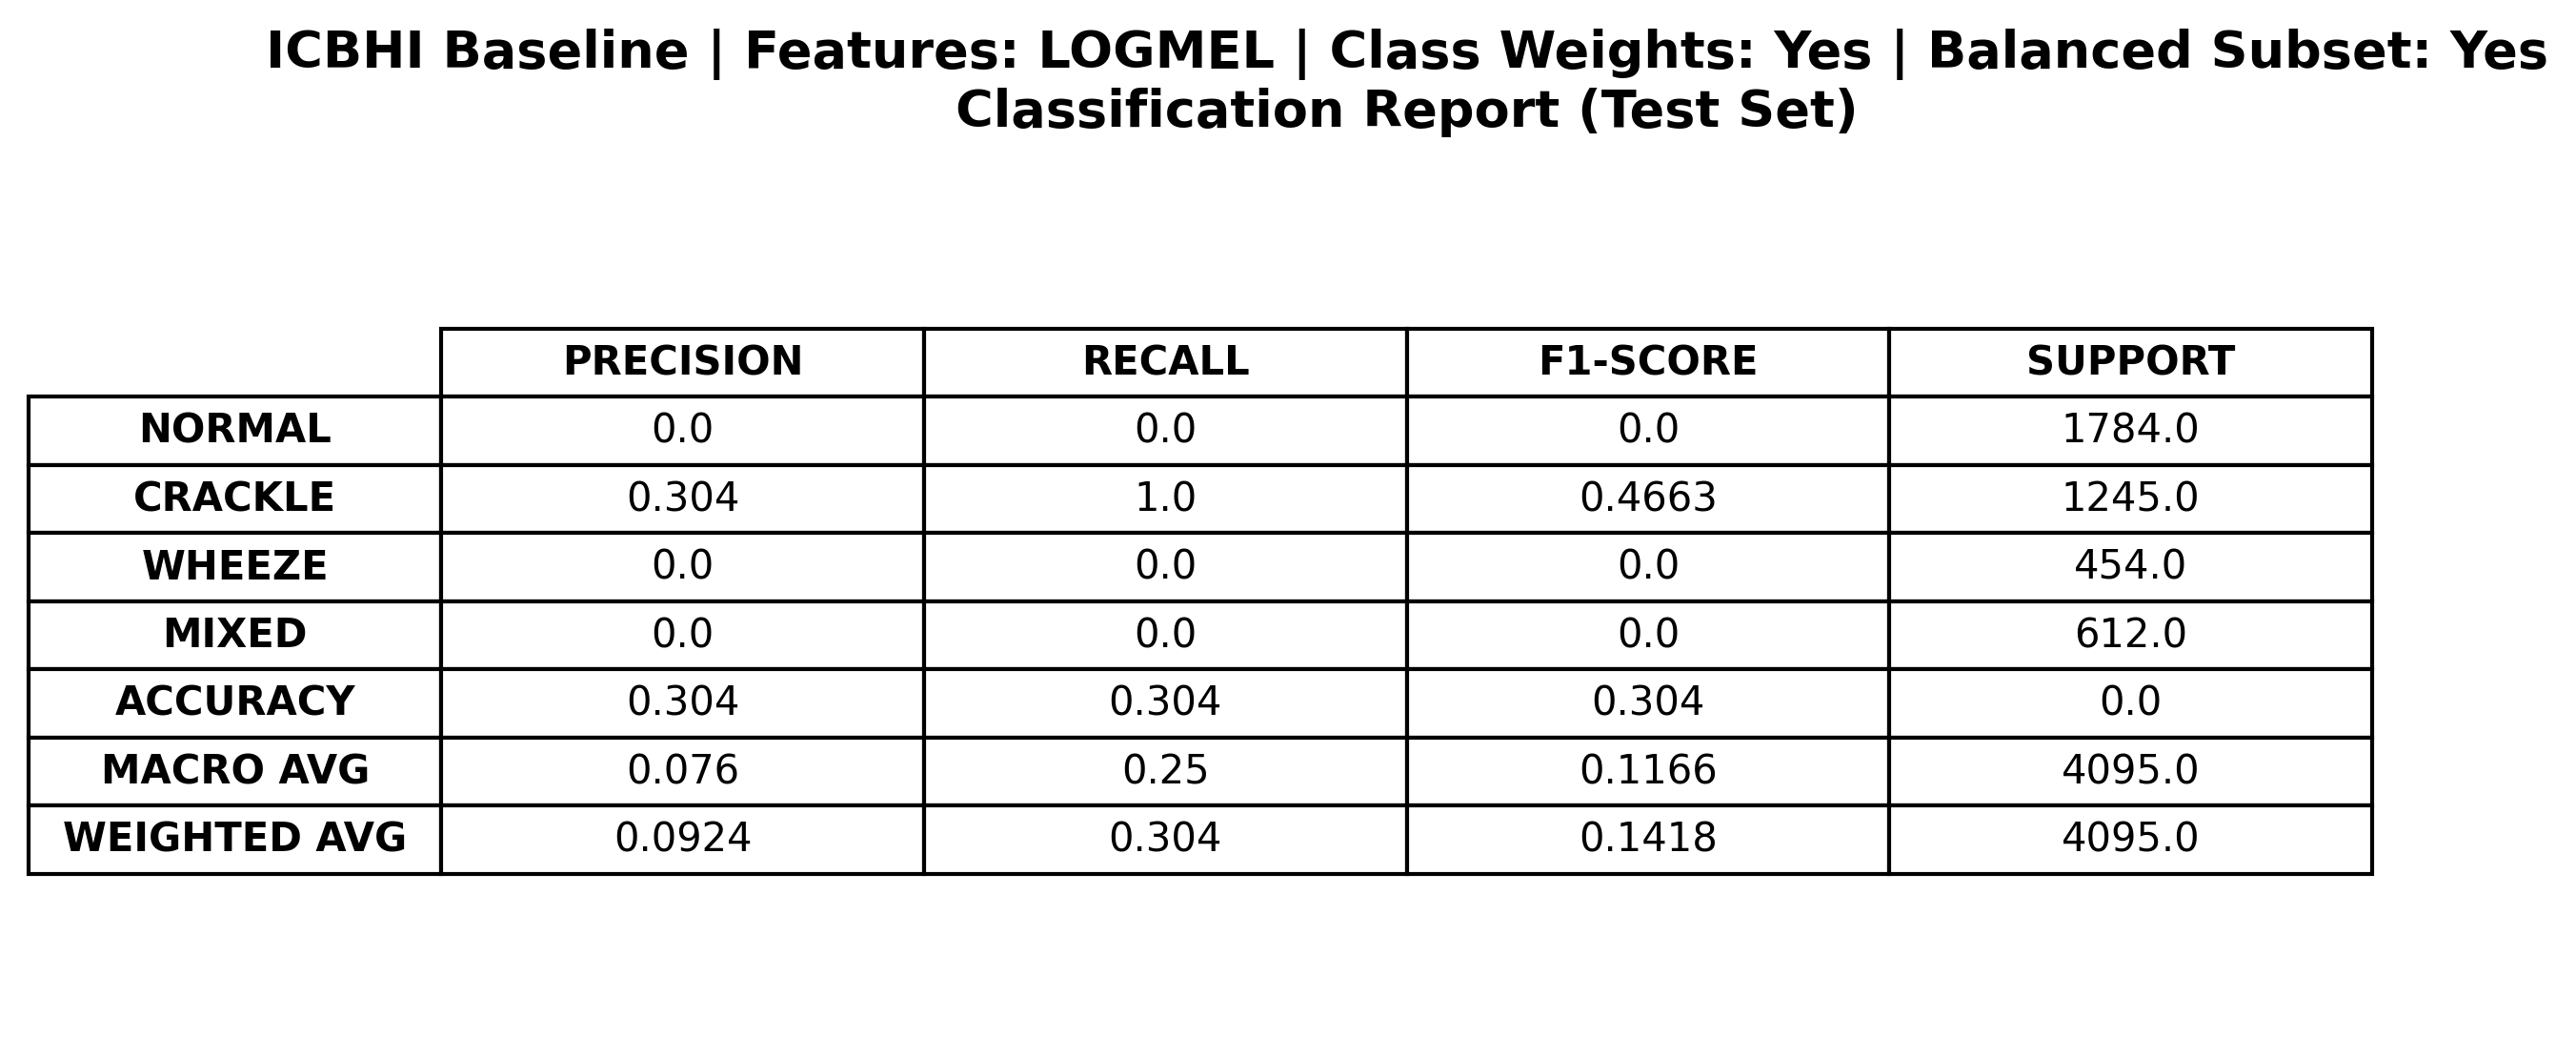

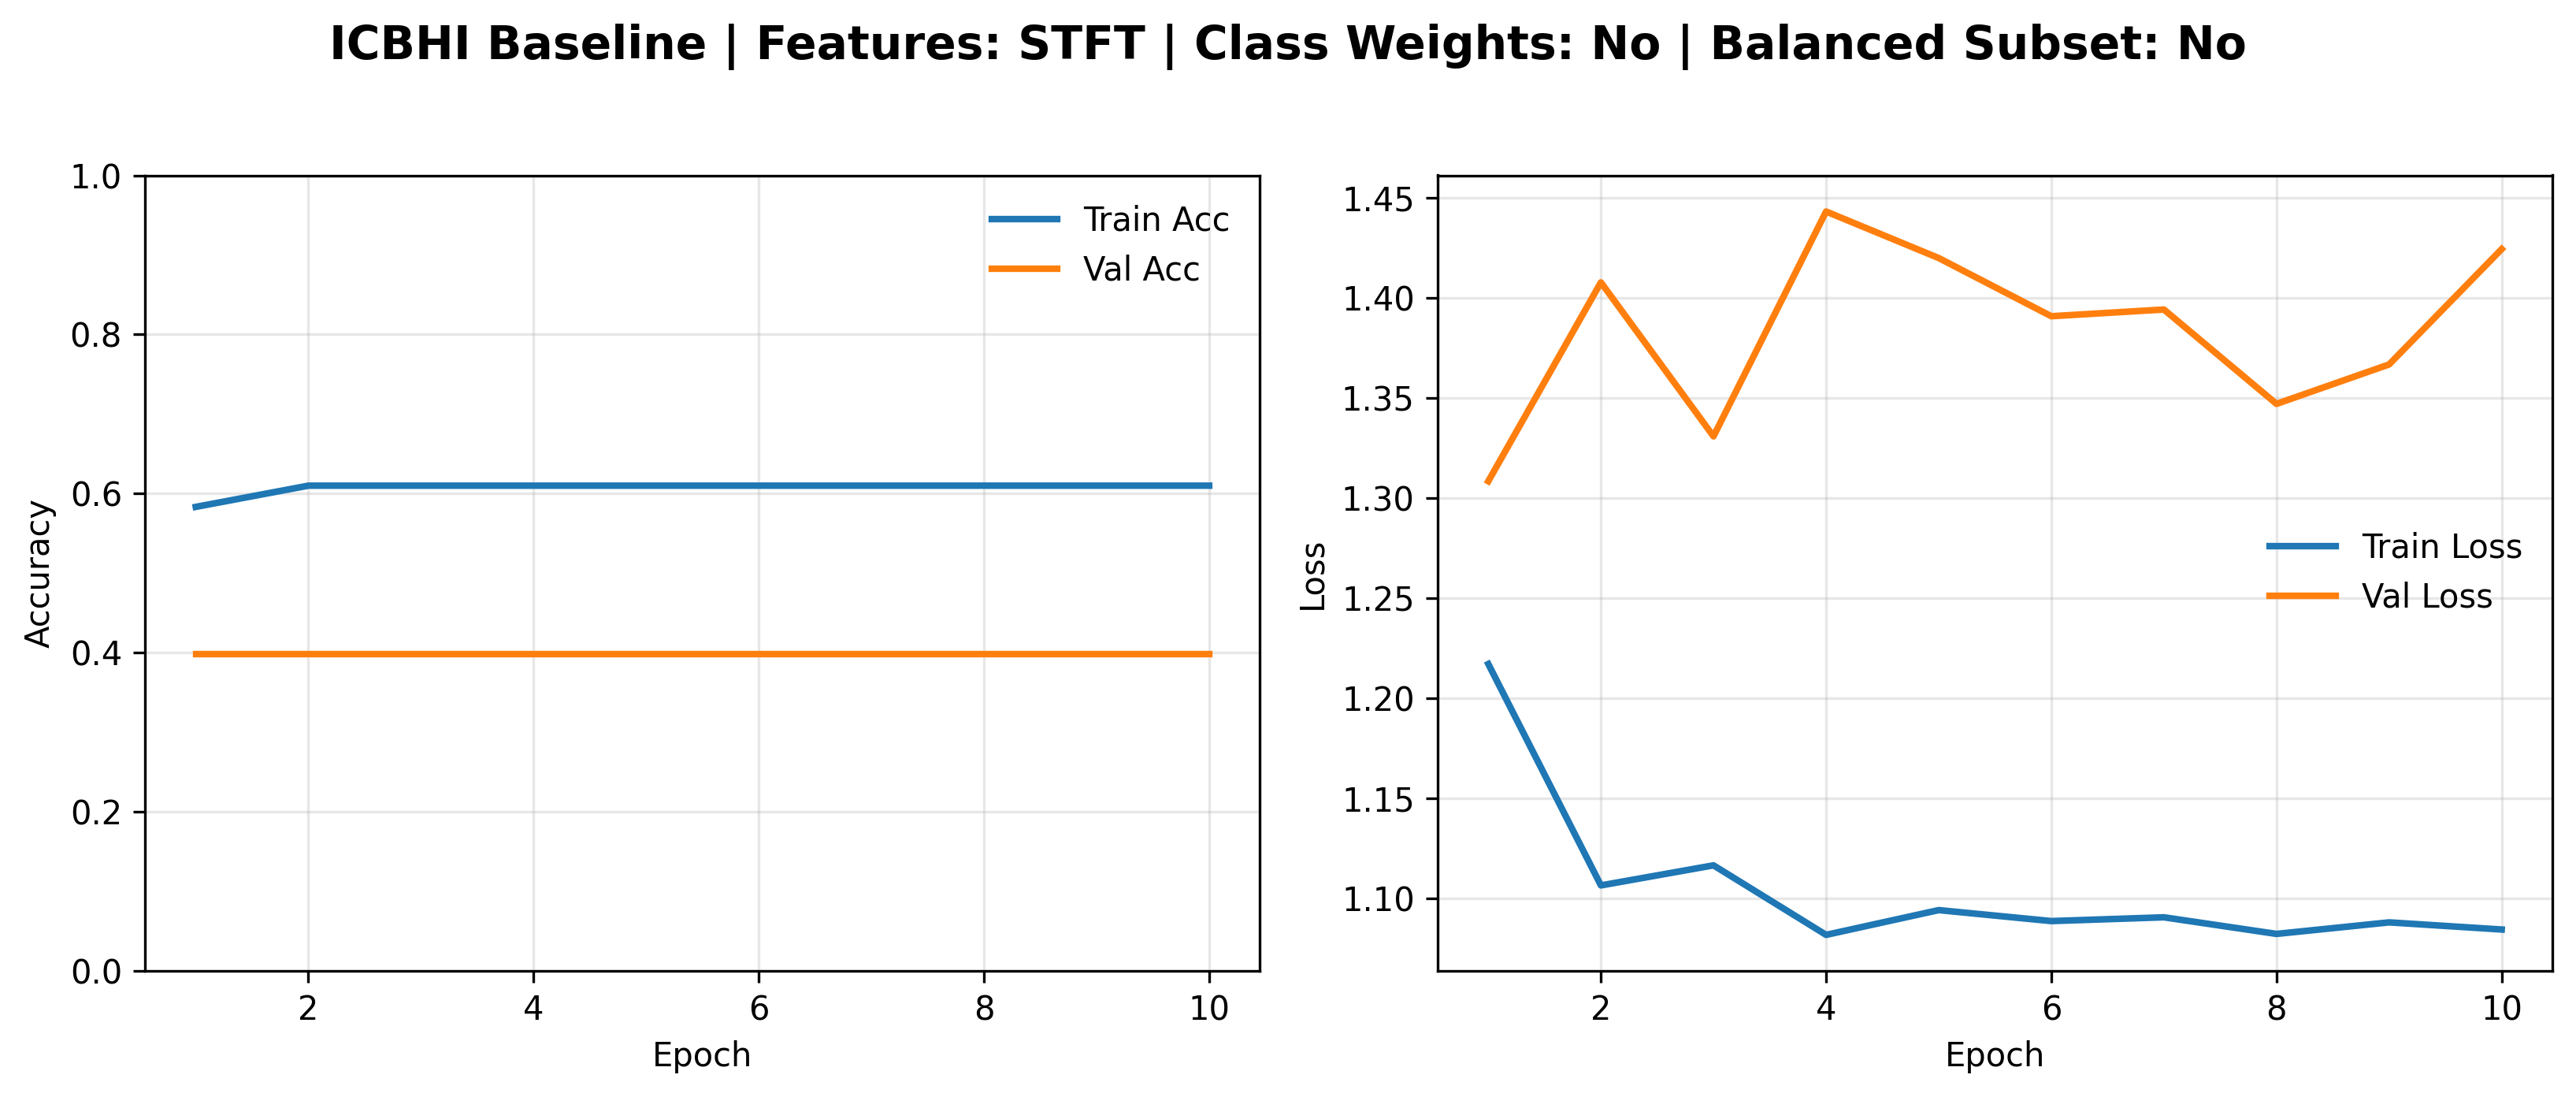

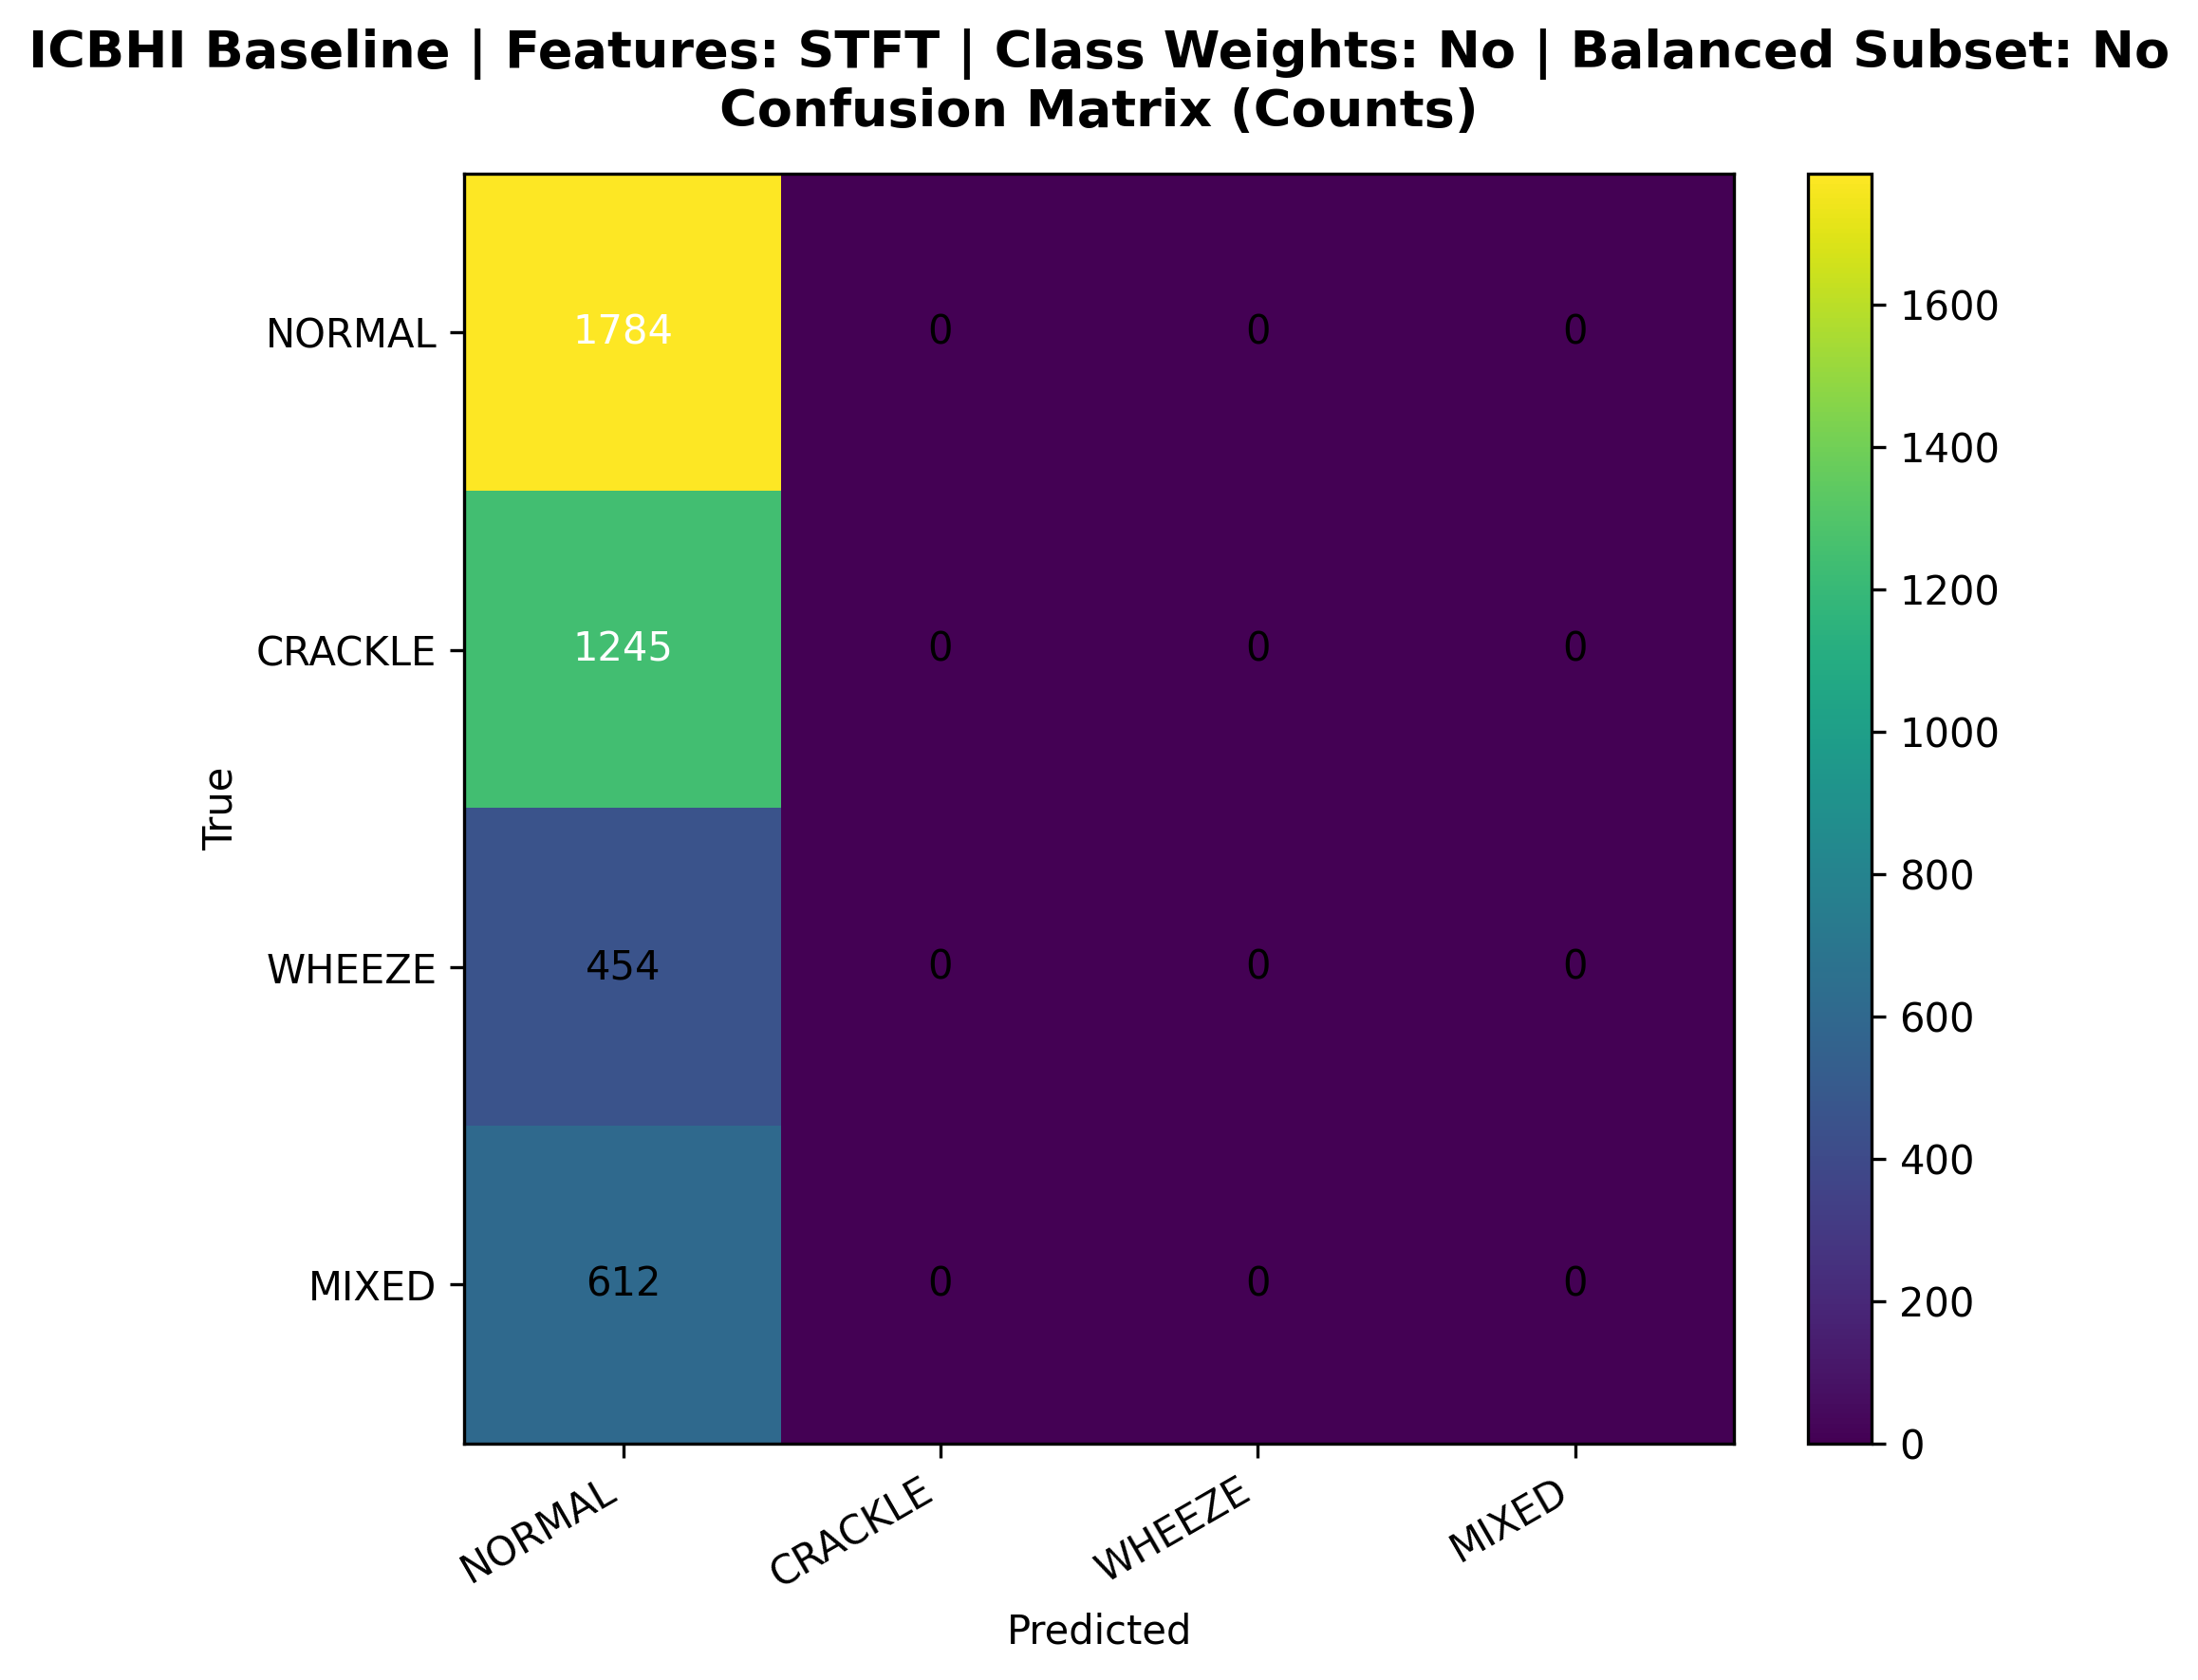

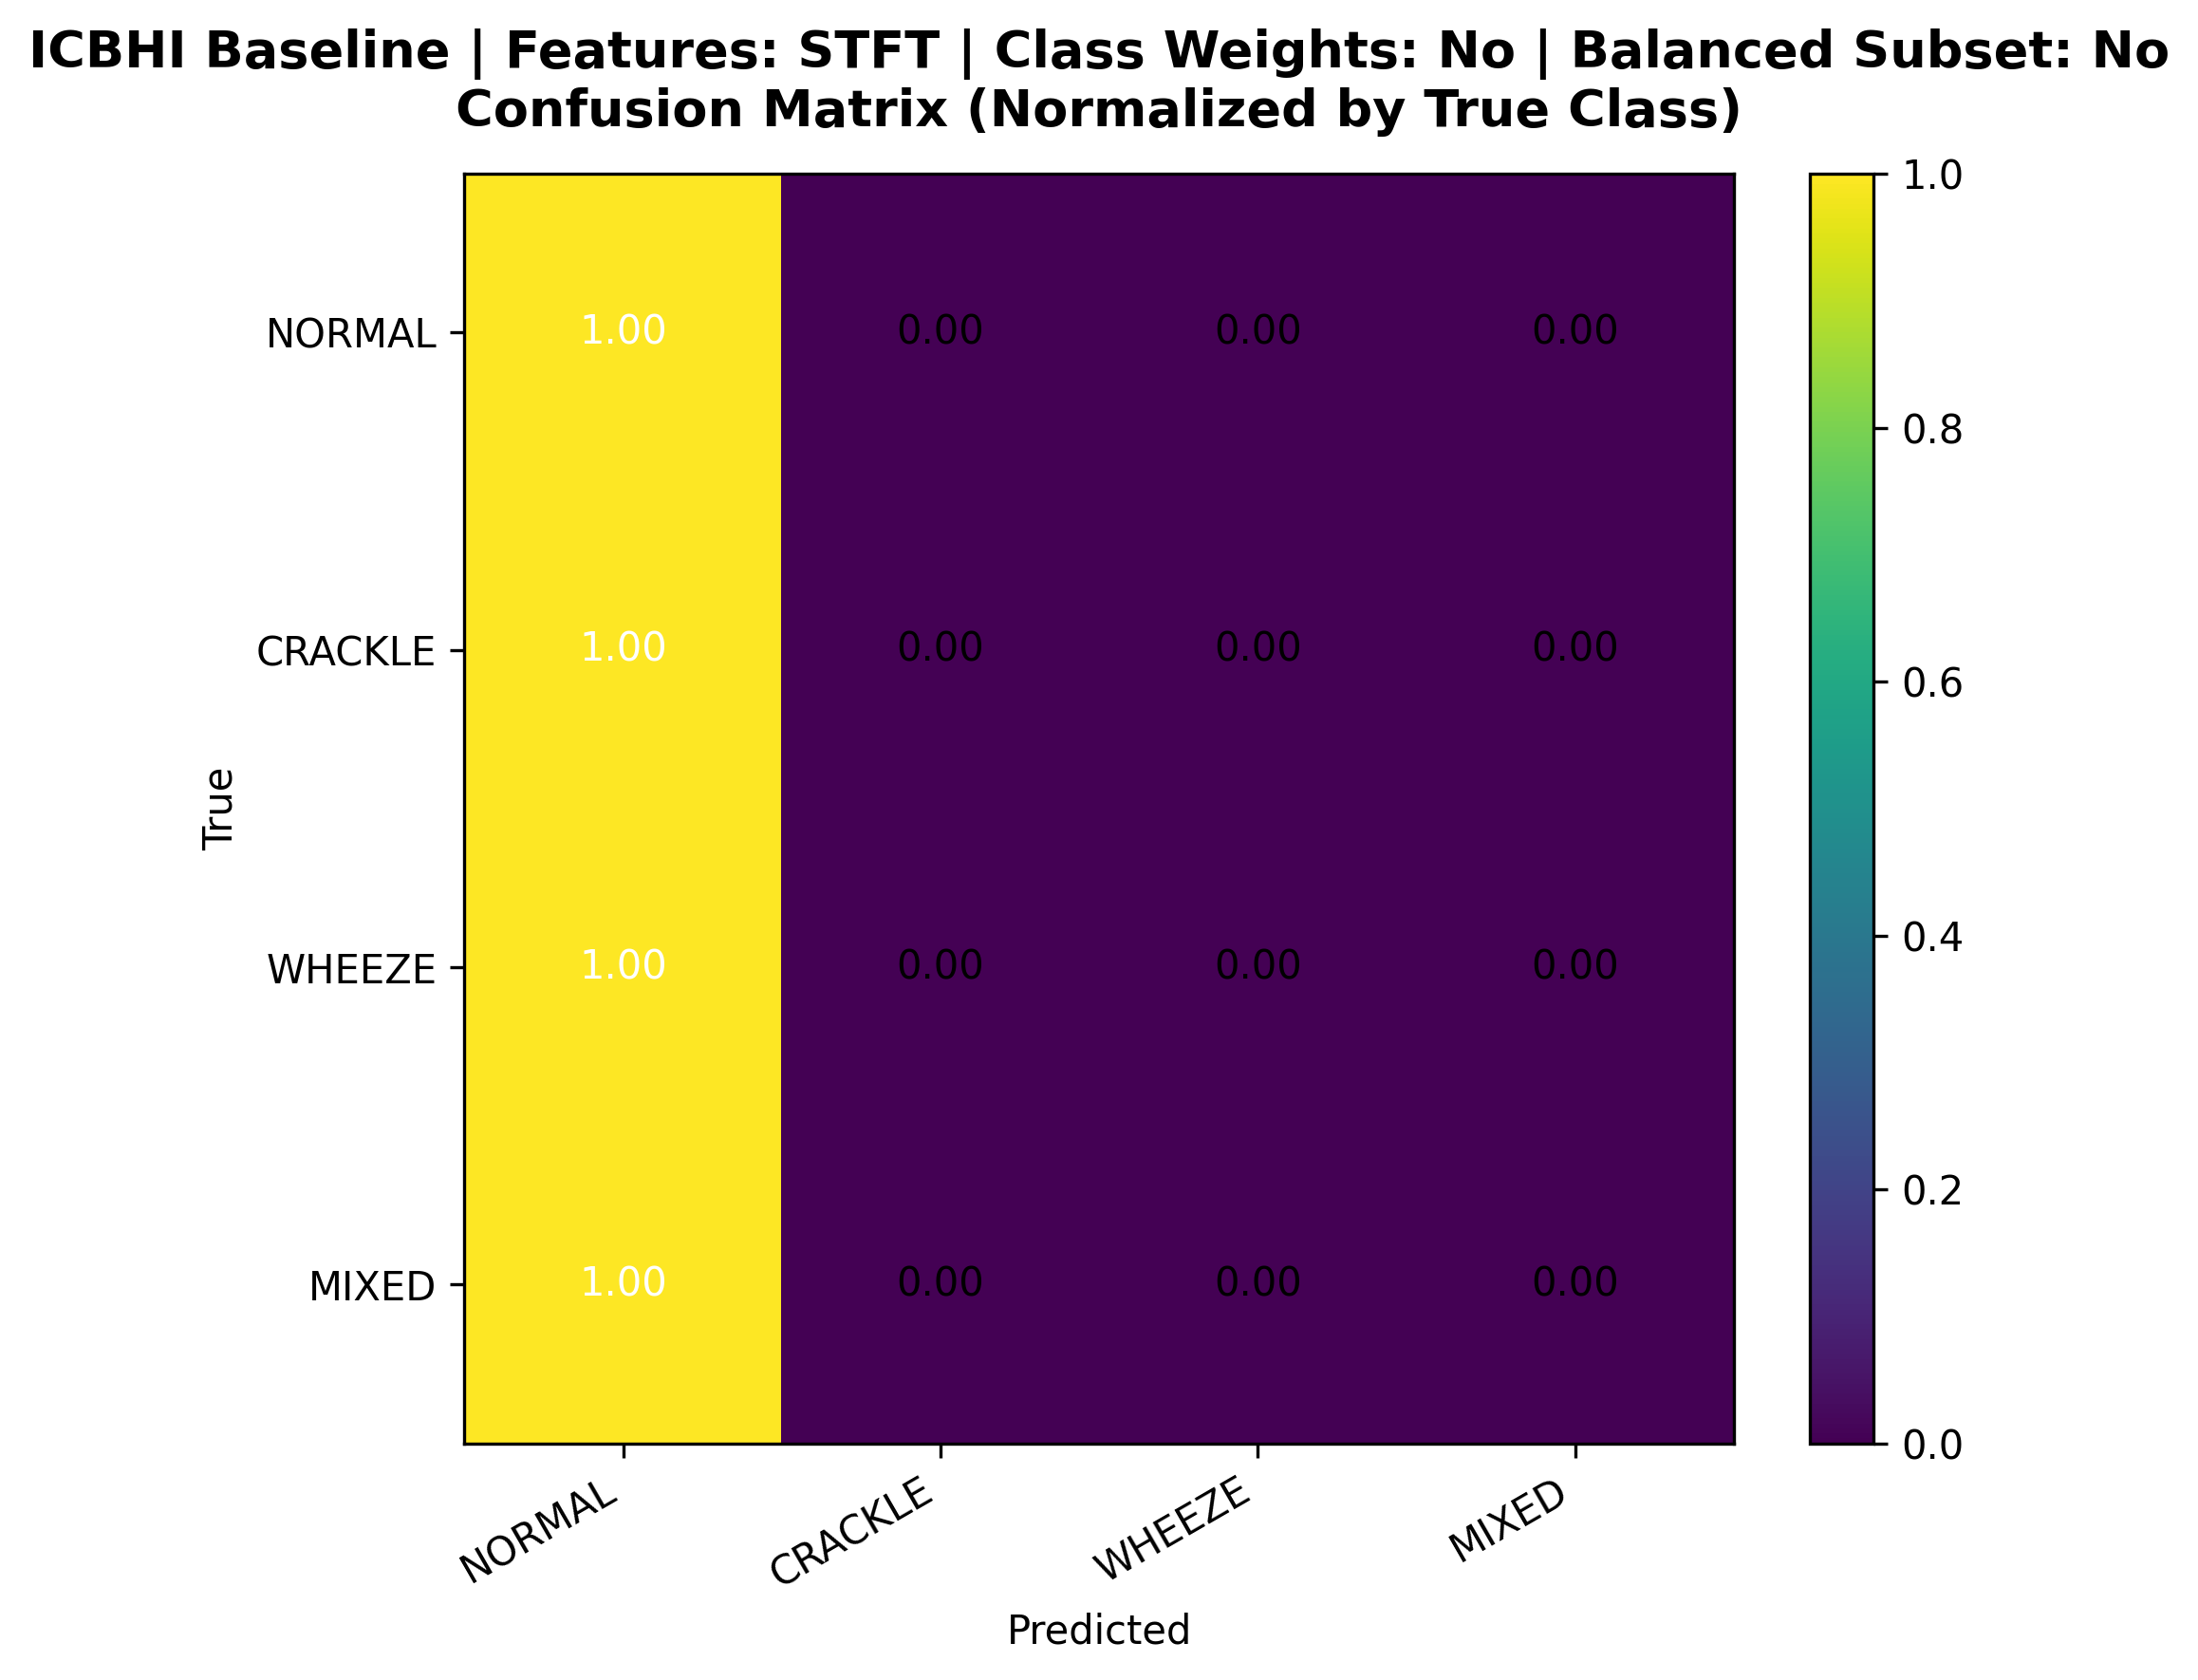

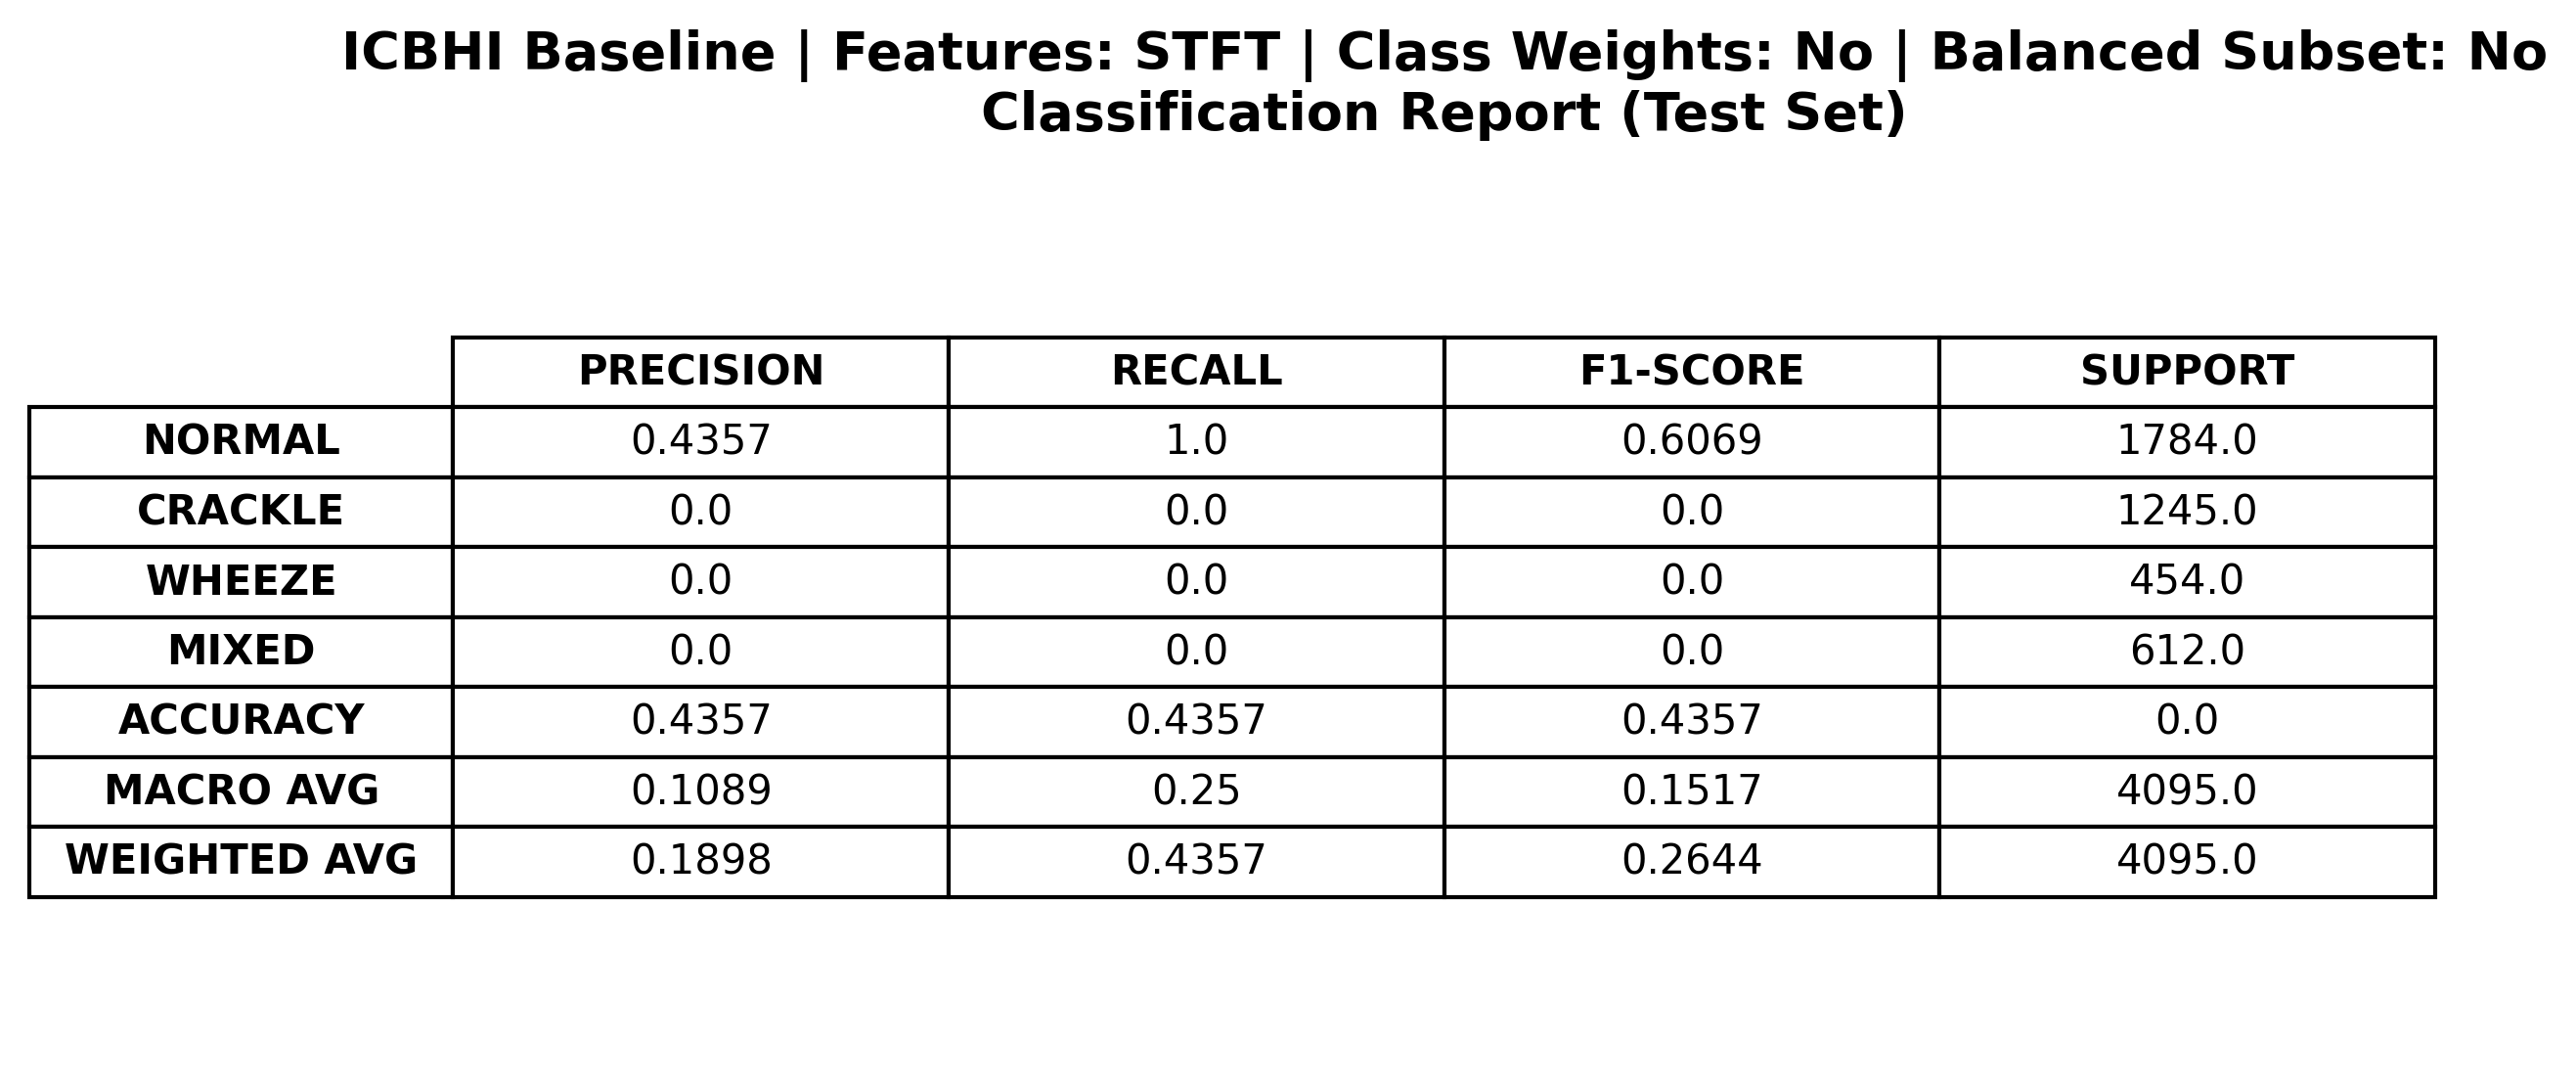

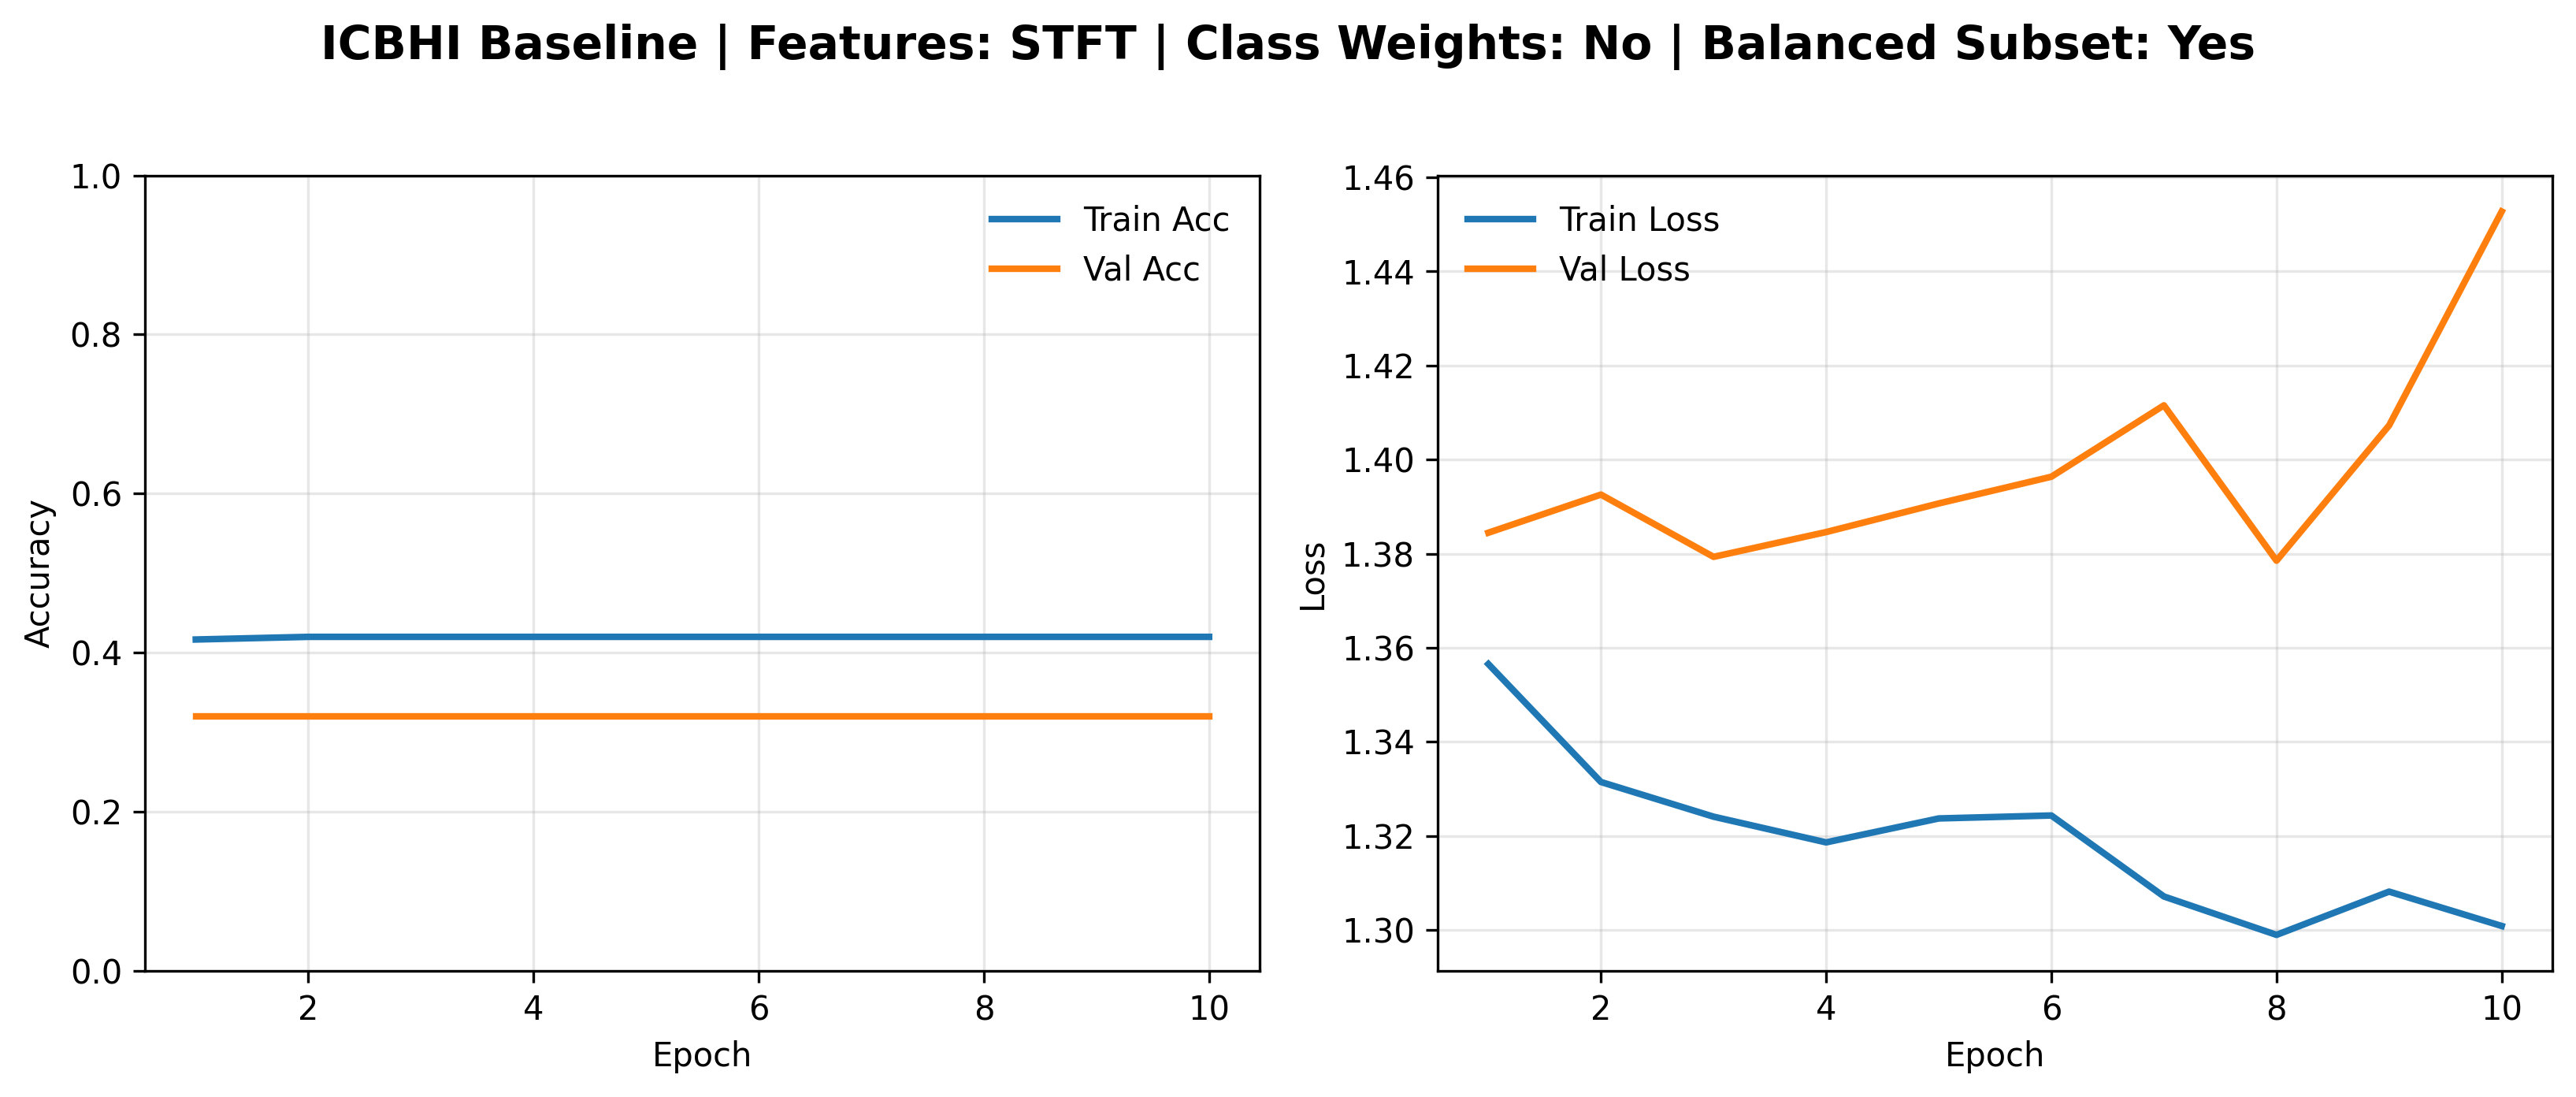

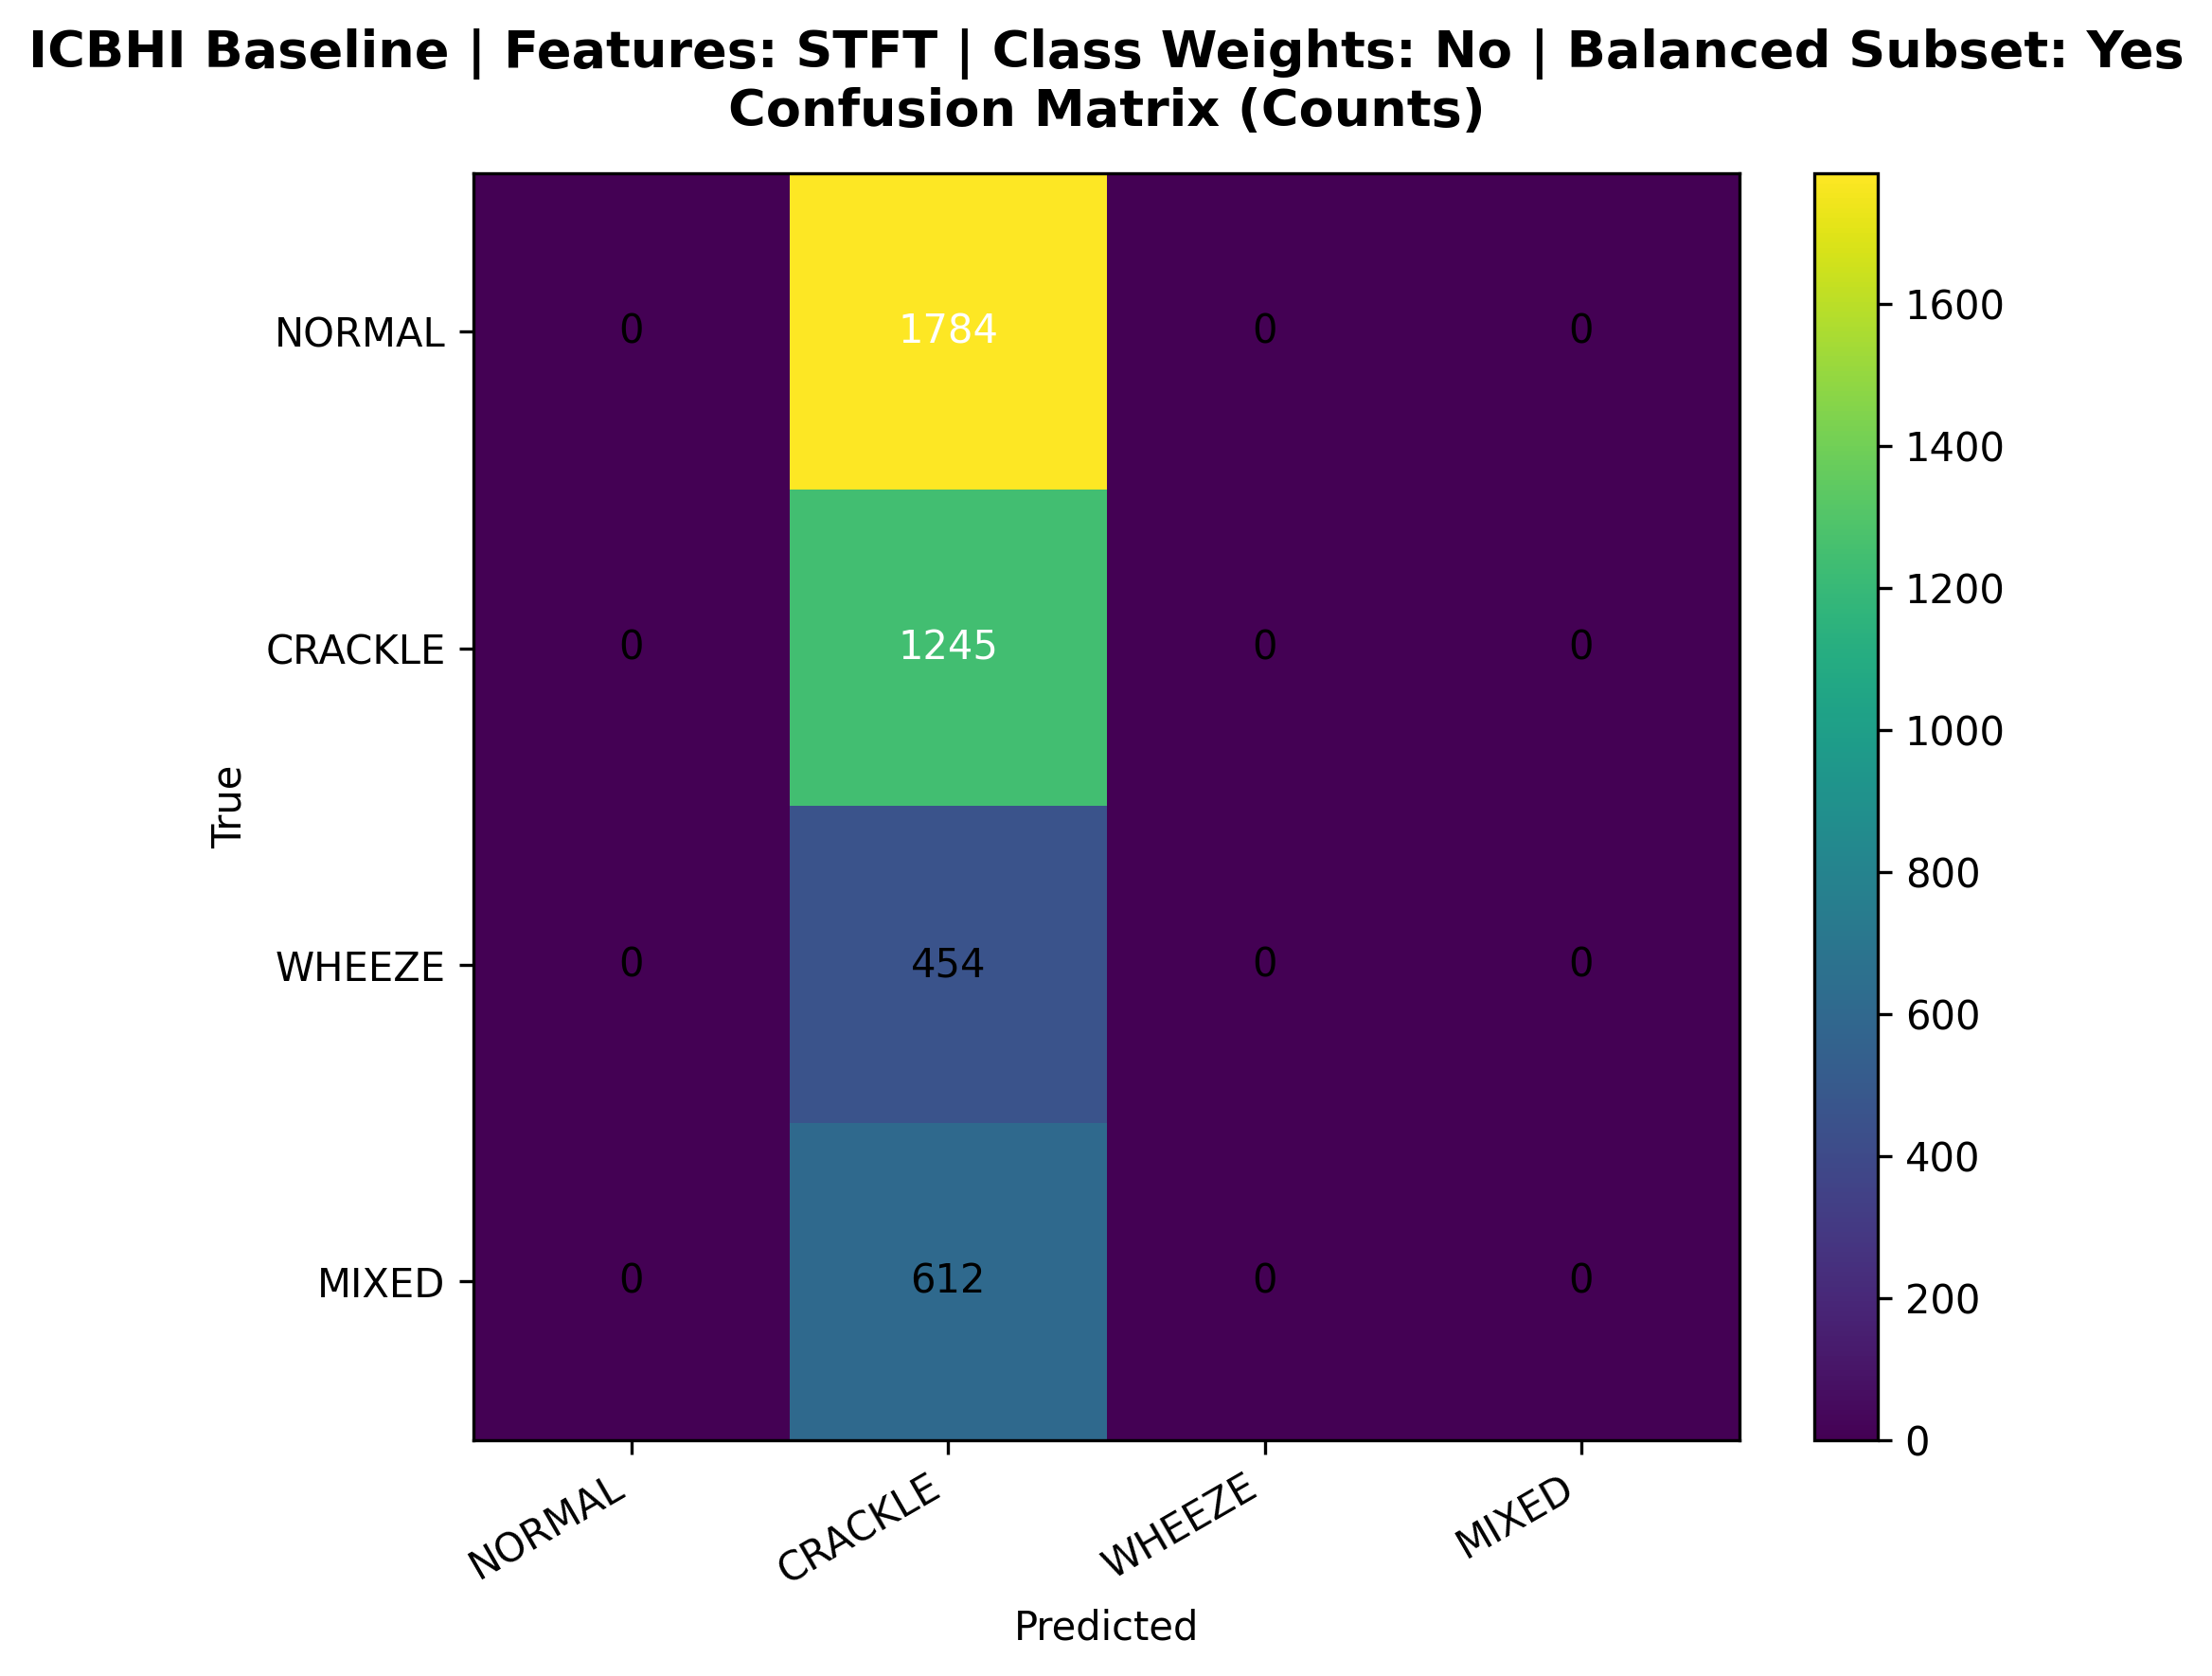

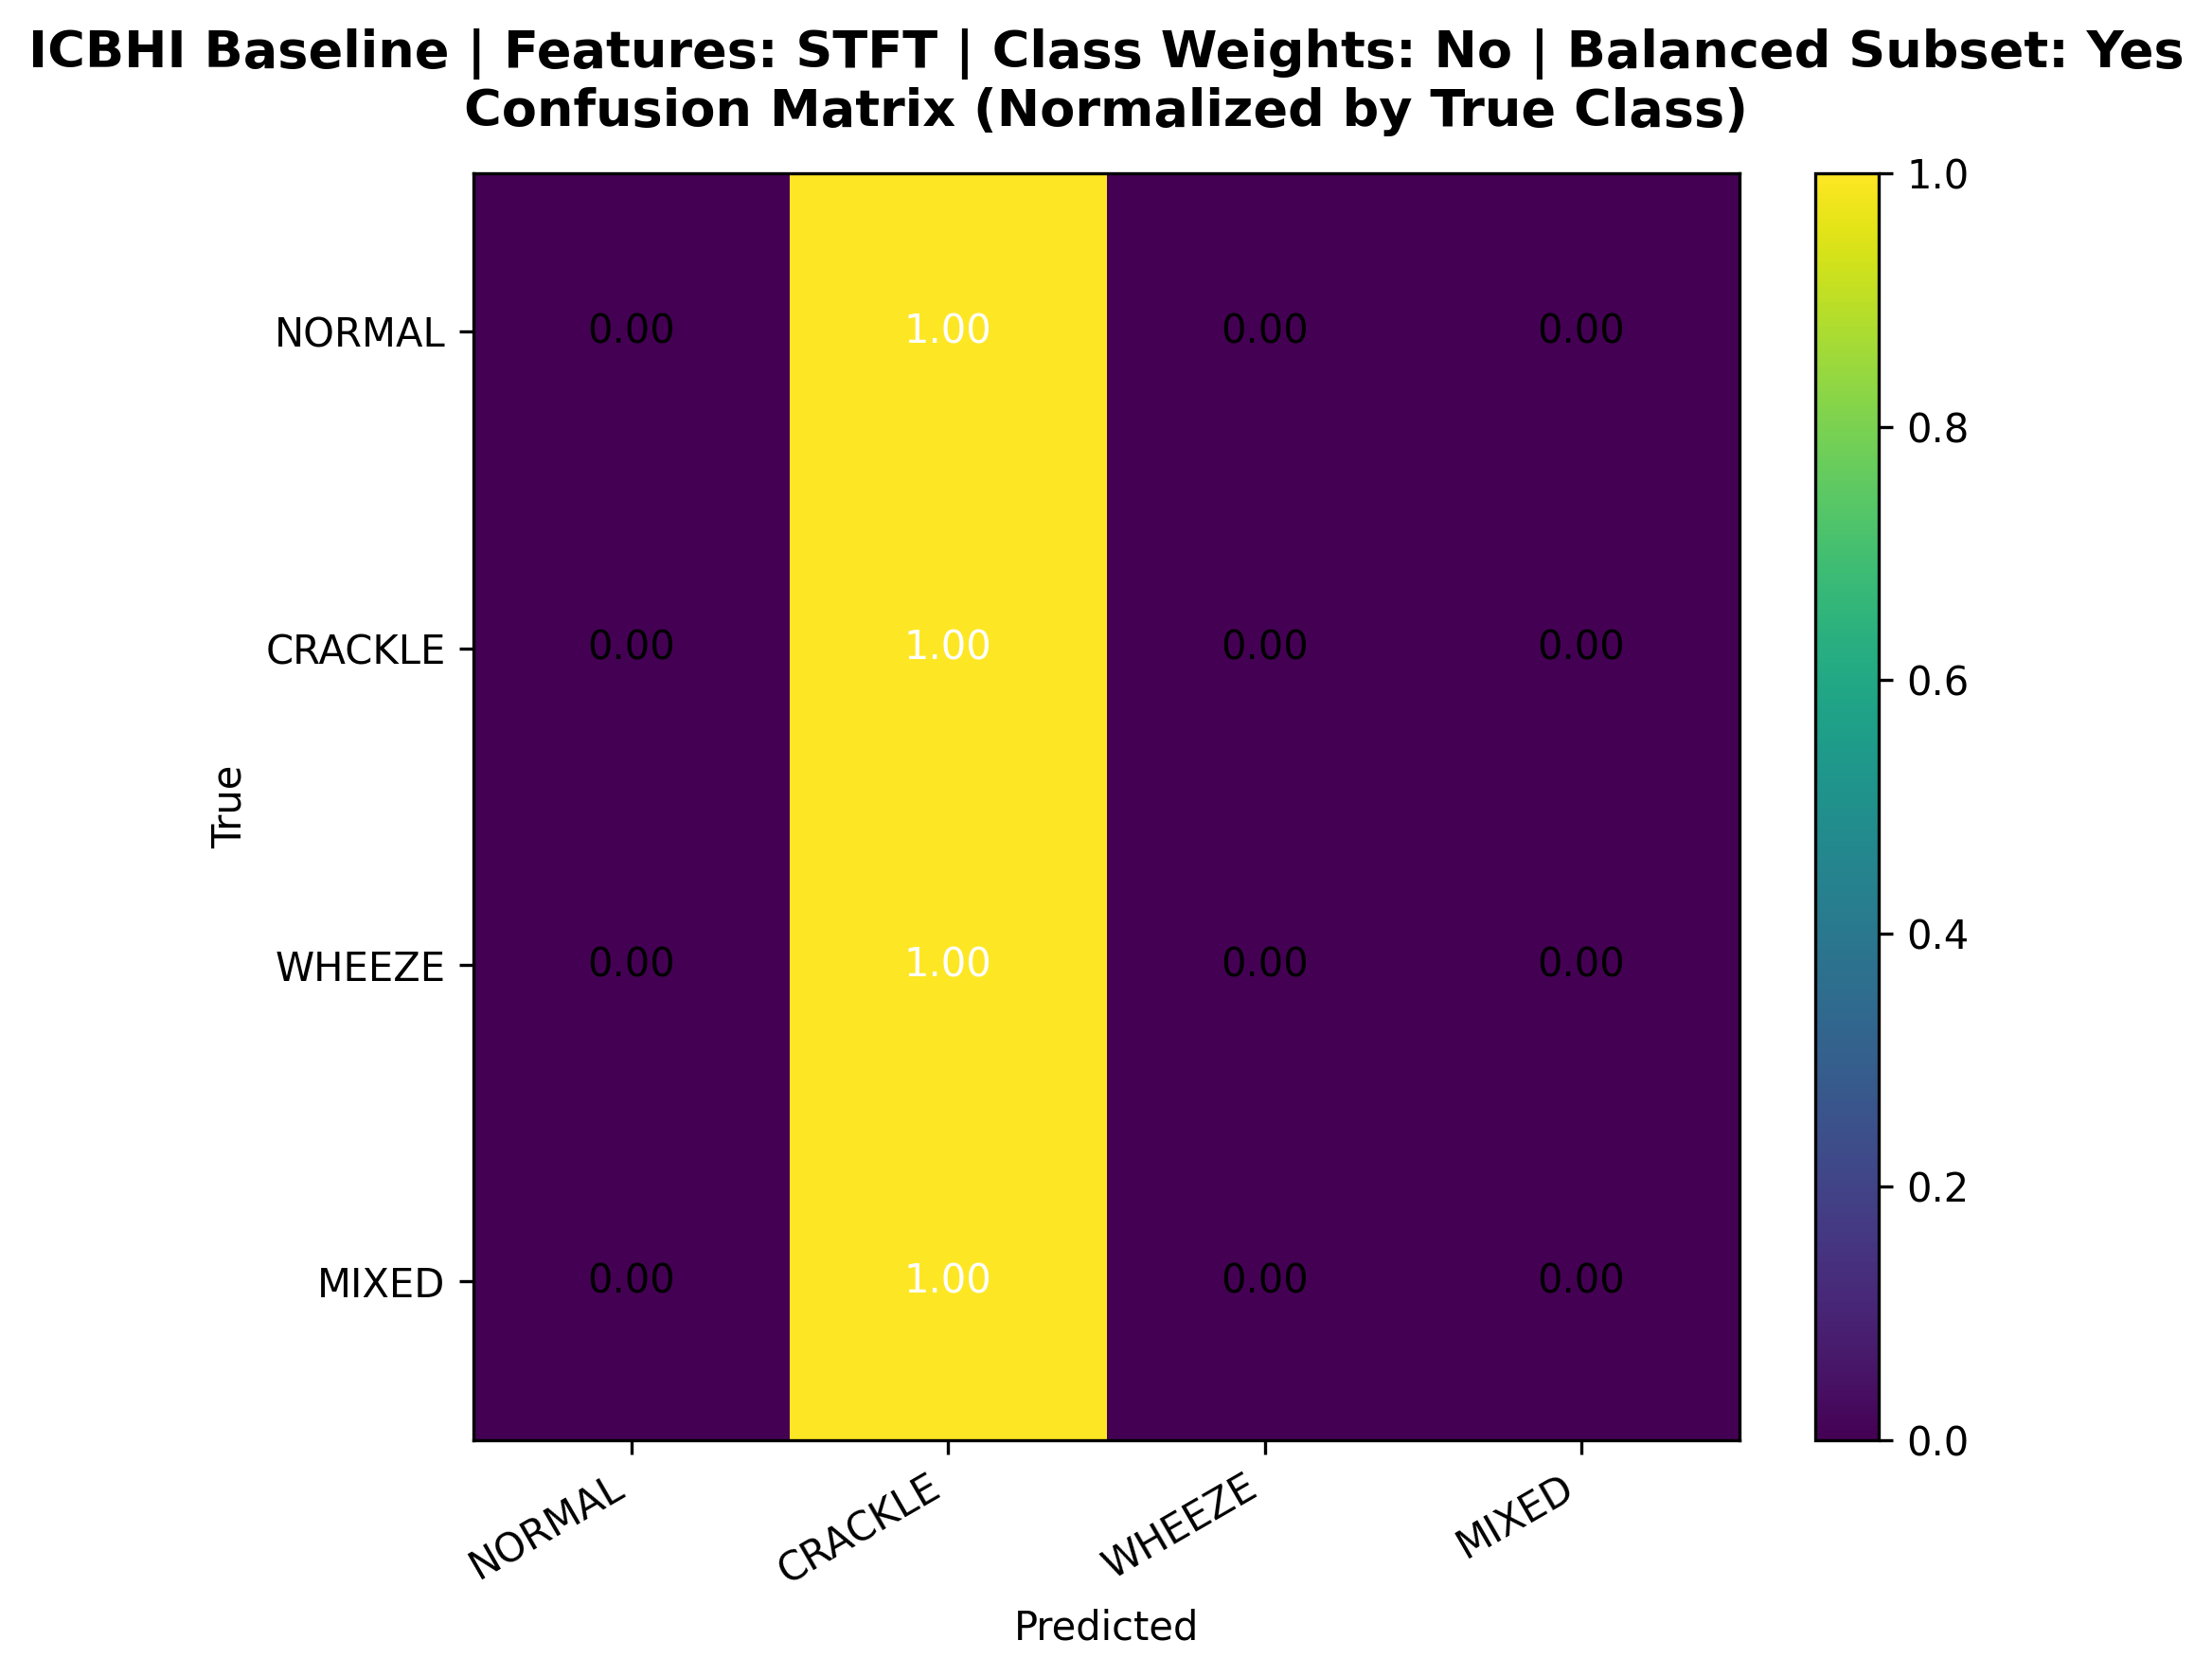

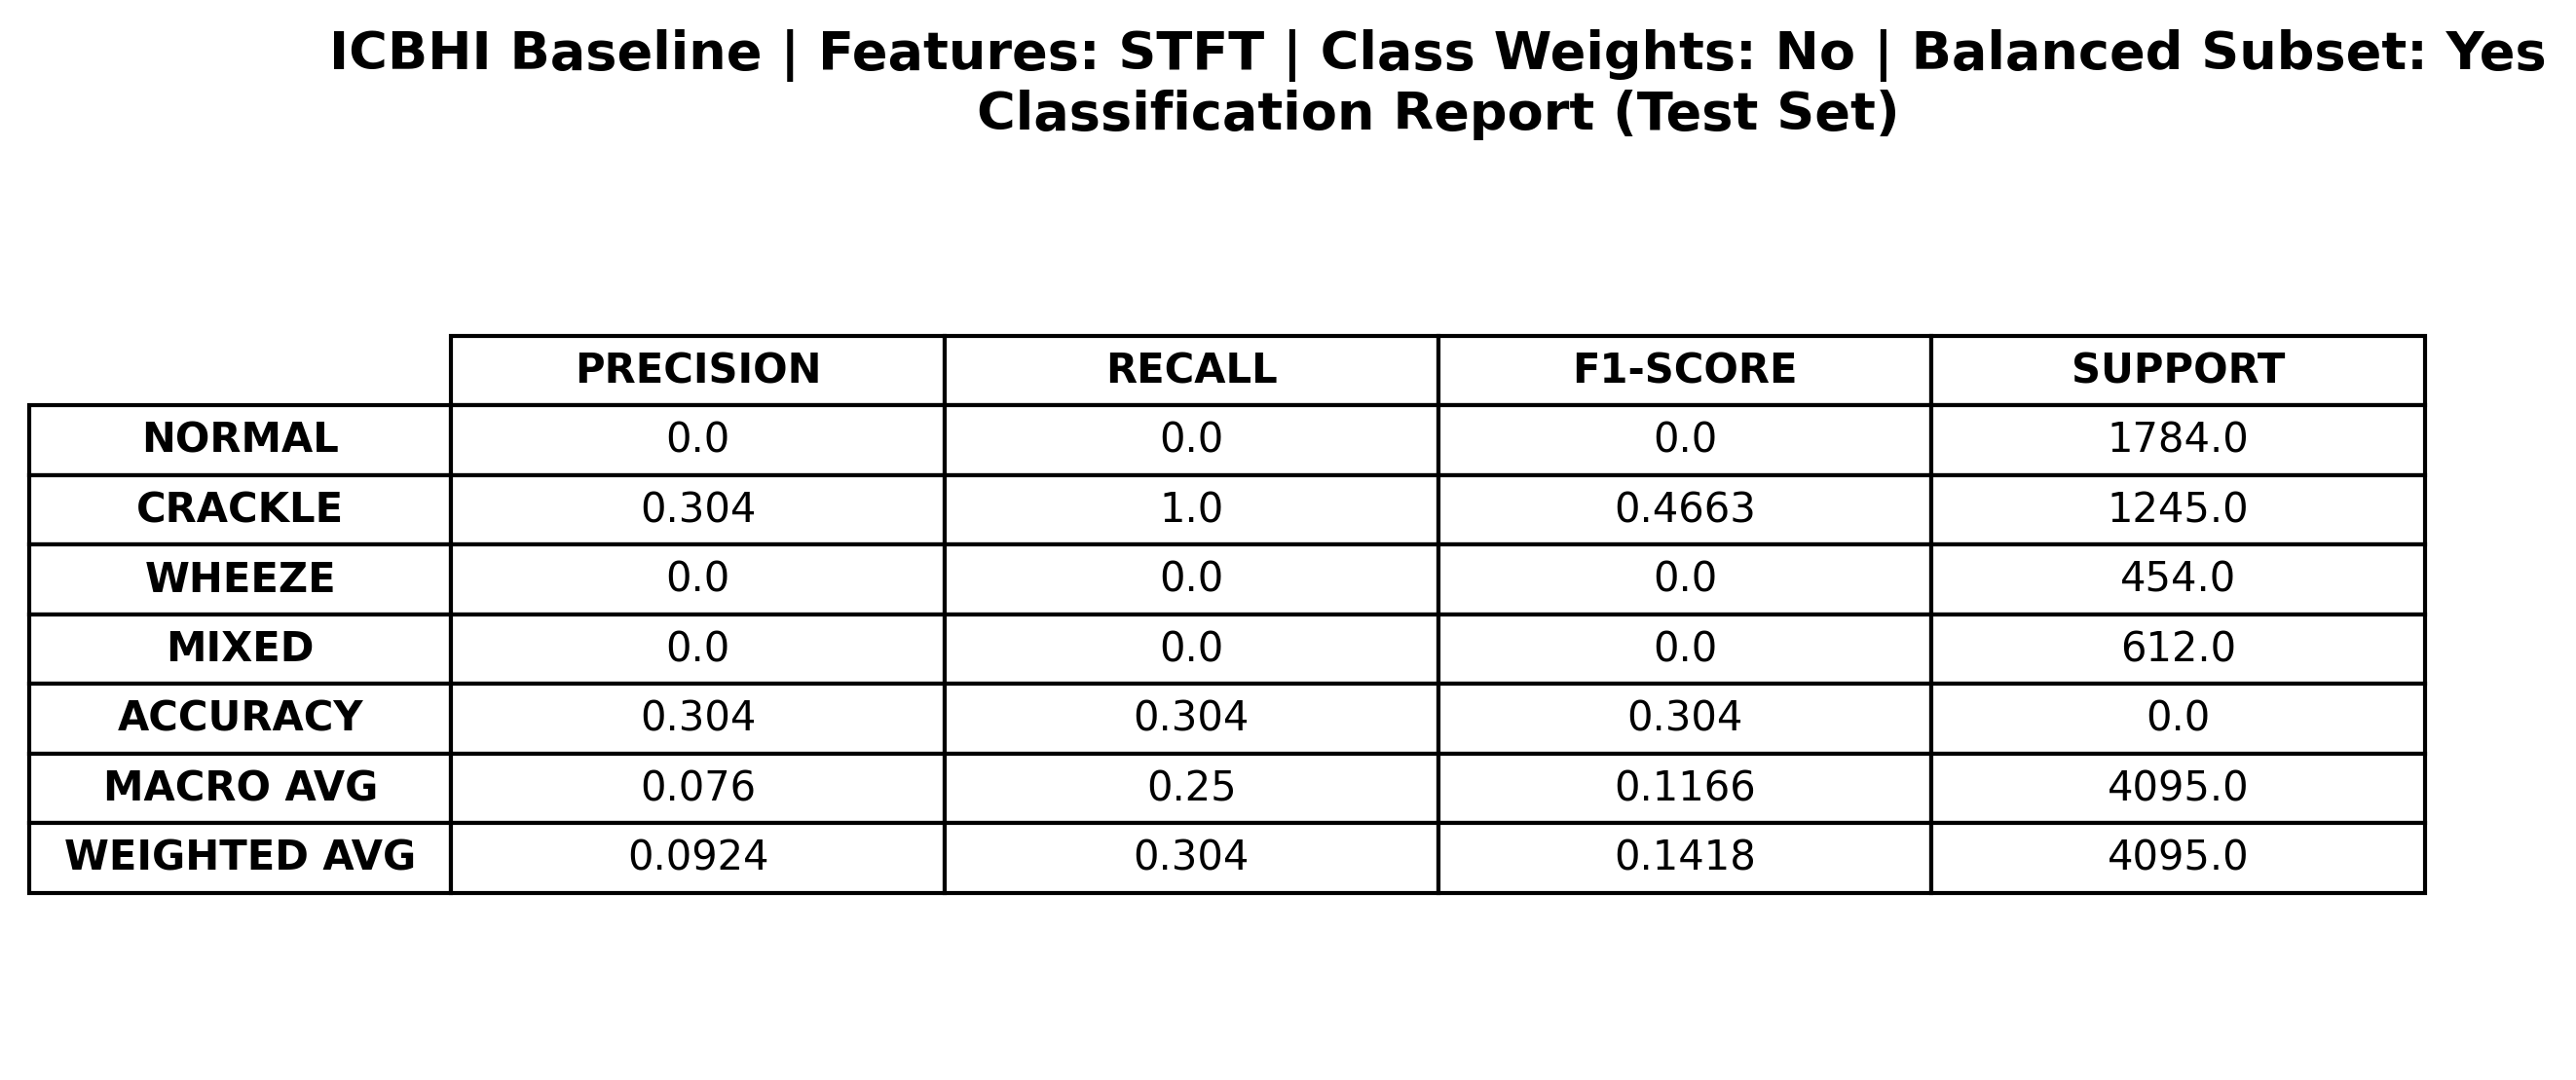

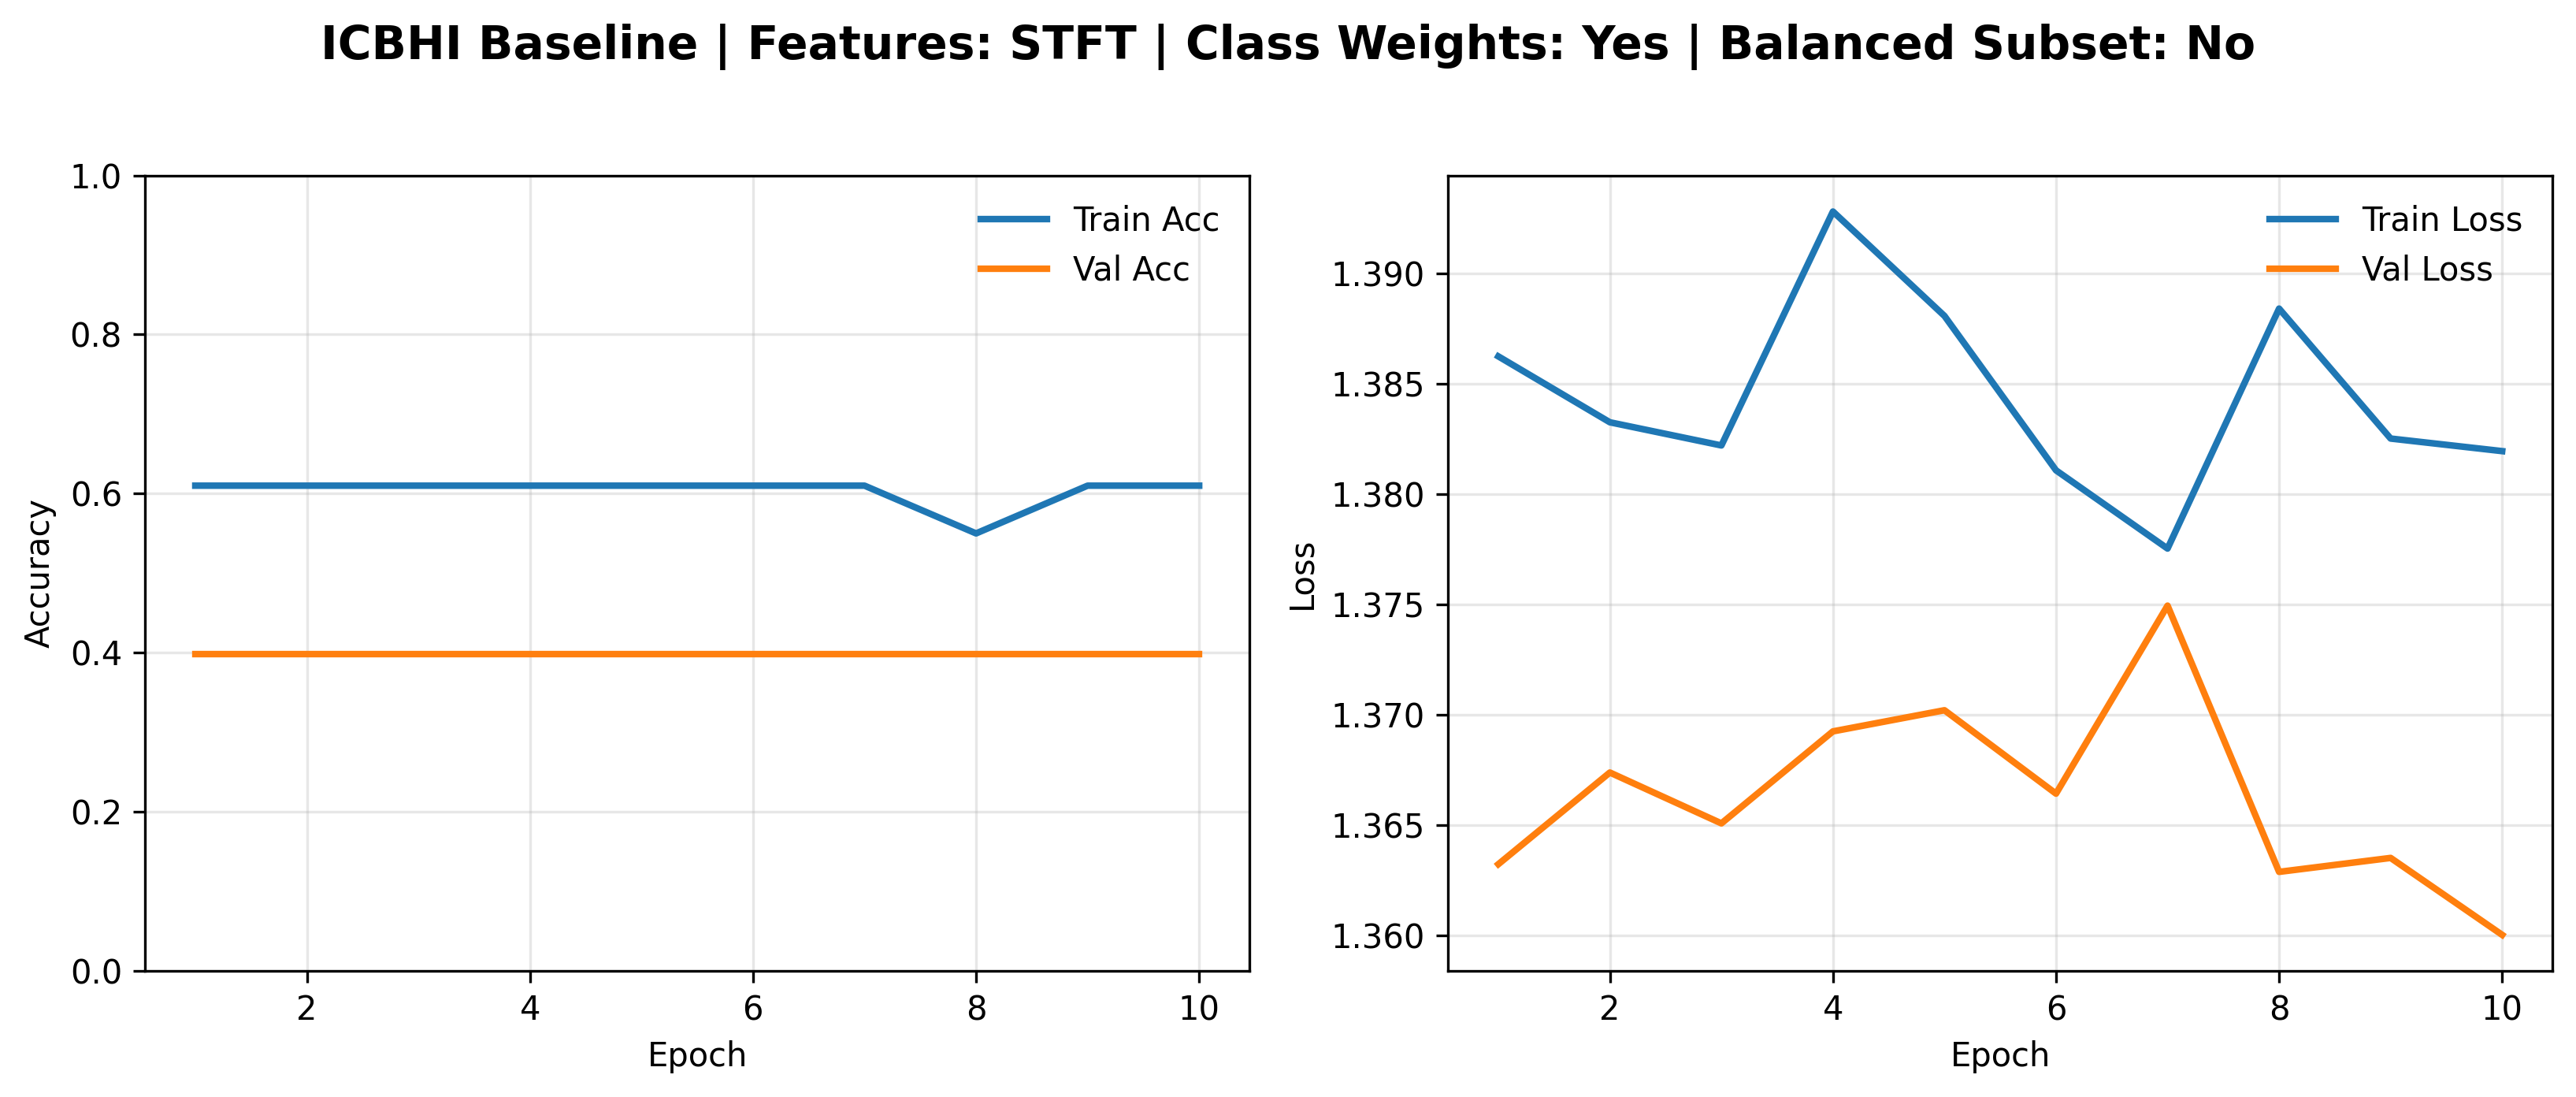

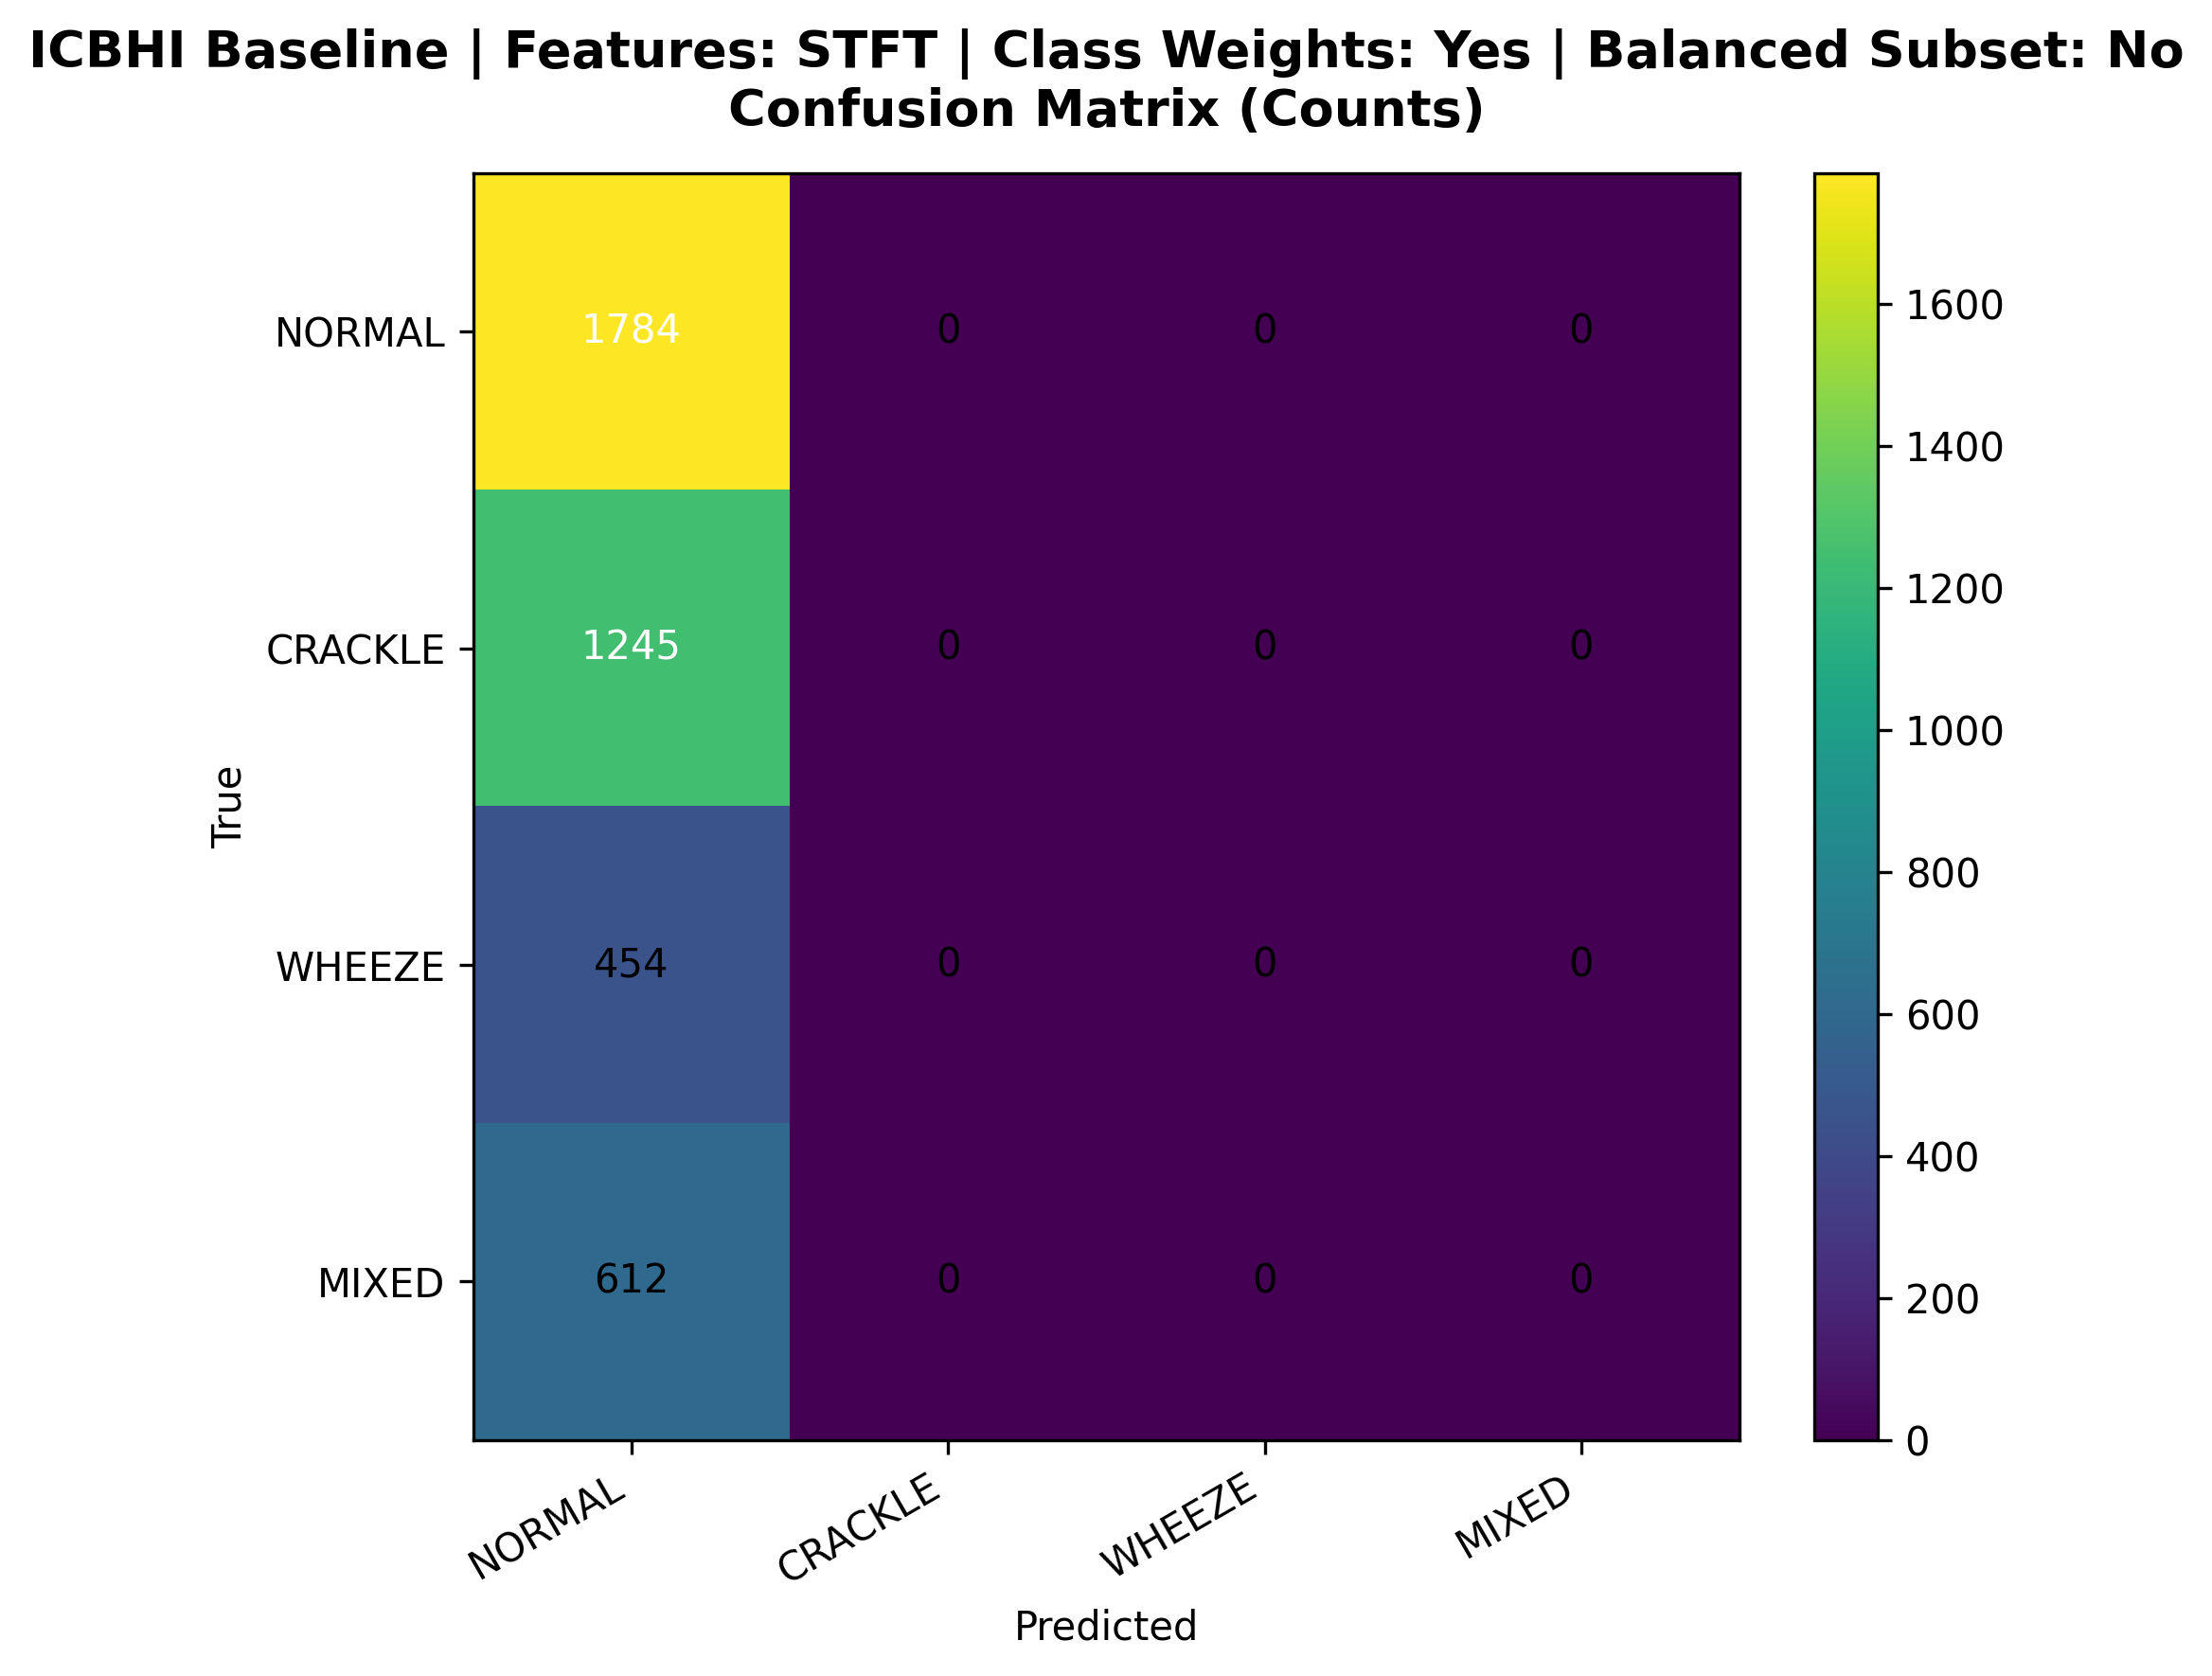

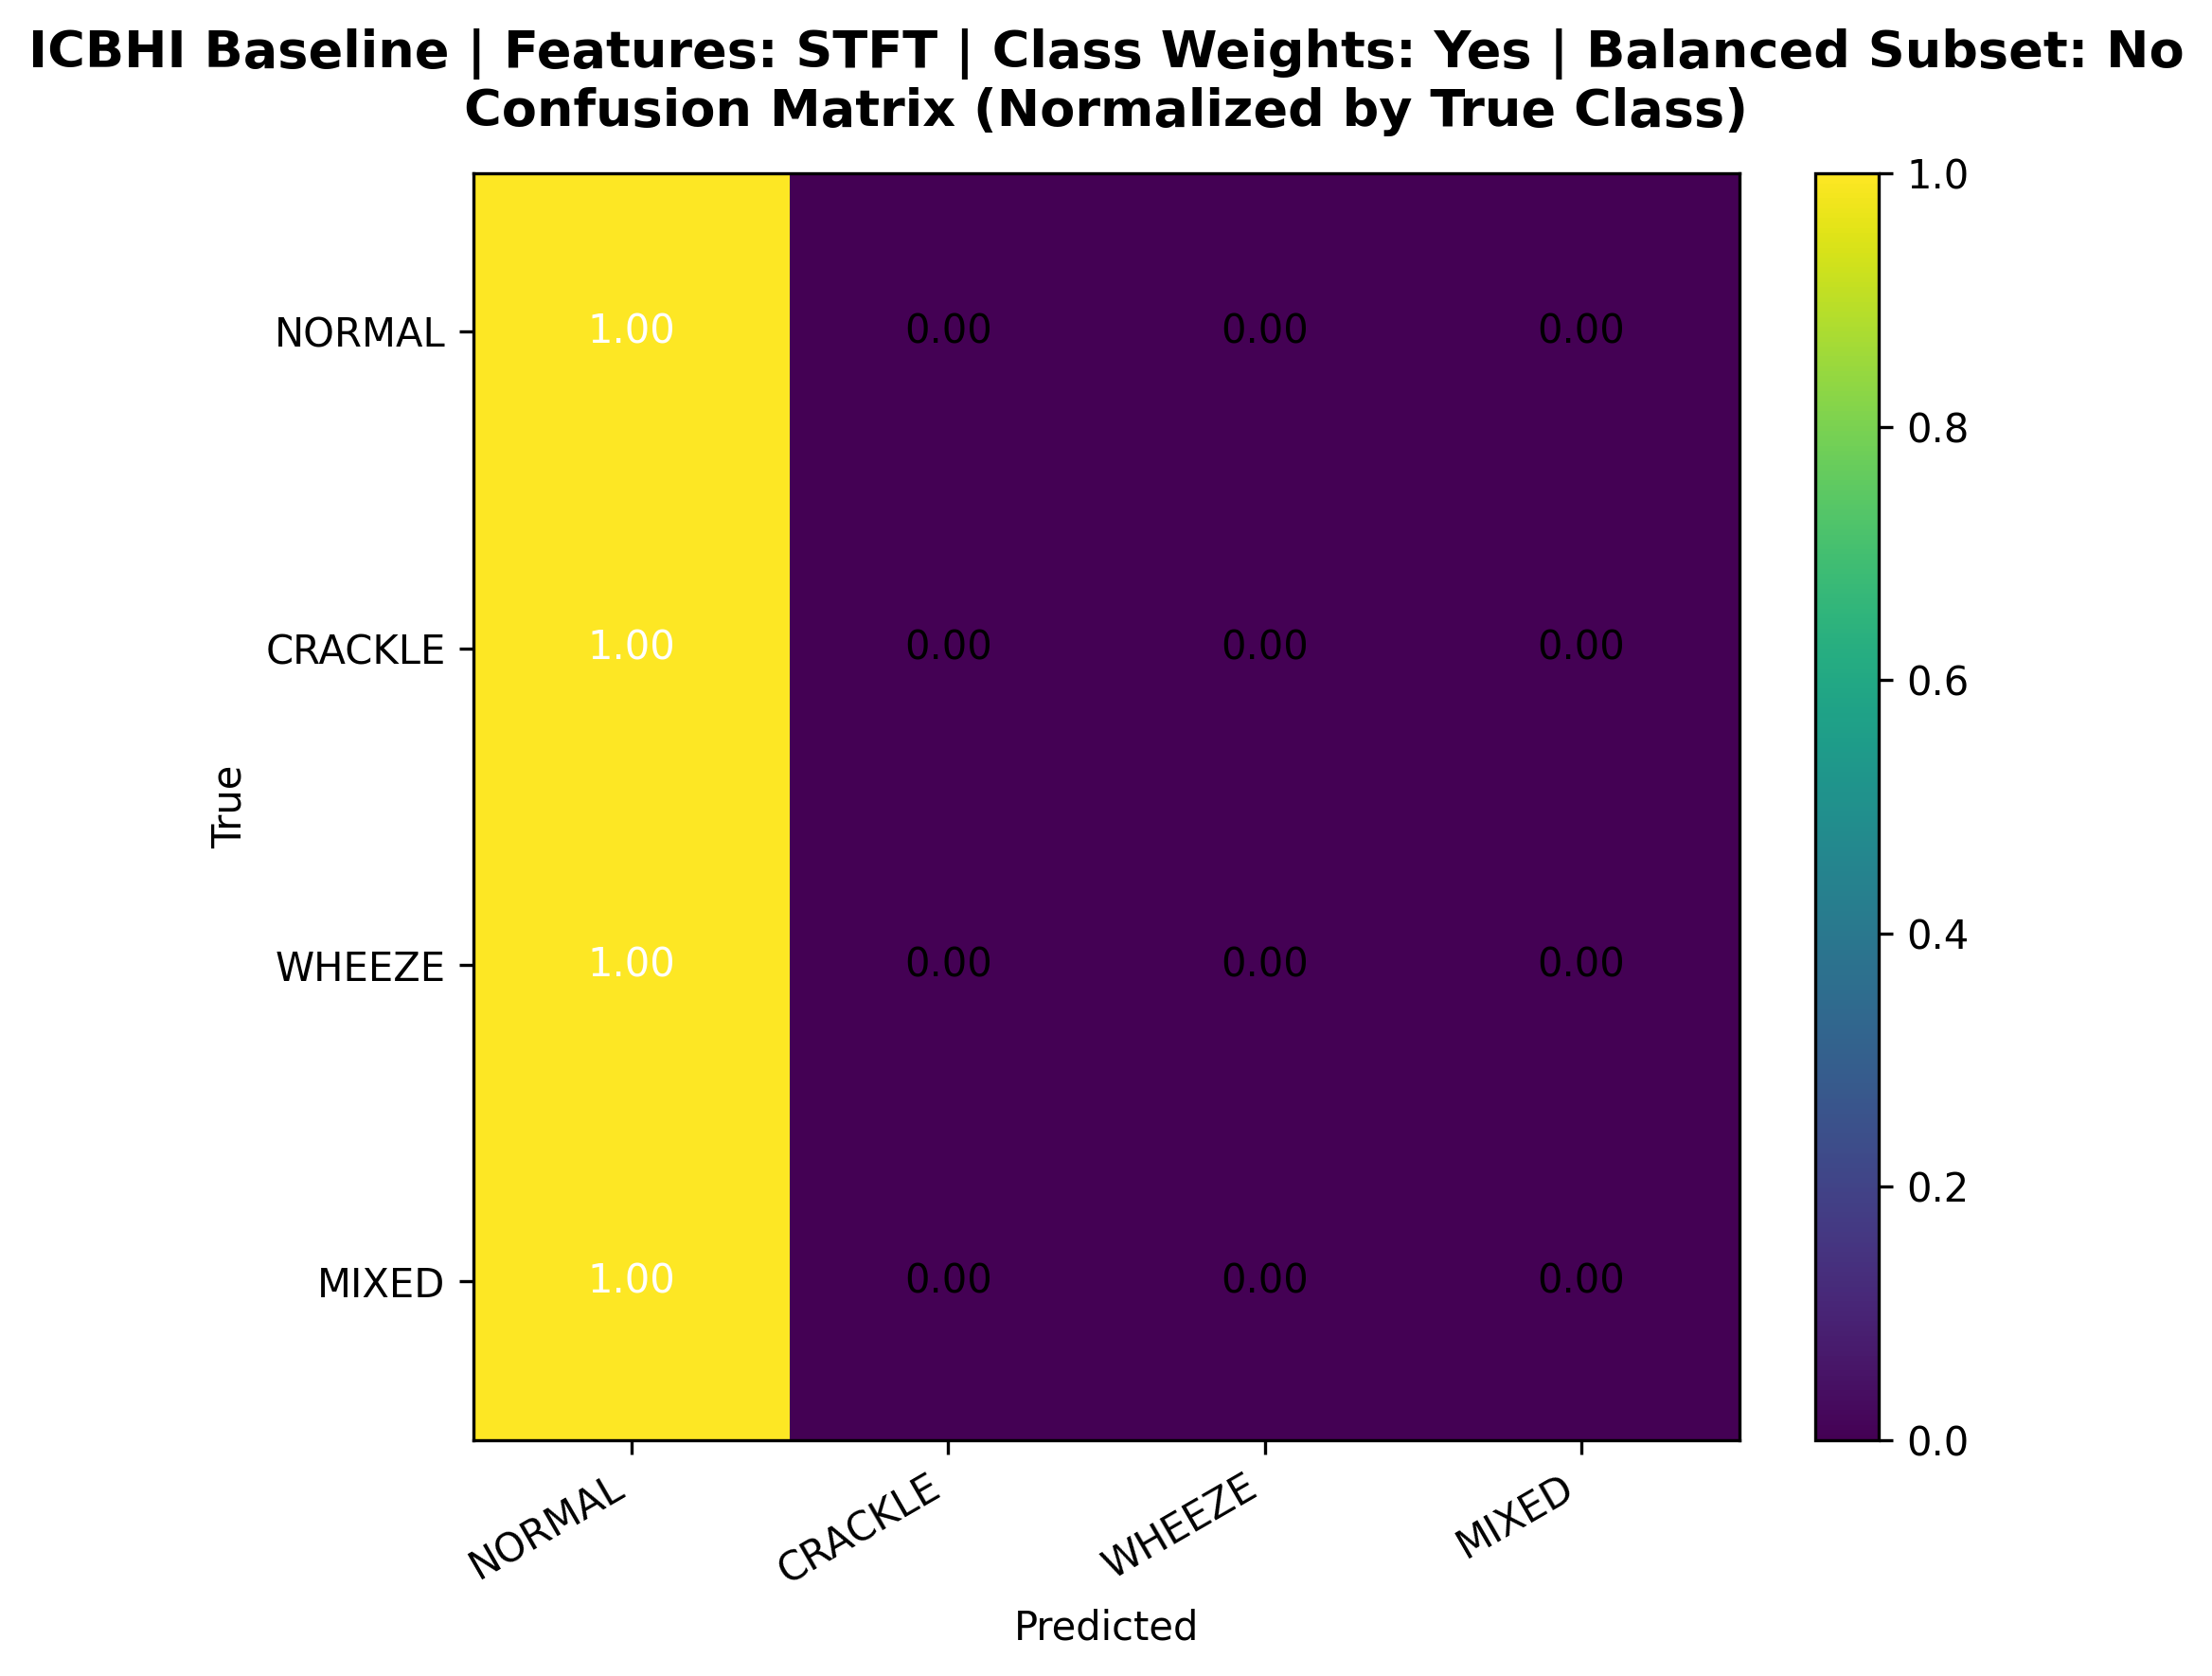

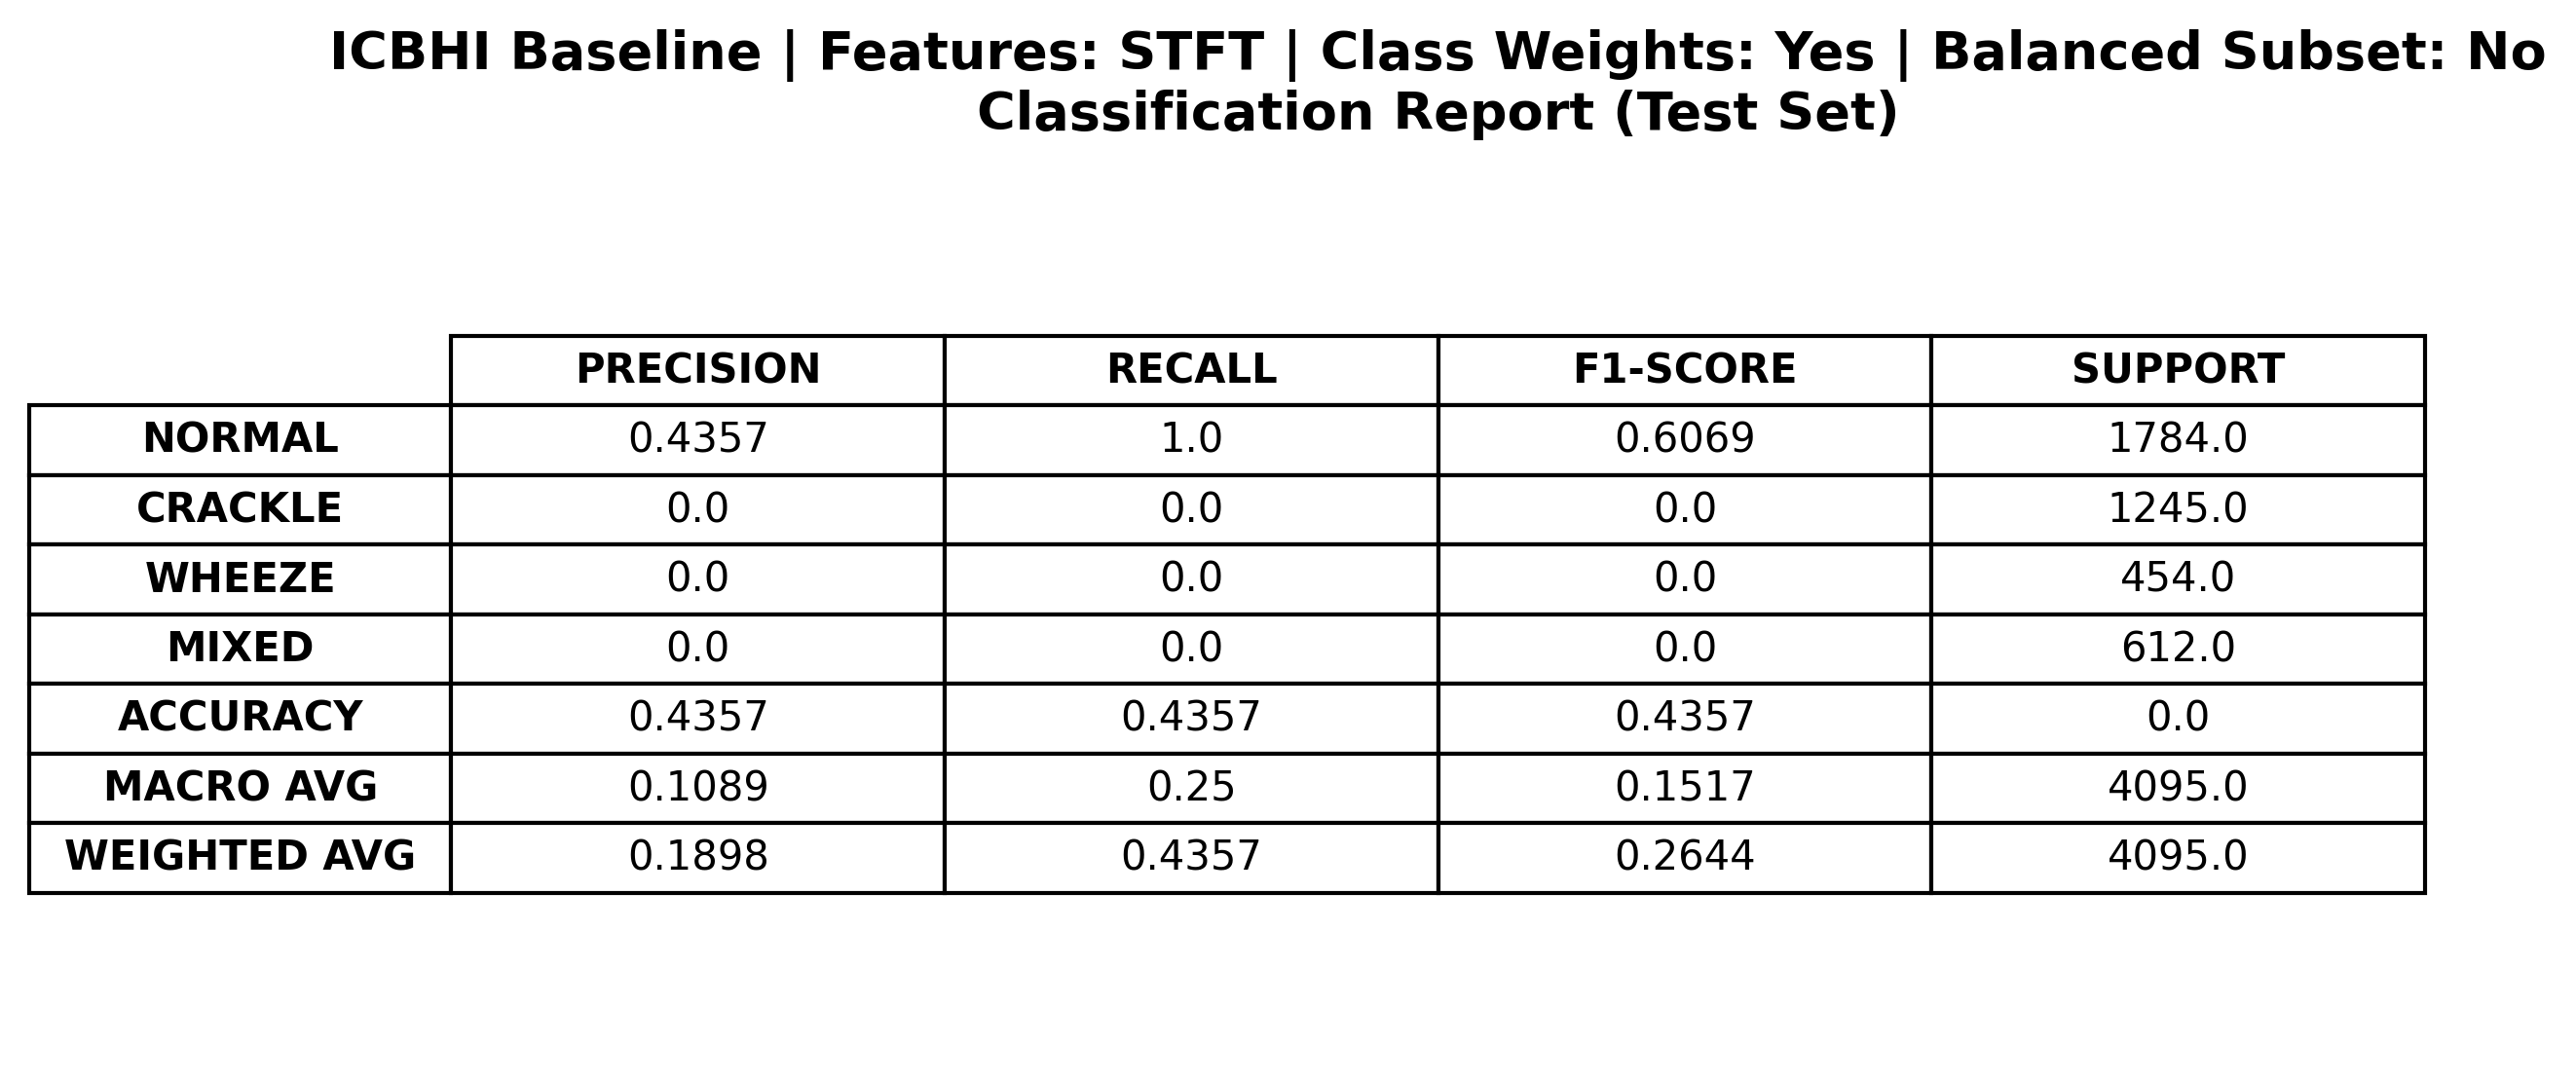

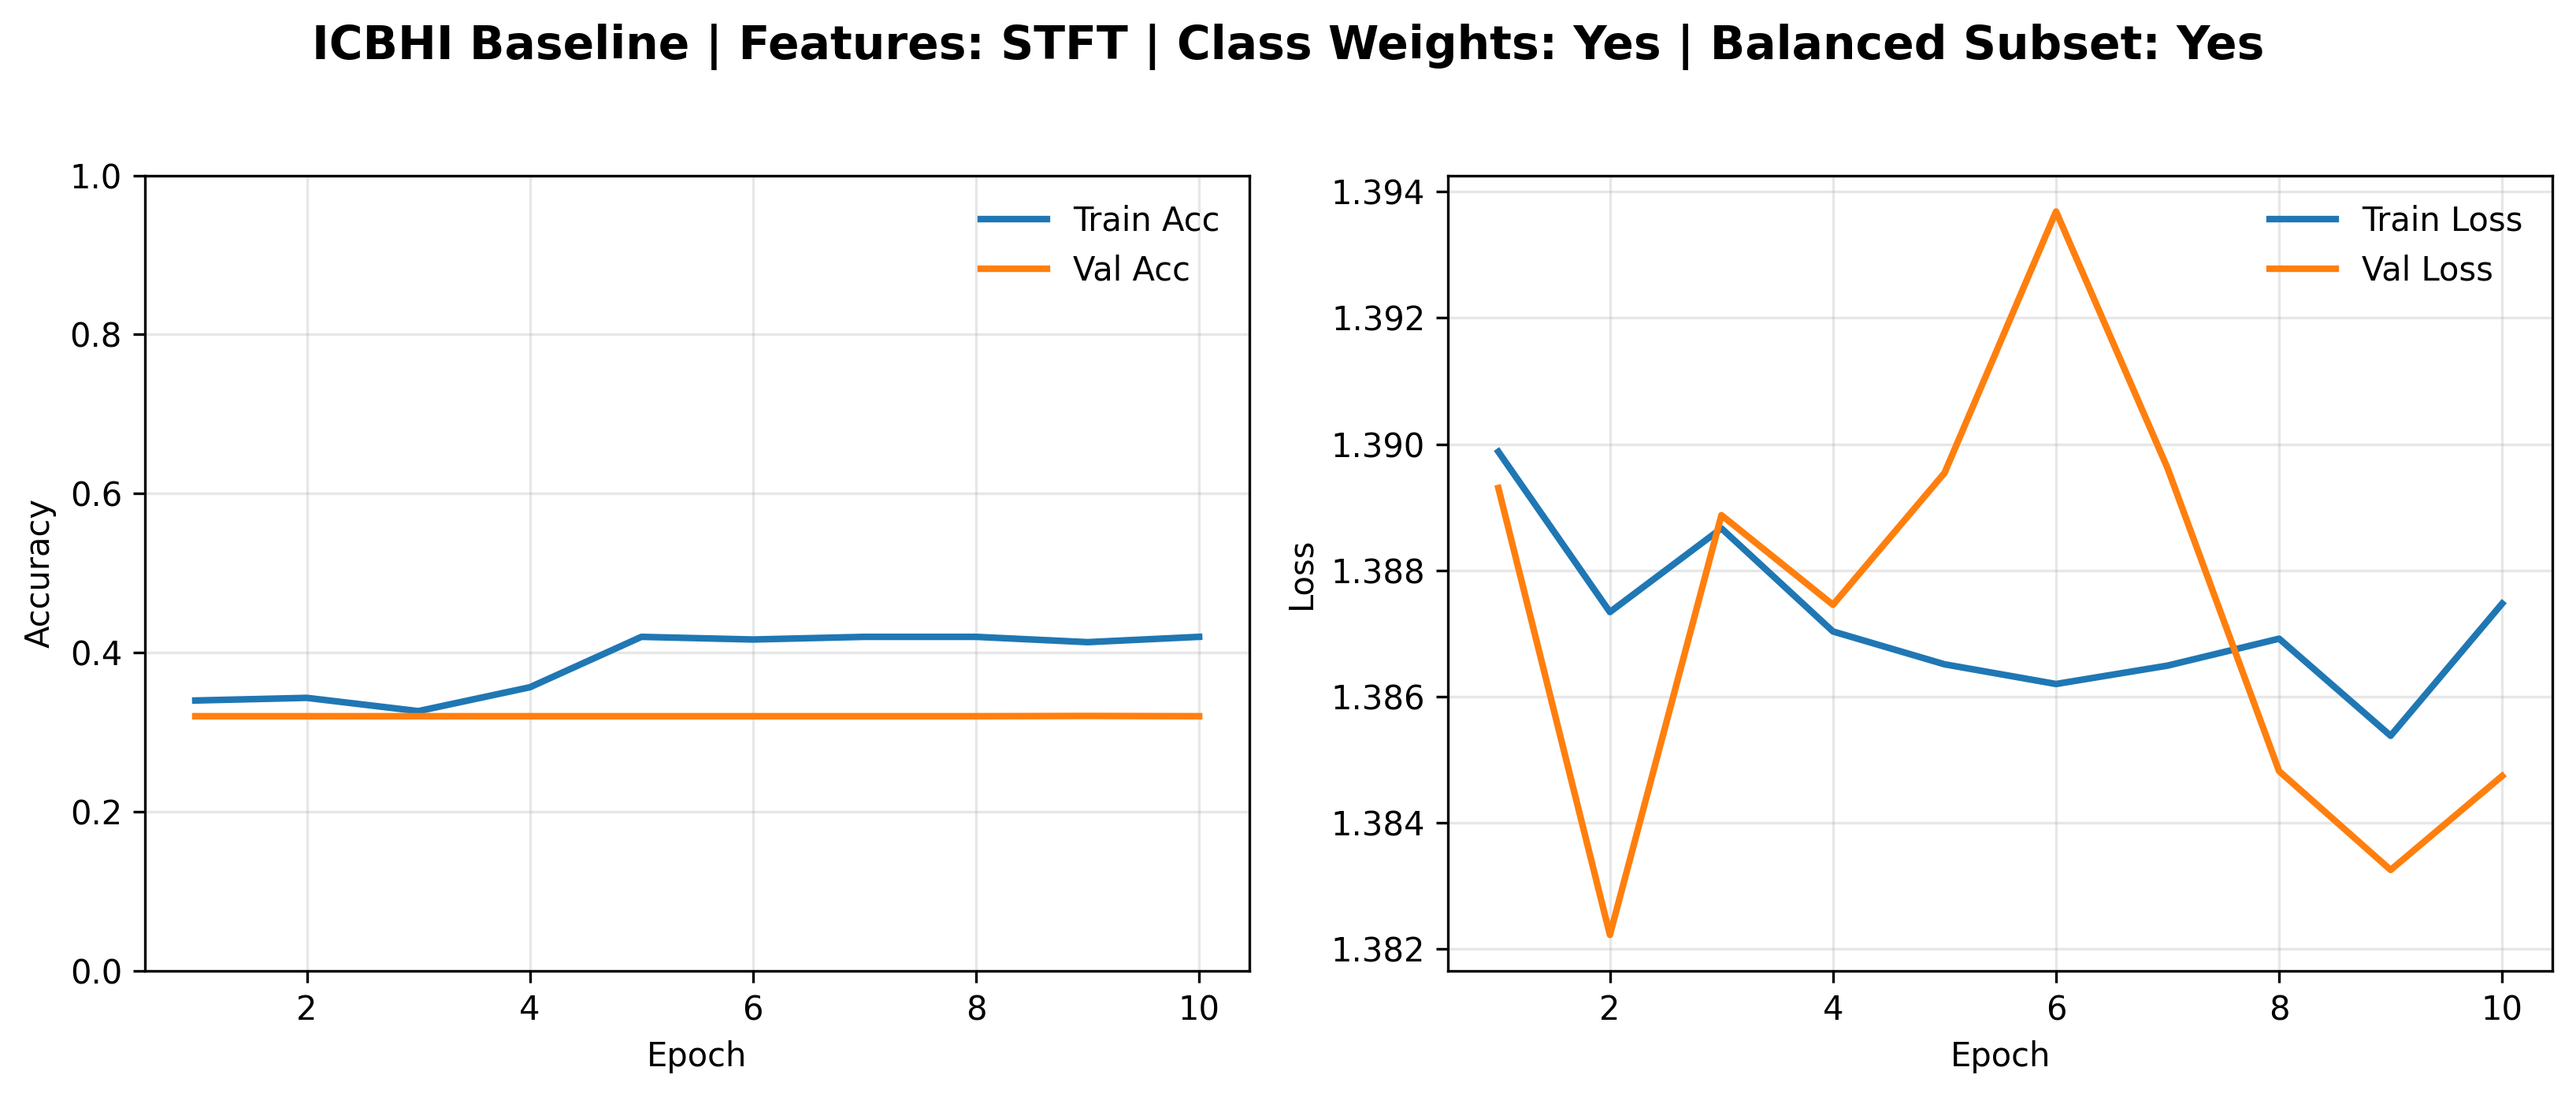

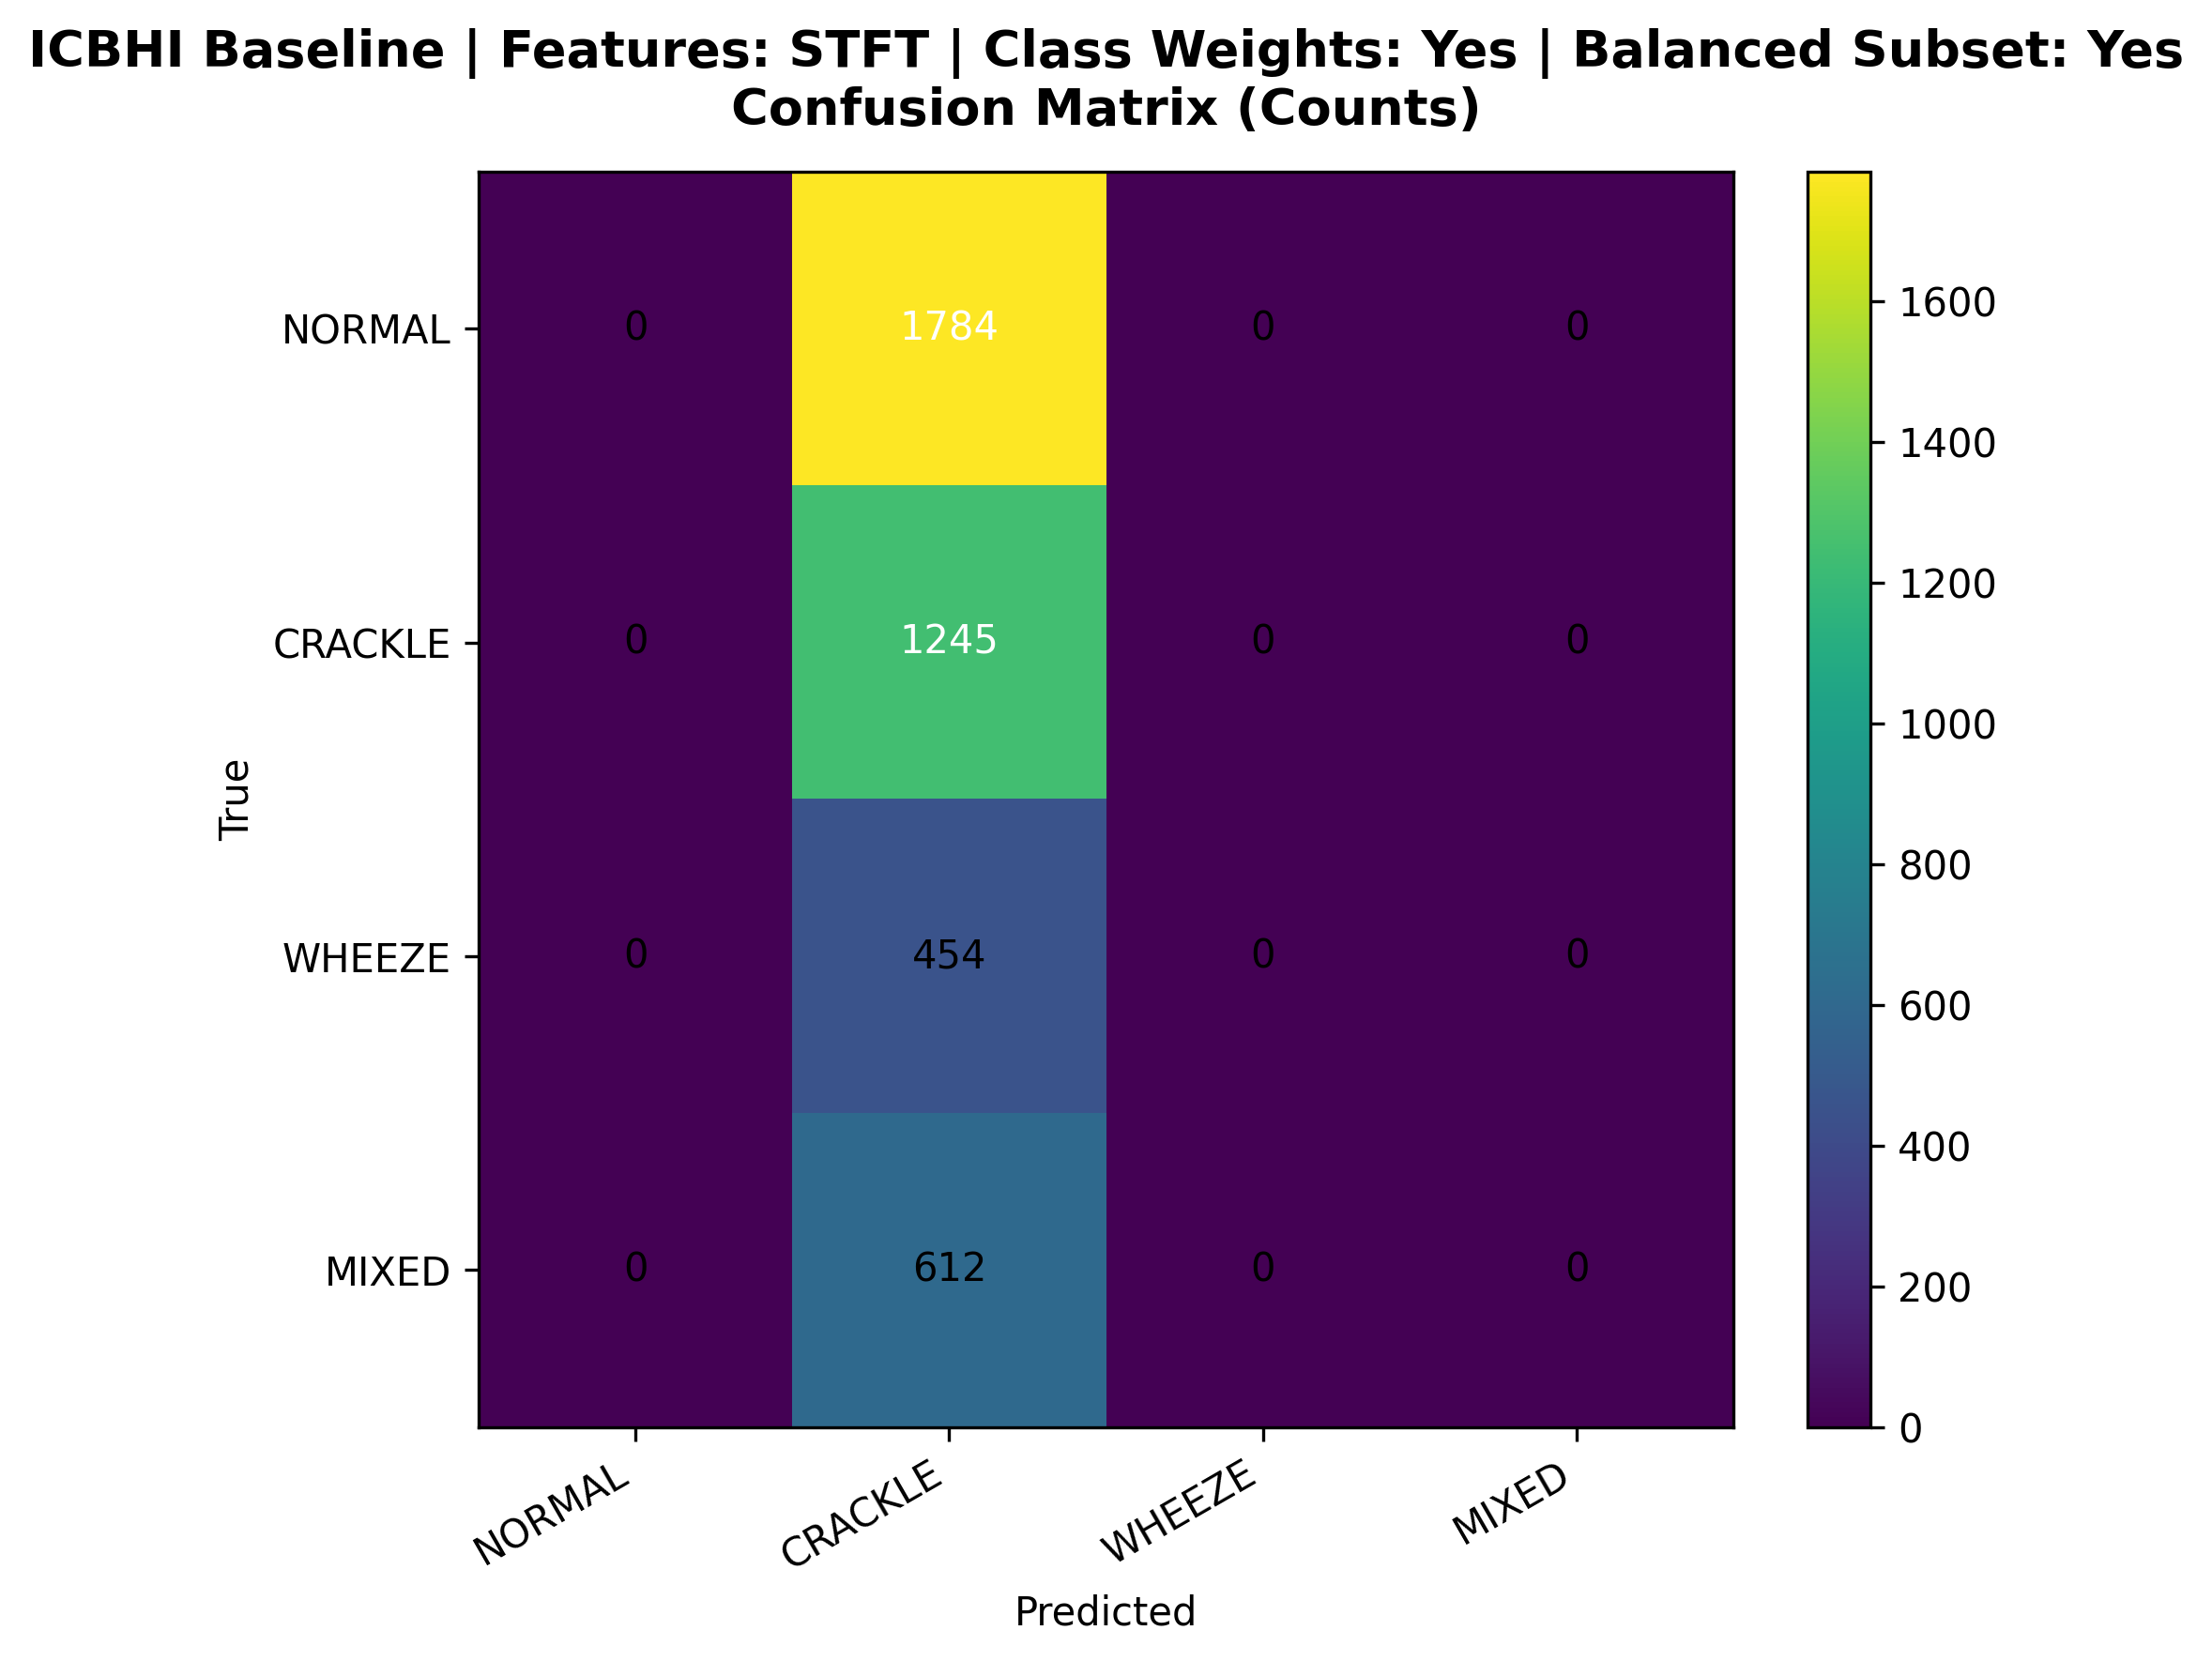

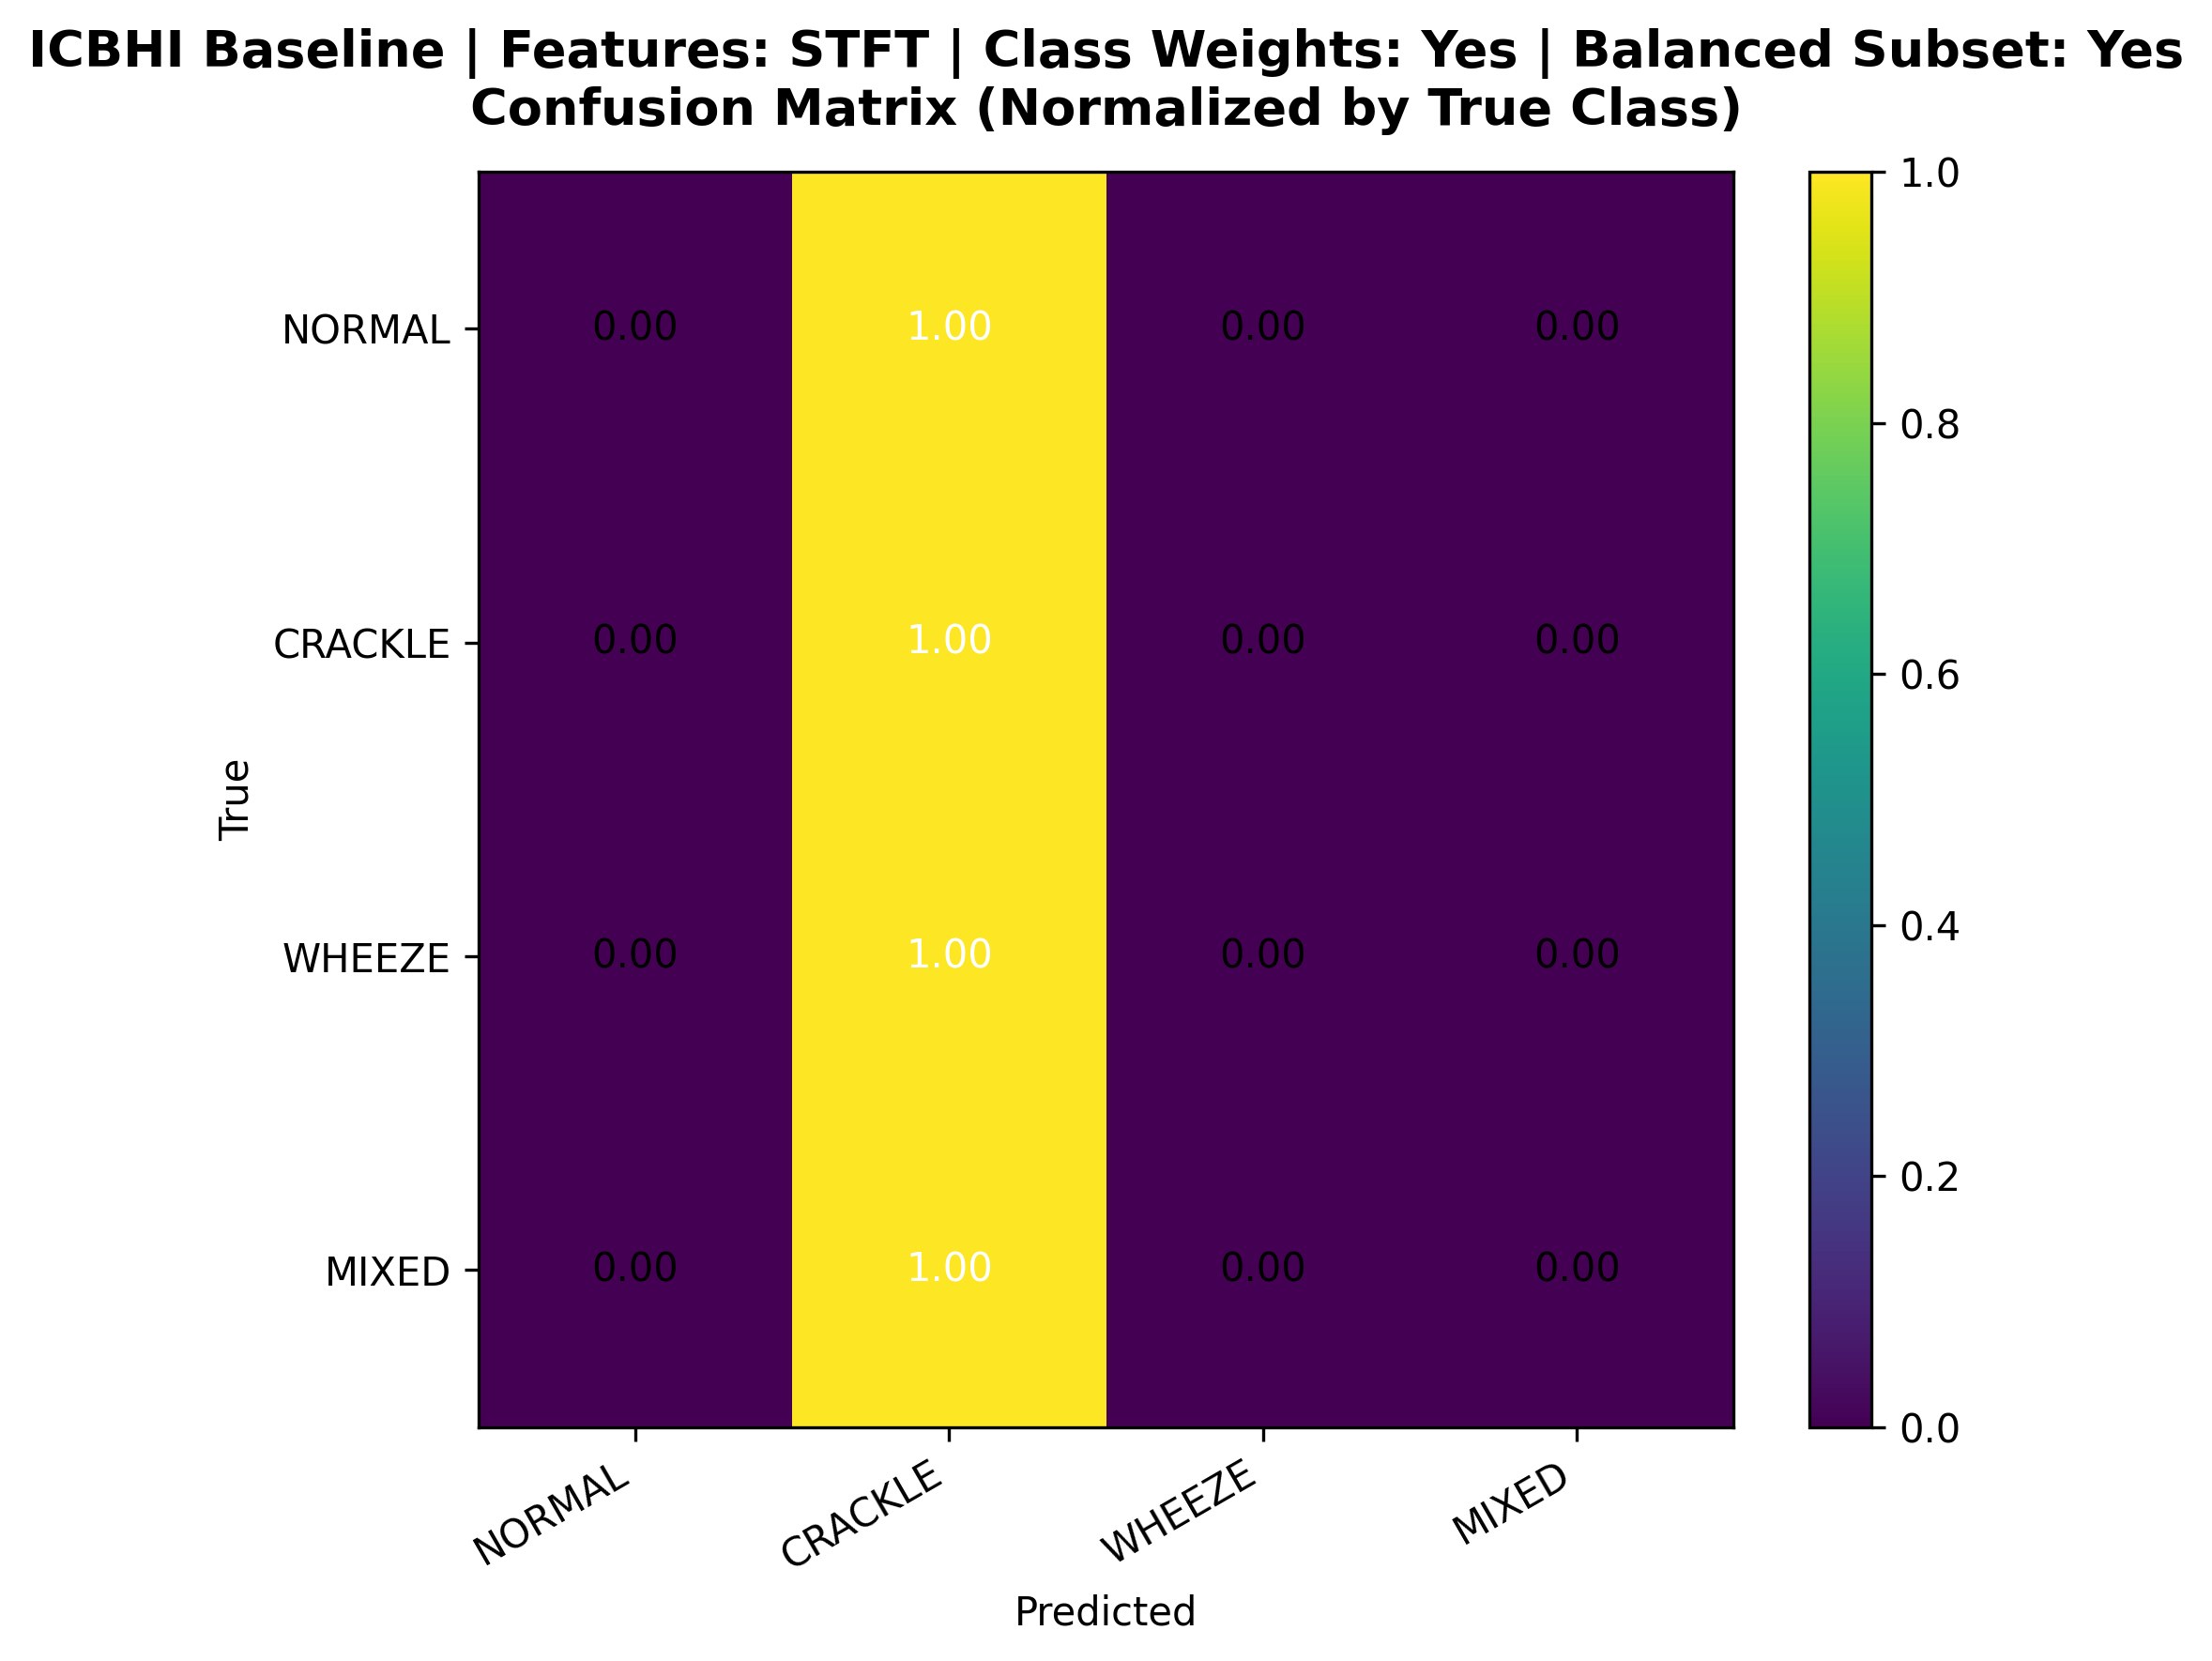

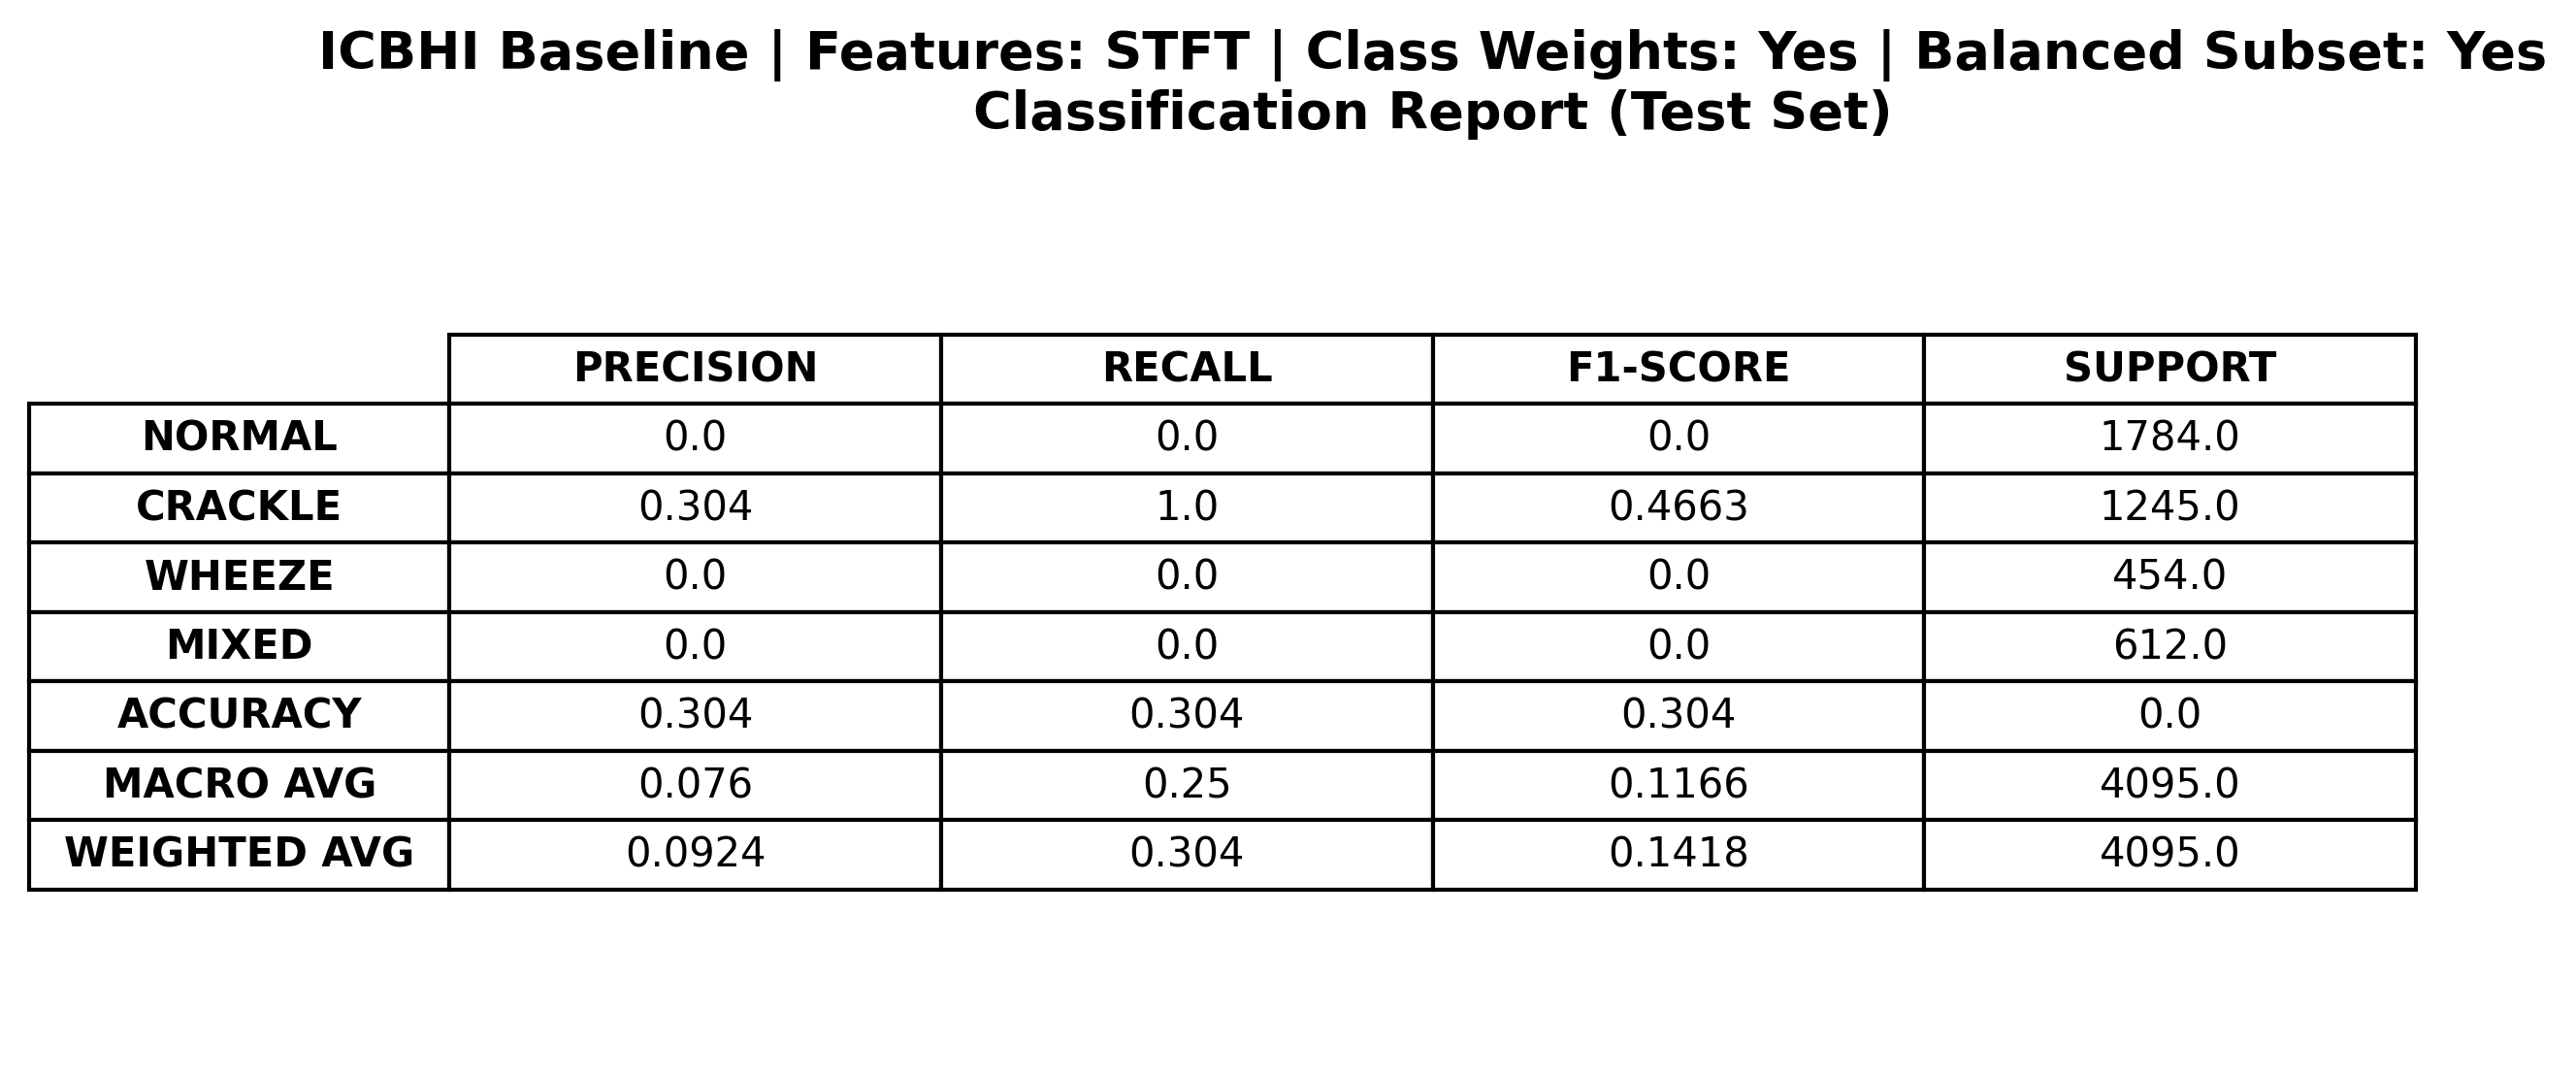

In [26]:
# of alles in een loop
for d in runs:
    plot_all_for_experiment(d, labels=["normal", "crackle", "wheeze", "mixed"], dpi=300)